# Model Design for Deep Learning in Practice Notebook

Vaibhav Chandra (vc2530)

DongRyong Choi (dc3454)

Erica Li (el3018)

Rohan Uppuluri (rku2101)



**Note**: Due to the randomness involved in the process of training a deep learning model, the results in the output of a cell of this notebook might not exactly match the results you get when you try to run the cell.

# Import Libraries

In [ ]:
!pip install keras-tuner

import numpy as np
import pandas as pd
import IPython

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# keras import
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, BatchNormalization, MaxPool2D
from keras.optimizers import Adam, Nadam, RMSprop, SGD
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.initializers import GlorotNormal
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2

# hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# data augmentation
from keras.preprocessing.image import ImageDataGenerator

# visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

#from tensorflow import keras 
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_hub as hub

#set figure size
plt.rcParams['figure.figsize'] = 12, 6
sns.set_style('white')

# others
from random import randrange
from time import time


import kerastuner as kt
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

%load_ext tensorboard
import datetime, os
from packaging import version

# Clear any logs from previous runs
!rm -rf ./logs/ 

# For use of Tensorboard later
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

print("TF version: ",tf.__version__)
print("Keras version:",tf.keras.__version__)


     |████████████████████████████████| 71kB 3.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=f1d423c8c51d483161368f4c17dc972cac28f450112b24717d3e7438078f3907
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=bea23f01102f730c6ba5818dd10e1568ff74424db421b8c8be80aa623ad89752
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables
TF version:  2.4.0
Keras version: 2.4.0


# MNIST

## Unregularized MLP

We first trained an unregularized MLP with 2 hidden layers and 16 hidden units with ReLU activations as the baseline model for MNIST.

Note that we use the default optimizer, which is Adam with learning rate 0.001 and the default initializer, which is glorot uniform.

In [ ]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train, x_test = tf.cast(x_train,dtype=tf.float32)/255.0, tf.cast(x_test,dtype=tf.float32)/255.0
#y_train, y_test = tf.one_hot(y_train, depth=10),tf.one_hot(y_test, depth=10)

In [ ]:
# MNIST: (28,28) - > 784 -> 128 -> 10 logits

# Sequential API
unregularized_mlp = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape = (28,28)),
      tf.keras.layers.Dense(16, activation='relu'), 
      tf.keras.layers.Dense(16, activation='relu'), 

      #Add layers
      tf.keras.layers.Dense(10)
])

In [ ]:
unregularized_mlp.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),#based on one-hot vector
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]) 
              

In [ ]:
history = unregularized_mlp.fit(x_train,y_train, batch_size=128,epochs=100,
          validation_split = 0.2,verbose=0,
           callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logs_base_dir, histogram_freq=1)],
          ) #validation_data= [x_valid,y_valid])
#training examples = 48000, batch size =32 -> no.steps in each epoch

We end up with an out of sample accuracy of 95.17%.

In [ ]:
unregularized_mlp.evaluate(x_test,y_test,batch_size=128)

79/79 [==============================] - 0s 3ms/step - loss: 0.2349 - sparse_categorical_accuracy: 0.9518


[0.23485210537910461, 0.9517999887466431]

In [ ]:
#%tensorboard --logdir {logs_base_dir}

## Architecture

In [ ]:
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
train_images, test_images = train_images / 255.0, test_images / 255.0

(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = tf.cast(x_train,dtype=tf.float32)/255.0, tf.cast(x_test,dtype=tf.float32)/255.0
#y_train, y_test = tf.one_hot(y_train, depth=10),tf.one_hot(y_test, depth=10)

#increases the dimension by 1
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


### Deciding on optimal architectures

We utilized early stopping as a way to prevent the models from overfitting the training data. Through empirical testing, patience=10 worked the best to solve our issues of training accuracy being higher than validation accuracy, and max validation accuracy being higher than final validation accuracy. Employing early stopping was also an effective strategy to improve computational feasability (we can train for fewer than the baseline 100 epochs and get even better results).

#### Depth of fully connected layers

**In this section, we will explore fully connected layers.** Fully connected layers (or dense layers) are simple to understand and computationally cheap relative to other types of layers such as CNNs and RNNs. For such reasons, dense layers are practical to work with, and we will examine the optimal number of layers as well as the filter sizes. Through empiral exercises as shown below, we have found that **8 Dense layers with 128 units each layer was optimal, achieving 98% validation accuracy**. 

Building up from Section 1, we did not know how effective was 2 dense layers. In the following blocks, we explore different numbers of hidden layers to see **how the depth of a fully connected neural network architecture affects performance**. Through empirical exercises, our key observations and illustrations are as follows:

*  **We tested neural networks of 1, 2, 4, 8, 16, and 32 dense layers and found that 2/4/8 layers may be optimal**. Its training accuracy is the second lowest but its validation accuracy is one of the highest. Its performance is the most consistent and we see continuous improvement in performance as the number of epochs increase. 

*  "The more complex (more layers) a deep learning model has, the better it performs" does not apply to analyzing MNIST data. The neural network with 32 dense layers had the worst performance among all the models we tested.

*  Most models had increasing training accuracy but validation accuracy actually peaked around 20 epochs (suggestive of overfitting). The only exception was 8 and 16 dense layers and the latter had better performance. 

*  With the help of early stopping method, we enhanced the computation speed and we have achieved the visualization of different models' evaluation comparison.

In [ ]:
# helper function
def dense_model(layers):
  model = Sequential()
  model.add(Flatten(input_shape = (28,28)))

  for unit in layers:
    model.add(Dense(units = unit, activation = 'relu'))

  model.add(Dense(units = 10, activation = 'softmax'))
  return model

In [ ]:
depths = [1,2,4,8,16,32]
history_dense = []

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20) #we accept 20 times of increase in valid_loss

for depth in depths:
  model = dense_model([16] * depth)
  #model.summary()
  model.compile(optimizer = tf.keras.optimizers.Adam(), #'adam'
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  history_dense.append(model.fit(x_train, y_train, batch_size = 128, epochs=100, validation_split = 0.2, callbacks = [early_stopping_cb],verbose = 0))
  #print(f'loss = {loss}, accuracy = {accuracy}')

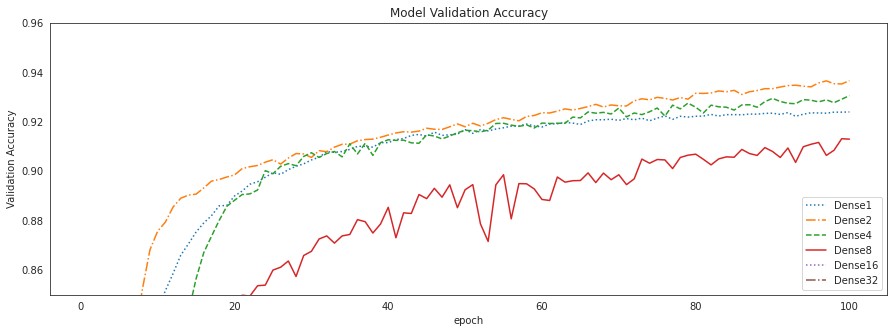

In [ ]:
depths = [1,2,4,8,16,32] 
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']
names = ['Dense'+str(depth) for depth in depths]

# Plot validation accuracies 
plt.figure(figsize=(15,5))
for i in range(len(depths)):
    length = len(history_dense[i].history['val_categorical_accuracy'])
    epochs_i = np.arange(length) + 1
    plt.plot(epochs_i, history_dense[i].history['val_categorical_accuracy'],linestyle=styles[i])
plt.title('Model Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.85,0.96])
plt.show()

In [ ]:
# Max validation accuracy per model for dense case

for i in range(len(history_dense)):
  print('Max Validation Accuracy for '+ names[i] +' is {0:.4f}'.format(max(history_dense[i].history['val_categorical_accuracy'])))
  
  print('Final Validation Accuracy for '+ names[i] +
        ' is {0:.4f}'.format(history_dense[i].history['val_categorical_accuracy'][len(history_dense[i].history['val_categorical_accuracy'])-1]))
  print('')

Max Validation Accuracy for Dense1 is 0.9240
Final Validation Accuracy for Dense1 is 0.9240

Max Validation Accuracy for Dense2 is 0.9367
Final Validation Accuracy for Dense2 is 0.9367

Max Validation Accuracy for Dense4 is 0.9306
Final Validation Accuracy for Dense4 is 0.9306

Max Validation Accuracy for Dense8 is 0.9132
Final Validation Accuracy for Dense8 is 0.9130

Max Validation Accuracy for Dense16 is 0.1060
Final Validation Accuracy for Dense16 is 0.1060

Max Validation Accuracy for Dense32 is 0.1060
Final Validation Accuracy for Dense32 is 0.1060



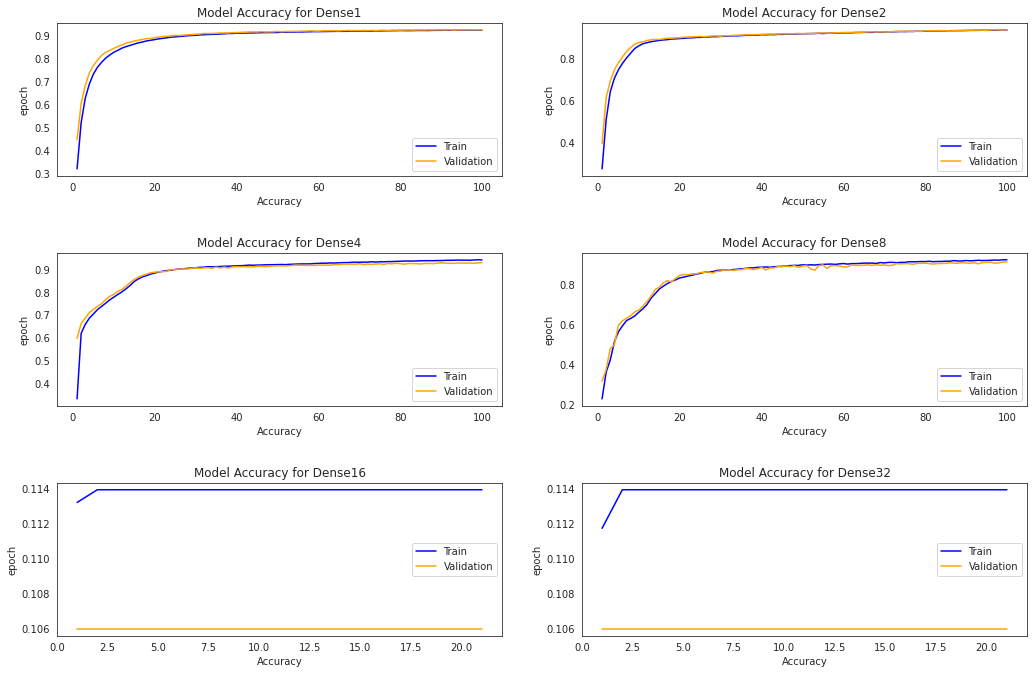

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
for i in range(len(depths)):
  length = len(history_dense[i].history['val_categorical_accuracy'])
  epochs_i = np.arange(length) + 1
  axs[int(i/2), i%2].plot(epochs_i, history_dense[i].history['categorical_accuracy'], color="blue", label="Train")
  axs[int(i/2), i%2].plot(epochs_i, history_dense[i].history['val_categorical_accuracy'], color="orange", label="Validation")
  axs[int(i/2), i%2].set_title('Model Accuracy for '+names[i])
  axs[int(i/2), i%2].set_ylabel('epoch')
  axs[int(i/2), i%2].set_xlabel('Accuracy')
  axs[int(i/2), i%2].legend()
fig.tight_layout(pad=3.0)

#### Depth of CNN layers

In this section, we test how the depth of our CNN network affects performance.

* We tried 1,2, and 3 convolutional layers and found that 2 or 3 layers yielded the best validation accuracy. However, the difference in accuracy between 2 and 3 layers was quite small.

* We did not try more than 3 layers due to a high computational runtime and noticing a diminishing return on increasing the number of layers further. Because of the increase in runtime for 3 layers compared to 2 and because 2 and 3 layers yielded similar accuracy, we decided that having 2 CNN layers was enough.

* With our criteria for early stopping, for each choice of the number of layers, the training process goes through about 17 epochs before terminating.

In [ ]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = tf.cast(x_train,dtype=tf.float32)/255.0, tf.cast(x_test,dtype=tf.float32)/255.0
#y_train, y_test = tf.one_hot(y_train, depth=10),tf.one_hot(y_test, depth=10)

#increases the dimension by 1
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [ ]:
#units
def cnn_model(layers):
  model = Sequential()
  model.add(Conv2D(layers[0],kernel_size=(5,5),activation='relu',input_shape=(28,28,1)))
  for unit in layers[1:]:
    model.add(Conv2D(unit,kernel_size=(5,5),activation='relu'))

  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(128,activation='relu'))
  model.add(Dense(10,activation='softmax'))

  return model


In [ ]:
depths = [1,2,3]
history_cnn = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 5 times of increase in valid_loss

#depths
for depth in depths:
  model = cnn_model([16]*depth)
  model.compile(optimizer = tf.keras.optimizers.Adam(), #'adam'
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  history_cnn.append(model.fit(x_train, y_train, batch_size = 128, epochs=50, validation_split = 0.2, callbacks = [early_stopping_cb],verbose = 0))




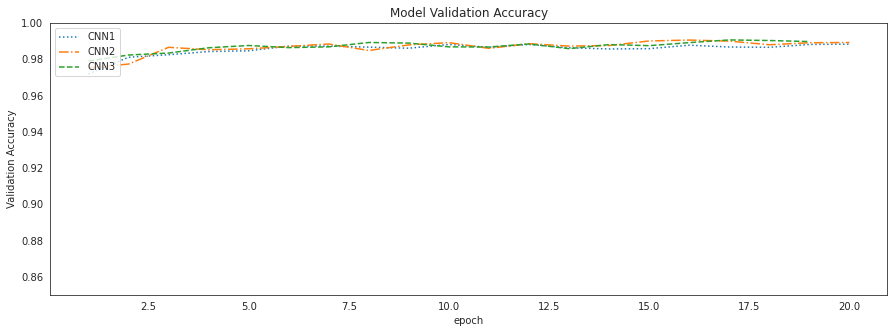

In [ ]:
# Plot validation accuracies 
depths = [1,2,3]
styles = [':','-.','--']
names = ['CNN'+str(depth) for depth in depths]

plt.figure(figsize=(15,5))
for i in range(len(depths)):
    length = len(history_cnn[i].history['val_categorical_accuracy'])
    epochs_i = np.arange(length) + 1
    plt.plot(epochs_i, history_cnn[i].history['val_categorical_accuracy'],linestyle=styles[i])
plt.title('Model Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.85,1.00])
plt.show()

In [ ]:
# Max validation accuracy per model for dense case

for i in range(len(history_cnn)):
  print('Max Validation Accuracy for '+ names[i] +' is {0:.4f}'.format(max(history_cnn[i].history['val_categorical_accuracy'])))


Max Validation Accuracy for CNN1 is 0.9883
Max Validation Accuracy for CNN2 is 0.9906
Max Validation Accuracy for CNN3 is 0.9907


#### Combinations of Fully Connected and CNN 

In this section, we investigated whether combinations of dense and convolutional layers yield better results when used together than individually. We've found that models with cnn_[cpcp]x[ff] and [cfpcfp]x[ff] structure worked well, achieving 98.1-99.7% validation accuracy.

In [ ]:
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
train_images, test_images = train_images / 255.0, test_images / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# helper function
def dense_model(layers):
  model = Sequential()
  model.add(Flatten(input_shape = (28,28)))

  for unit in layers:
    model.add(Dense(units = unit, activation = 'relu'))

  model.add(Dense(units = 10, activation = 'softmax'))
  return model

* cnn_[cpcp]x[ff] model

In [ ]:
# helper function
def cnn_cpcpff(cnn, layers):
  model = Sequential()
  # model.add(Flatten(input_shape = (28,28))),
  for i in cnn:
    model.add(Conv2D(filters=32,kernel_size=(3,3), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = None, use_bias = False))

    model.add(MaxPool2D(pool_size=(2,2), strides=None))

  model.add(Flatten())
  for unit in layers:
    model.add(Dense(units = 64, activation = 'relu'))

  model.add(Dense(units = 10, activation = 'softmax'))
  return model

In [ ]:
depths = [2,4]
units = [512,1024]
cnn = [2,4]
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5) #we accept 5 times of increase in valid_loss

history_all = []

for depth in depths:
    for u in units:
        for i in cnn:
            model = cnn_cpcpff([[i]], [u] * depth)
            model.compile(optimizer = tf.keras.optimizers.Adam(), #'adam'
                      loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
                      metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
            history_all.append(model.fit(train_images, train_labels, batch_size = 128, epochs=100, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0))

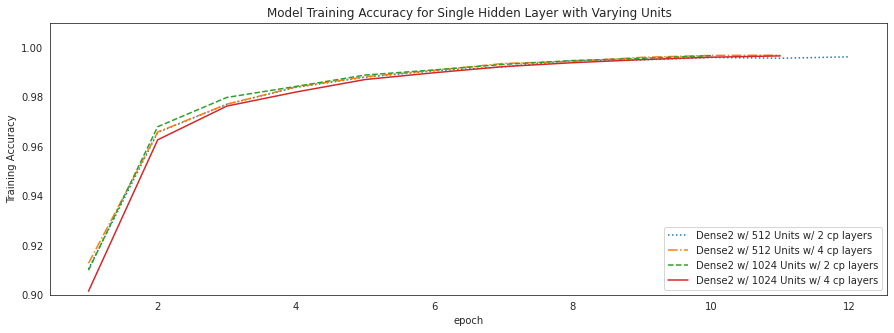

In [ ]:
import itertools
# Plot training accuracies 
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']
names_all = ['Dense' + str(combo[0]) + ' w/ ' + str(combo[1]) + ' Units' + ' w/ ' + str(combo[2]) + ' cp layers' for combo in itertools.product(depths, units, cnn)]
#epochs_i = np.arange(100) + 1
plt.figure(figsize=(15,5))
for i in range(len(depths)*len(units)):
    length = len(history_all[i].history['sparse_categorical_accuracy'])
    epochs_i = np.arange(length) + 1
    plt.plot(epochs_i, history_all[i].history['sparse_categorical_accuracy'],linestyle=styles[i])

plt.title('Model Training Accuracy for Single Hidden Layer with Varying Units')
plt.ylabel('Training Accuracy')
plt.xlabel('epoch')
plt.legend(names_all, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1.01])
plt.show()

In [ ]:
# Max train accuracy per model for both case

for i in range(len(history_all)):
  print('Max Train Accuracy for '+ names_all[i] +' is {0:.4f}'.format(max(history_all[i].history['sparse_categorical_accuracy'])))
  print('Final Validation Accuracy for '+ names_all[i] +
        ' is {0:.4f}'.format(history_all[i].history['sparse_categorical_accuracy'][len(history_all[i].history['sparse_categorical_accuracy'])-1]))
  print('')

Max Train Accuracy for Dense2 w/ 512 Units w/ 2 cp layers is 0.9963
Final Validation Accuracy for Dense2 w/ 512 Units w/ 2 cp layers is 0.9963

Max Train Accuracy for Dense2 w/ 512 Units w/ 4 cp layers is 0.9970
Final Validation Accuracy for Dense2 w/ 512 Units w/ 4 cp layers is 0.9970

Max Train Accuracy for Dense2 w/ 1024 Units w/ 2 cp layers is 0.9968
Final Validation Accuracy for Dense2 w/ 1024 Units w/ 2 cp layers is 0.9968

Max Train Accuracy for Dense2 w/ 1024 Units w/ 4 cp layers is 0.9967
Final Validation Accuracy for Dense2 w/ 1024 Units w/ 4 cp layers is 0.9967

Max Train Accuracy for Dense4 w/ 512 Units w/ 2 cp layers is 0.9955
Final Validation Accuracy for Dense4 w/ 512 Units w/ 2 cp layers is 0.9955

Max Train Accuracy for Dense4 w/ 512 Units w/ 4 cp layers is 0.9950
Final Validation Accuracy for Dense4 w/ 512 Units w/ 4 cp layers is 0.9950

Max Train Accuracy for Dense4 w/ 1024 Units w/ 2 cp layers is 0.9962
Final Validation Accuracy for Dense4 w/ 1024 Units w/ 2 cp laye

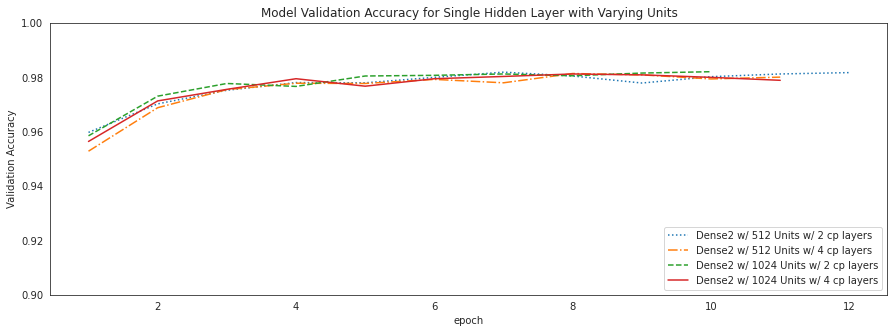

In [ ]:
# Plot validation accuracies 
plt.figure(figsize=(15,5))
for i in range(len(depths)*len(units)):
    length = len(history_all[i].history['val_sparse_categorical_accuracy'])
    epochs_i = np.arange(length) + 1
    plt.plot(epochs_i, history_all[i].history['val_sparse_categorical_accuracy'],linestyle=styles[i])
plt.title('Model Validation Accuracy for Single Hidden Layer with Varying Units')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_all, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

for i in range(len(history_all)):
  print('Max Validation Accuracy for '+ names_all[i] +' is {0:.4f}'.format(max(history_all[i].history['val_sparse_categorical_accuracy'])))
  print('Final Validation Accuracy for '+ names_all[i] +
        ' is {0:.4f}'.format(history_all[i].history['val_sparse_categorical_accuracy'][len(history_all[i].history['val_sparse_categorical_accuracy'])-1]))
  print('')

Max Validation Accuracy for Dense2 w/ 512 Units w/ 2 cp layers is 0.9819
Final Validation Accuracy for Dense2 w/ 512 Units w/ 2 cp layers is 0.9818

Max Validation Accuracy for Dense2 w/ 512 Units w/ 4 cp layers is 0.9814
Final Validation Accuracy for Dense2 w/ 512 Units w/ 4 cp layers is 0.9801

Max Validation Accuracy for Dense2 w/ 1024 Units w/ 2 cp layers is 0.9821
Final Validation Accuracy for Dense2 w/ 1024 Units w/ 2 cp layers is 0.9821

Max Validation Accuracy for Dense2 w/ 1024 Units w/ 4 cp layers is 0.9812
Final Validation Accuracy for Dense2 w/ 1024 Units w/ 4 cp layers is 0.9789

Max Validation Accuracy for Dense4 w/ 512 Units w/ 2 cp layers is 0.9809
Final Validation Accuracy for Dense4 w/ 512 Units w/ 2 cp layers is 0.9809

Max Validation Accuracy for Dense4 w/ 512 Units w/ 4 cp layers is 0.9810
Final Validation Accuracy for Dense4 w/ 512 Units w/ 4 cp layers is 0.9801

Max Validation Accuracy for Dense4 w/ 1024 Units w/ 2 cp layers is 0.9813
Final Validation Accuracy fo

* [cfpcfp]x[ff] model

In [ ]:

# helper function
def cnn_cfpcfpff(cnn):
  model = Sequential()
  for i in cnn:
      model.add(Conv2D(filters=16,kernel_size=(5,5), strides= 1,
                              padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                              activation = None, use_bias = False))
      model.add(Dense(units = 64, activation = 'relu'))
      model.add(MaxPool2D(pool_size=(2,2), strides=None))

  model.add(Flatten())
  model.add(Dense(units = 64, activation = 'relu'))
  model.add(Dense(units = 10, activation = 'softmax'))
  return model

In [ ]:
depths = [2,4]
cnn = [2,4]
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5) #we accept 5 times of increase in valid_loss

history_cfp = []

for depth in depths:
      for i in cnn:
          model = cnn_cfpcfpff([[i]])
          model.compile(optimizer = tf.keras.optimizers.Adam(), #'adam'
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
                    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
          history_cfp.append(model.fit(train_images, train_labels, batch_size = 128, epochs=100, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0))

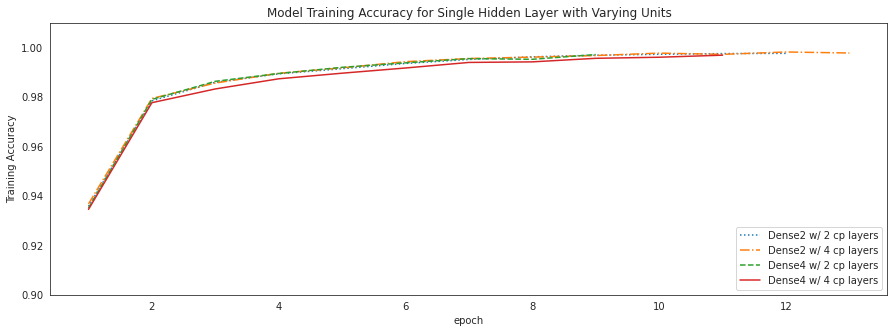

In [ ]:
import itertools
# Plot training accuracies 
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']
names_cfp = ['Dense' + str(combo[0]) + ' w/ ' + str(combo[1]) + ' cp layers' for combo in itertools.product(depths,  cnn)]
#epochs_i = np.arange(100) + 1
plt.figure(figsize=(15,5))
for i in range(len(depths)*len(cnn)):
    length = len(history_cfp[i].history['sparse_categorical_accuracy'])
    epochs_i = np.arange(length) + 1
    plt.plot(epochs_i, history_cfp[i].history['sparse_categorical_accuracy'],linestyle=styles[i])

plt.title('Model Training Accuracy for Single Hidden Layer with Varying Units')
plt.ylabel('Training Accuracy')
plt.xlabel('epoch')
plt.legend(names_cfp, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1.01])
plt.show()

In [ ]:
for i in range(len(history_cfp)):
  print('Max Train Accuracy for '+ names_cfp[i] +' is {0:.4f}'.format(max(history_cfp[i].history['sparse_categorical_accuracy'])))
  print('Final Validation Accuracy for '+ names_cfp[i] +
        ' is {0:.4f}'.format(history_cfp[i].history['sparse_categorical_accuracy'][len(history_cfp[i].history['sparse_categorical_accuracy'])-1]))
  print('')

Max Train Accuracy for Dense2 w/ 2 cp layers is 0.9977
Final Validation Accuracy for Dense2 w/ 2 cp layers is 0.9977

Max Train Accuracy for Dense2 w/ 4 cp layers is 0.9983
Final Validation Accuracy for Dense2 w/ 4 cp layers is 0.9979

Max Train Accuracy for Dense4 w/ 2 cp layers is 0.9972
Final Validation Accuracy for Dense4 w/ 2 cp layers is 0.9972

Max Train Accuracy for Dense4 w/ 4 cp layers is 0.9970
Final Validation Accuracy for Dense4 w/ 4 cp layers is 0.9970



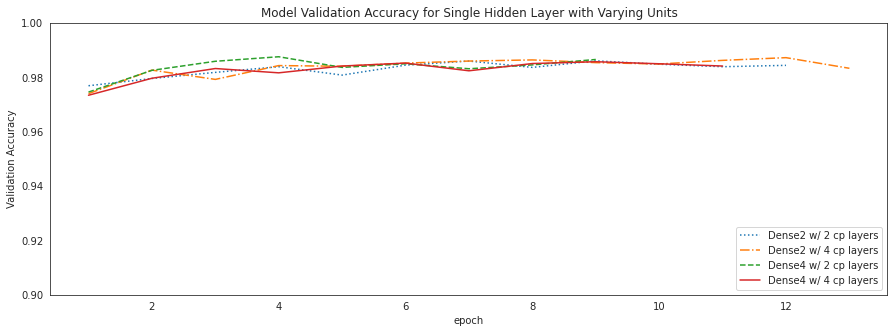

In [ ]:
# Plot validation accuracies 
plt.figure(figsize=(15,5))
for i in range(len(depths)*len(cnn)):
    length = len(history_cfp[i].history['val_sparse_categorical_accuracy'])
    epochs_i = np.arange(length) + 1
    plt.plot(epochs_i, history_cfp[i].history['val_sparse_categorical_accuracy'],linestyle=styles[i])
plt.title('Model Validation Accuracy for Single Hidden Layer with Varying Units')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_cfp, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

for i in range(len(history_cfp)):
  print('Max Validation Accuracy for '+ names_cfp[i] +' is {0:.4f}'.format(max(history_cfp[i].history['val_sparse_categorical_accuracy'])))
  print('Final Validation Accuracy for '+ names_cfp[i] +
        ' is {0:.4f}'.format(history_cfp[i].history['val_sparse_categorical_accuracy'][len(history_cfp[i].history['val_sparse_categorical_accuracy'])-1]))
  print('')

Max Validation Accuracy for Dense2 w/ 2 cp layers is 0.9861
Final Validation Accuracy for Dense2 w/ 2 cp layers is 0.9844

Max Validation Accuracy for Dense2 w/ 4 cp layers is 0.9872
Final Validation Accuracy for Dense2 w/ 4 cp layers is 0.9833

Max Validation Accuracy for Dense4 w/ 2 cp layers is 0.9876
Final Validation Accuracy for Dense4 w/ 2 cp layers is 0.9866

Max Validation Accuracy for Dense4 w/ 4 cp layers is 0.9858
Final Validation Accuracy for Dense4 w/ 4 cp layers is 0.9842



#### Batch Normalization & Dropout Layer

We included Batch Normalization and Dropout Layer in the architecture section because we wanted to make sure we get the best possible combination of layers before we get to the regularization section. We have consulted the professor and he approved it. We only included the best output after many trials & errors for the position of Batch Normalization layer and Dropout Layer.

* Batch Normalization

In [ ]:
# Max Validation Accuracy for Dense2 w/ 512 Units w/ 2 cp layers is 0.9825
# Final Validation Accuracy for Dense2 w/ 512 Units w/ 2 cp layers is 0.9825

def cnn_cfpcfpfff():
  model = Sequential()
  # model.add(Flatten(input_shape = (28,28))),
  model.add(Conv2D(filters=32,kernel_size=(3,3), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = None, use_bias = False))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2), strides=None))
  model.add(Conv2D(filters=32,kernel_size=(3,3), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = None, use_bias = False))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2), strides=None))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units = 64, activation = 'relu'))
  model.add(Dense(units = 64, activation = 'relu'))
  model.add(Dense(units = 10, activation = 'softmax'))
  return model

In [ ]:
history_cfpcfpfff = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5) #we accept 5 times of increase in valid_loss

model = cnn_cfpcfpfff()
model.compile(optimizer = tf.keras.optimizers.Adam(), #'adam'
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cfpcfpfff = model.fit(train_images, train_labels, batch_size = 128, epochs=100, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

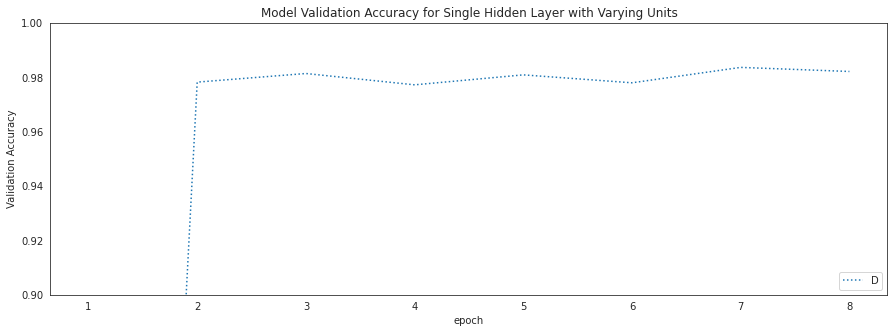

In [ ]:
# Plot validation accuracies 
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']

names_cfpcfpfff = 'Dense 2 w/ 512 units w/ 2 cp layers w/ BatchNormalization'

plt.figure(figsize=(15,5))

length = len(history_cfpcfpfff.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cfpcfpfff.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for Single Hidden Layer with Varying Units')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_cfpcfpfff, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names_cfpcfpfff +' is {0:.4f}'.format(max(history_cfpcfpfff.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names_cfpcfpfff +
      ' is {0:.4f}'.format(history_cfpcfpfff.history['val_sparse_categorical_accuracy'][len(history_cfpcfpfff.history['val_sparse_categorical_accuracy'])-1]))
print('')

Max Validation Accuracy for Dense 2 w/ 512 units w/ 2 cp layers w/ BatchNormalization is 0.9837
Final Validation Accuracy for Dense 2 w/ 512 units w/ 2 cp layers w/ BatchNormalization is 0.9822



* Dropout Layer

In [ ]:
# Max Validation Accuracy for Dense2 w/ 512 Units w/ 2 cp layers is 0.9825
# Final Validation Accuracy for Dense2 w/ 512 Units w/ 2 cp layers is 0.9825

def cnn_cpcpdfff():
  model = Sequential()
  # model.add(Flatten(input_shape = (28,28))),
  model.add(Conv2D(filters=32,kernel_size=(3,3), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = None, use_bias = False, input_shape = (28,28,1)))
  # model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2), strides=None))
  model.add(Conv2D(filters=32,kernel_size=(3,3), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = None, use_bias = False))
  # model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2), strides=None))

  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(units = 64, activation = 'relu'))
  model.add(Dense(units = 64, activation = 'relu'))
  
  model.add(Dense(units = 10, activation = 'softmax'))
  return model

In [ ]:
history_cpcpdfff = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5) #we accept 5 times of increase in valid_loss

cpcpdfff = cnn_cpcpdfff()
cpcpdfff.compile(optimizer = tf.keras.optimizers.Adam(), #'adam'
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cpcpdfff = model.fit(train_images, train_labels, batch_size = 128, epochs=100, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

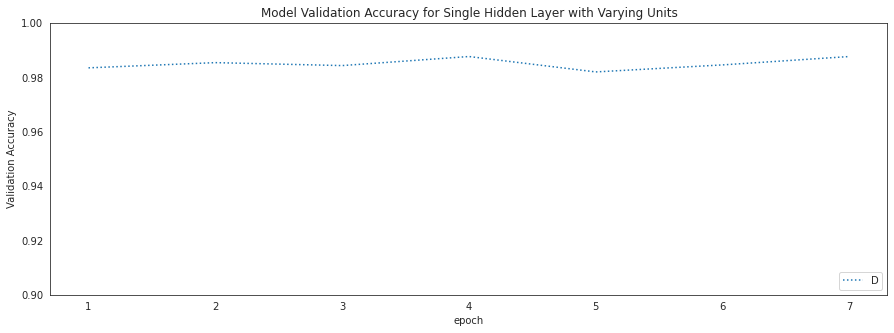

In [ ]:
# Plot validation accuracies 
names_cpcpdfff = 'Dense 2 w/ 512 units w/ 2 cp layers w/ dropout'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cpcpdfff.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cpcpdfff.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for Single Hidden Layer with Varying Units')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_cpcpdfff, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names_cpcpdfff +' is {0:.4f}'.format(max(history_cpcpdfff.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names_cpcpdfff +
      ' is {0:.4f}'.format(history_cpcpdfff.history['val_sparse_categorical_accuracy'][len(history_cpcpdfff.history['val_sparse_categorical_accuracy'])-1]))
print('')

Max Validation Accuracy for Dense 2 w/ 512 units w/ 2 cp layers w/ dropout is 0.9877
Final Validation Accuracy for Dense 2 w/ 512 units w/ 2 cp layers w/ dropout is 0.9877



#### Max Pooling vs Average Pooling

In this section, we see if we should use max pooling or average pooling.
  * We tested this on an architecture that had a single convolutional layer with 16 filters and a 5x5 kernel size.
  * We found that max pooling yielded slightly better performance than average pooling.

In [ ]:
def cnn_kernel_pooling(p):
  #one layer
  model = Sequential()
  model.add(Conv2D(16,kernel_size=(5,5),activation='relu',input_shape=(28,28,1)))
  if p=='MaxPooling2D':
    model.add(MaxPooling2D(pool_size=(2,2)))
  else:
    model.add(AveragePooling2D(pool_size=(2,2)))

  #model.add(p(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(128,activation='relu'))
  model.add(Dense(10,activation='softmax'))

  return model

In [ ]:
p_list = ['MaxPooling2D','AveragePooling2D']
history_p = []

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 5 times of increase in valid_loss

for p in p_list:
  model = cnn_kernel_pooling(p)
  model.compile(optimizer = tf.keras.optimizers.Adam(), #'adam'
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  history_p.append(model.fit(x_train, y_train, batch_size = 128, epochs=100, validation_split = 0.2, callbacks = [early_stopping_cb],verbose = 0))



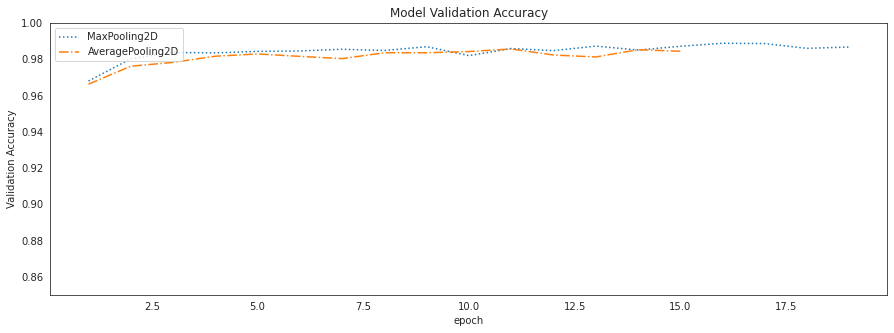

In [ ]:
# Plot validation accuracies 
names=p_list
plt.figure(figsize=(15,5))
for i in range(len(p_list)):
    length = len(history_p[i].history['val_sparse_categorical_accuracy'])
    epochs_i = np.arange(length) + 1
    plt.plot(epochs_i, history_p[i].history['val_sparse_categorical_accuracy'],linestyle=styles[i])
plt.title('Model Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.85,1])
plt.show()

In [ ]:
# Max validation accuracy per model for dense case

for i in range(len(history_p)):
  print('Max Validation Accuracy for '+ names[i] +' is {0:.4f}'.format(max(history_p[i].history['val_sparse_categorical_accuracy'])))


Max Validation Accuracy for MaxPooling2D is 0.9888
Max Validation Accuracy for AveragePooling2D is 0.9857


#### Zero Padding

In this section, we see if zero padding affects performance.
  * The two paddings options are 'same' which adds zeros around edges while keeping the dimensions the same, and 'valid' which reduces the dimension and does not do padding. By default keras uses 'valid'.
  * We tested this on an architecture that had a single convolutional layer with 16 filters and a 5x5 kernel size.
  * We found that 'same' padding yielded a higher validation accuracy than 'valid'/

In [ ]:
#valid- no padding, dimensions reduced
#same- zeros around edges, dimensions remain same
def cnn_kernel_padding(p):
  #one layer
  model = Sequential()
  if p=='same':
    model.add(Conv2D(16,kernel_size=(5,5),activation='relu',input_shape=(28,28,1),padding='same'))
  else:
    model.add(Conv2D(16,kernel_size=(5,5),activation='relu',input_shape=(28,28,1)))

  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(128,activation='relu'))
  model.add(Dense(10,activation='softmax'))

  return model

In [ ]:
pa_list = ['same','valid']
history_pa = []

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 5 times of increase in valid_loss

for pa in pa_list:
  model = cnn_kernel_padding(pa)
  model.compile(optimizer = tf.keras.optimizers.Adam(), #'adam'
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  history_pa.append(model.fit(x_train, y_train, batch_size = 128, epochs=100, validation_split = 0.2, callbacks = [early_stopping_cb],verbose = 0))



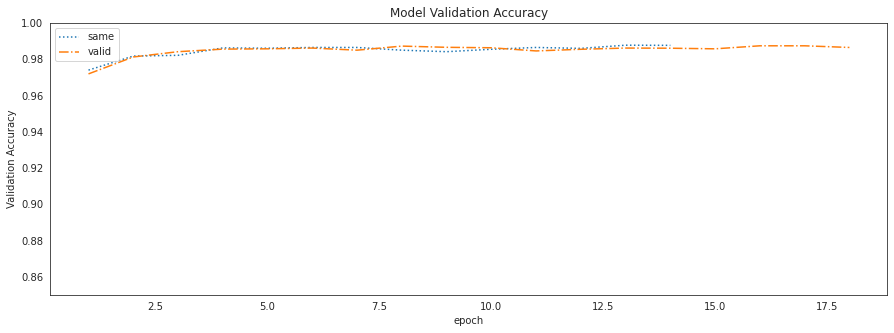

In [ ]:
# Plot validation accuracies 
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']
names = [str(p) for p in pa_list]

plt.figure(figsize=(15,5))
for i in range(len(pa_list)):
    length = len(history_pa[i].history['val_categorical_accuracy'])
    epochs_i = np.arange(length) + 1
    plt.plot(epochs_i, history_pa[i].history['val_categorical_accuracy'],linestyle=styles[i])
plt.title('Model Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.85,1])
plt.show()

In [ ]:
# Max validation accuracy per model for dense case

for i in range(len(history_pa)):
  print('Max Validation Accuracy for '+ names[i] +' is {0:.4f}'.format(max(history_pa[i].history['val_categorical_accuracy'])))


Max Validation Accuracy for same is 0.9877
Max Validation Accuracy for valid is 0.9874


### Model 1 (cpcpdfff)

Our empirical results above demonstrated that 2-3 convolutional layers, or 2-8 dense layers yielded the best validation accuracy. Thus for Model 1, we led with 2 convolutional layers, each followed by a max pooling layer, and then a dropout and 2 dense layers (excluding output). In total, there are 4 Conv/Dense layers in this architecture. We found that this combination and ordering yielded one of the best performances of 99.14% validation accuracy.

### Model 2 (cfpcfpdff)

This was another high performing model which yielded 98.48% validation accuracy. This model is similar to Model 1 with the modification that our convolutional layers are followed by both a dense and a max pooling layer, as opposed to just a max pooling layer in Model 1, and there is one fewer dense layer at the end. In total, there are 5 Conv/Dense layers in this architecture, matching our earlier experimentation on the optimal number of layers in a model.

### Model 3 (ccpdnff)

For our last model, we decided to see the effects of including batch normalization before the regularization step so that the hyperparameters are tuned in the optimization step while taking the batch normalization layer into account. This allowed us to  study  the  effects  of  tuning hyperparameters while taking the batch normalization into account versus tuning without it. 

## Optimization

In this section, we optimize hyperparameters including number of filters in the convolutional layers, kernel size, activation function, optimizer, and learning rate.

The optimizers we considered were Adam, Nadam, RMSprop, and SGD. (add optimizer explanations)

The hyperparameters other than choice of optimizer do not have much conceptual justification and are more heuristic based, so we decided that we could pick them through a grid search. To achieve this, we used Hyperband which is a multi armed bandit based grid search method that explores a given grid and exploits combinations that yield a higher accuracy. 

Note that Hyperband and Keras Tuner display the best parameters so far while they are running but do not display the overall best parameters after they finish running. Hence, we observed them as they ran and recorded the parameters. This means that the optimal parameters unfortunately do not show up in the output, but if you run the cells again you will hopefully obtain parameters that yield a similar validation accuracy as the ones which we used. Your parameters might not be the same as the ones we used due to the randomness involved in the process.

In [ ]:
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
train_images, test_images = train_images / 255.0, test_images / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

### Model 1 (cpcpdfff)

Here we run hyperband for model 1 over the four different optimizers. We tune for number of filters, kernel size, activation function, max pooling size, dropout rate, and number of units in the fully connected dense layer. We go through this process since these parameters are more heuristic based and would require more trial and error rather than intuition to determine the best choices.

Overall, we found that the tuned parameters for RMSProp typically yield the highest validation accuracy. After tuning for the number of epochs and batch size, this model achieved validation accuracy of 99.31%.

#### Adam

In [ ]:
def build_model_1_adam(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('dense_activation', values = ['relu'], default = None), use_bias = False))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))
  model.add(Conv2D(filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('dense_activation', values = ['relu'], default = None), use_bias = False))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Flatten())
  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  
  model.add(Dense(units = 10, activation = 'softmax'))
  model.compile(optimizer = Adam(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])), 
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
tuner_adam_1 = kt.Hyperband(build_model_1_adam,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'mnist_Adam_1')

In [ ]:
tuner_adam_1.search(train_images, train_labels, epochs= 20, validation_split = 0.2, callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 00m 56s]
val_sparse_categorical_accuracy: 0.9866666793823242

Best val_sparse_categorical_accuracy So Far: 0.9918333292007446
Total elapsed time: 00h 11m 05s
INFO:tensorflow:Oracle triggered exit


#### Nadam

In [ ]:
def build_model_1_nadam(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('dense_activation', values = ['relu'], default = None), use_bias = False))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))
  model.add(Conv2D(filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('dense_activation', values = ['relu'], default = None), use_bias = False))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Flatten())
  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  
  model.add(Dense(units = 10, activation = 'softmax'))
  model.compile(optimizer = Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])), #Nadam
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
tuner_nadam_1 = kt.Hyperband(build_model_1_nadam,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'mnist_nadam_1')

In [ ]:
tuner_nadam_1.search(train_images, train_labels, epochs= 20, validation_split = 0.2, callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 00m 59s]
val_sparse_categorical_accuracy: 0.984000027179718

Best val_sparse_categorical_accuracy So Far: 0.9908333420753479
Total elapsed time: 00h 13m 08s
INFO:tensorflow:Oracle triggered exit


#### RMSProp

In [ ]:
def build_model_1_rms(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('dense_activation', values = ['relu'], default = None), use_bias = False))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))
  model.add(Conv2D(filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('dense_activation', values = ['relu'], default = None), use_bias = False))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Flatten())
  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  
  model.add(Dense(units = 10, activation = 'softmax'))
  model.compile(optimizer = RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])), #RMSprop
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
tuner_rms_1 = kt.Hyperband(build_model_1_rms,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'mnist_rms_1')

In [ ]:
tuner_rms_1.search(train_images, train_labels, epochs= 20, validation_split = 0.2, callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 00m 58s]
val_sparse_categorical_accuracy: 0.9913333058357239

Best val_sparse_categorical_accuracy So Far: 0.9925000071525574
Total elapsed time: 00h 12m 18s
INFO:tensorflow:Oracle triggered exit


#### SGD

In [ ]:
def build_model_1_sgd(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('dense_activation', values = ['relu'], default = None), use_bias = False))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))
  model.add(Conv2D(filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('dense_activation', values = ['relu'], default = None), use_bias = False))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Flatten())
  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  
  model.add(Dense(units = 10, activation = 'softmax'))
  model.compile(optimizer = SGD(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
tuner_sgd_1 = kt.Hyperband(build_model_1_sgd,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'mnist_sgd_1')

In [ ]:
tuner_sgd_1.search(train_images, train_labels, epochs= 20, validation_split = 0.2, callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 00m 43s]
val_sparse_categorical_accuracy: 0.9900000095367432

Best val_sparse_categorical_accuracy So Far: 0.9900000095367432
Total elapsed time: 00h 09m 36s
INFO:tensorflow:Oracle triggered exit


#### Tune for Number of Epochs and Batch Size

Since RMSProp gave us the highest validation accuracy, we will tune it further by looking for the optimal number of epochs and optimal batch size.

In [ ]:
class MyTuner(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 256, step=32)
    kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 30)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

tuner_rms_1_x = MyTuner(build_model_1_rms,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_trials = 30,
                    #  factor = 3,
                     directory = 'my_dir',
                     project_name = 'mnist_rms_1_x')
# Don't pass epochs or batch_size here, let the Tuner tune them.
tuner_rms_1_x.search(train_images,train_labels, validation_split = 0.2,callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 02m 09s]
val_sparse_categorical_accuracy: 0.9920833110809326

Best val_sparse_categorical_accuracy So Far: 0.9930833578109741
Total elapsed time: 00h 37m 12s
INFO:tensorflow:Oracle triggered exit


### Model 2 (cfpcfpdff)

Here we run hyperband for model 2 over the four different optimizers. We tune for number of filters, kernel size, activation function, max pooling size, dropout rate, and number of units in the fully connected dense layer. We go through this process since these parameters are more heuristic based and would require more trial and error rather than intuition to determine the best choices.

Overall, we found that the tuned parameters for RMSProp typically yield the highest validation accuracy. After tuning for the number of epochs and batch size, this model achieved validation accuracy of 99.14%.

#### Adam

In [ ]:
def build_model_2_adam(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh'], default = None), use_bias = False))
  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))
  model.add(Conv2D(filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh'], default = None), use_bias = False))
  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Flatten())

  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))
  
  model.add(Dense(units = 10, activation = 'softmax'))
  model.compile(optimizer = Adam(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])), 
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
tuner_adam_2 = kt.Hyperband(build_model_2_adam,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'mnist_Adam_2')

In [ ]:
tuner_adam_2.search(train_images,train_labels,epochs= 20, validation_split = 0.2,callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 00m 57s]
val_sparse_categorical_accuracy: 0.8727499842643738

Best val_sparse_categorical_accuracy So Far: 0.9914166927337646
Total elapsed time: 00h 12m 02s
INFO:tensorflow:Oracle triggered exit


#### Nadam

In [ ]:
def build_model_2_nadam(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh'], default = None), use_bias = False))
  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))
  model.add(Conv2D(filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh'], default = None), use_bias = False))
  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Flatten())

  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))
  
  model.add(Dense(units = 10, activation = 'softmax'))
  model.compile(optimizer = Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])), #Nadam
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
tuner_nadam_2 = kt.Hyperband(build_model_2_nadam,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dirb',
                     project_name = 'mnist_nadam_2')

In [ ]:
tuner_nadam_2.search(train_images,train_labels,epochs= 20, validation_split = 0.2,callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 01m 15s]
val_sparse_categorical_accuracy: 0.9884999990463257

Best val_sparse_categorical_accuracy So Far: 0.9912499785423279
Total elapsed time: 00h 15m 55s
INFO:tensorflow:Oracle triggered exit


#### RMSProp

In [ ]:
def build_model_2_rms(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh'], default = None), use_bias = False))
  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))
  model.add(Conv2D(filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh'], default = None), use_bias = False))
  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Flatten())

  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))
  
  model.add(Dense(units = 10, activation = 'softmax'))
  model.compile(optimizer = RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])), #RMSprop
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
tuner_rms_2 = kt.Hyperband(build_model_2_rms,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'mnist_rms_2')

In [ ]:
tuner_rms_2.search(train_images, train_labels,epochs= 20, validation_split = 0.2,callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 01m 31s]
val_sparse_categorical_accuracy: 0.9877499938011169

Best val_sparse_categorical_accuracy So Far: 0.9915833473205566
Total elapsed time: 00h 17m 10s
INFO:tensorflow:Oracle triggered exit


#### SGD

In [ ]:
def build_model_2_sgd(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh'], default = None), use_bias = False))
  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))
  model.add(Conv2D(filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh'], default = None), use_bias = False))
  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Flatten())

  model.add(Dense(units=hp.Int('units', 8, 64, 4, default=8), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))
  
  model.add(Dense(units = 10, activation = 'softmax'))
  model.compile(optimizer = SGD(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
tuner_sgd_2 = kt.Hyperband(build_model_2_sgd,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'mnist_sgd_2')

In [ ]:
tuner_sgd_2.search(train_images,train_labels,epochs= 20, validation_split = 0.2,callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 01m 00s]
val_sparse_categorical_accuracy: 0.10599999874830246

Best val_sparse_categorical_accuracy So Far: 0.9910833239555359
Total elapsed time: 00h 11m 32s
INFO:tensorflow:Oracle triggered exit


#### Tune for Number of Epochs and Batch Size

Since RMSProp gave us the highest validation accuracy, we will tune it further by looking for the optimal number of epochs and optimal batch size.

In [ ]:
class MyTuner(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 256, step=32)
    kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 30)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

tuner_rms_2_x = MyTuner(build_model_2_rms,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_trials = 30,
                    #  factor = 3,
                     directory = 'my_dir',
                     project_name = 'mnist_rms_2_x')
# Don't pass epochs or batch_size here, let the Tuner tune them.
tuner_rms_2_x.search(train_images,train_labels, validation_split = 0.2,callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 00m 53s]
val_sparse_categorical_accuracy: 0.9904166460037231

Best val_sparse_categorical_accuracy So Far: 0.9928333163261414
Total elapsed time: 00h 29m 35s
INFO:tensorflow:Oracle triggered exit


### Model 3 (ccpdnff)

Here we run hyperband for model 3 over the four different optimizers. We tune for number of filters, kernel size, activation function, max pooling size, dropout rate, and number of units in the fully connected dense layer. We go through this process since these parameters are more heuristic based and would require more trial and error rather than intuition to determine the best choices. 

Overall, we found that the tuned parameters for SGD typically yield the highest validation accuracy.

#### Adam

In [ ]:
def build_model_3_adam(hp):
  # create model
  model = Sequential()

  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh', 'sigmoid'], default = None), use_bias = False))
  model.add(Conv2D(filters=hp.Int('conv_2_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_2_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh', 'sigmoid'], default = None), use_bias = False))
  
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=hp.Int('units',64,128, default=128), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))  
  model.add(Dense(10, activation='softmax'))

  # Compile model
  model.compile(optimizer = Adam(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])), #'adam'
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  
  return model

In [ ]:
tuner_adam_3 = kt.Hyperband(build_model_3_adam,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'mnist_Adam')

In [ ]:

tuner_adam_3.search(train_images,train_labels,epochs= 10, validation_split = 0.2)

Trial 30 Complete [00h 00m 54s]
val_sparse_categorical_accuracy: 0.9410833120346069

Best val_sparse_categorical_accuracy So Far: 0.9910833239555359
Total elapsed time: 00h 10m 55s
INFO:tensorflow:Oracle triggered exit


#### Nadam

In [ ]:
def build_model_3_nadam(hp):
  # create model
  model = Sequential()

  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh', 'sigmoid'], default = None), use_bias = False))
  model.add(Conv2D(filters=hp.Int('conv_2_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_2_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh', 'sigmoid'], default = None), use_bias = False))
  
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))

  model.add(Flatten())
  model.add(BatchNormalization())

  model.add(Dense(units=hp.Int('units',64,128, default=128), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))  
  model.add(Dense(10, activation='softmax'))

  # Compile model
  model.compile(optimizer = Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  
  return model

In [ ]:
tuner_nadam_3 = kt.Hyperband(build_model_3_nadam,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'mnist_nadam')

In [ ]:
tuner_nadam_3.search(train_images,train_labels,epochs= 10, validation_split = 0.2)

Trial 30 Complete [00h 01m 05s]
val_sparse_categorical_accuracy: 0.9800000190734863

Best val_sparse_categorical_accuracy So Far: 0.9900833368301392
Total elapsed time: 00h 14m 18s
INFO:tensorflow:Oracle triggered exit


#### RMSprop

In [ ]:
def build_model_3_rmsprop(hp):
  # create model
  model = Sequential()

  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh', 'sigmoid'], default = None), use_bias = False))
  model.add(Conv2D(filters=hp.Int('conv_2_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_2_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh', 'sigmoid'], default = None), use_bias = False))
  
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=hp.Int('units',64,128, default=128), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))  
  model.add(Dense(10, activation='softmax'))

  # Compile model
  model.compile(optimizer = RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  
  return model

In [ ]:
tuner_rms_3 = kt.Hyperband(build_model_3_rmsprop,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'mnist_rmsprop')

In [ ]:
tuner_rms_3.search(train_images,train_labels,epochs= 10, validation_split = 0.2)

Trial 30 Complete [00h 00m 54s]
val_sparse_categorical_accuracy: 0.9585000276565552

Best val_sparse_categorical_accuracy So Far: 0.9911666512489319
Total elapsed time: 00h 11m 55s
INFO:tensorflow:Oracle triggered exit


#### SGD

In [ ]:
def build_model_3_sgd(hp):
  # create model
  model = Sequential()

  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh', 'sigmoid'], default = None), use_bias = False))
  model.add(Conv2D(filters=hp.Int('conv_2_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_2_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh', 'sigmoid'], default = None), use_bias = False))
  
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))

  model.add(Flatten())
  model.add(BatchNormalization())

  model.add(Dense(units=hp.Int('units',64,128, default=128), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))  
  model.add(Dense(10, activation='softmax'))

  # Compile model
  model.compile(optimizer = SGD(hp.Choice('learning_rate', values=[1e-1,1e-2,1e-3])),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  
  return model

In [ ]:
tuner_sgd_3 = kt.Hyperband(build_model_3_sgd,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'mnist_SGD')

In [ ]:
tuner_sgd_3.search(train_images,train_labels,epochs= 10, validation_split = 0.2)

Trial 30 Complete [00h 00m 50s]
val_sparse_categorical_accuracy: 0.9913333058357239

Best val_sparse_categorical_accuracy So Far: 0.9919166564941406
Total elapsed time: 00h 10m 25s
INFO:tensorflow:Oracle triggered exit


#### Tune for Number of Epochs and Batch Size

Since SGD gave us the highest validation accuracy, we will tune it further by looking for the optimal number of epochs and optimal batch size.

In [ ]:
import IPython

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
class MyTuner(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 256, step=32)
    kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 30)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

tuner_sgd_3_x = MyTuner(build_model_3_sgd,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_trials = 30,
                    #  factor = 3,
                     directory = 'my_dir',
                     project_name = 'mnist2')
# Don't pass epochs or batch_size here, let the Tuner tune them.
# tuner_nadam.search(train_images,train_labels,epochs= 10, validation_split = 0.2,callbacks = [ClearTrainingOutput()])
tuner_sgd_3_x.search(train_images,train_labels, validation_split = 0.2,callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 00m 38s]
val_sparse_categorical_accuracy: 0.9904166460037231

Best val_sparse_categorical_accuracy So Far: 0.9937499761581421
Total elapsed time: 00h 45m 57s
INFO:tensorflow:Oracle triggered exit


## Initialization

In [ ]:
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
train_images, test_images = train_images / 255.0, test_images / 255.0


11493376/11490434 [==============================] - 0s 0us/step


### Model 1 (cpcpdfff)

For the cpcpdfff model, we found that the best choices of initializers were variance scaling with tanh activation, He initialization with Relu activation, and Xavier normal initialization with Relu activation.

In particular, xavier normal initialization with Relu activation yielded the highest validation accuracy.

In [ ]:
val_acc_1 = {}

In [ ]:
def cpcpdfff_rms():
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=96,
                   kernel_size= 5, strides= 1,
                            padding= 'same', 
                            activation = 'relu', use_bias = False))
  model.add(MaxPooling2D(pool_size=2, strides=None))
  model.add(Conv2D(input_shape = (28,28,1),filters=96,
                   kernel_size= 5, strides= 1,
                            padding= 'same', 
                            activation = 'relu', use_bias = False))
  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(Dense(units=64, 
                  activation='tanh'))
  model.add(Dense(units=64, 
                  activation='tanh'))
  
  model.add(Dense(units = 10, activation = 'softmax'))
  
  return model

In [ ]:
def cpcpdfff_rms_activation(init_fn, activation_fn):
  # create model
  model = Sequential()

  model.add(Conv2D(filters=32,kernel_size=(3,3), strides= 1,
                              padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                              kernel_initializer=init_fn, activation = activation_fn, use_bias=False))
  model.add(MaxPooling2D(pool_size=(2,2), strides=None))
  model.add(Conv2D(filters=32,kernel_size=(3,3), strides= 1,
                              padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                              kernel_initializer=init_fn, activation = activation_fn, use_bias=False))
  model.add(MaxPooling2D(pool_size=(2,2), strides=None))

  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(units = 64, kernel_initializer=init_fn, activation = activation_fn))
  model.add(Dense(units = 64, kernel_initializer=init_fn, activation = activation_fn))

  model.add(Dense(units = 10, kernel_initializer=init_fn, activation = 'softmax'))
  
  return model

#### Default (Glorot uniform)

In [ ]:
history_cpcpdfff_default = []

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model = cpcpdfff_rms()
model.compile(optimizer = RMSprop(learning_rate=1e-4), 
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cpcpdfff_default = model.fit(train_images, train_labels, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

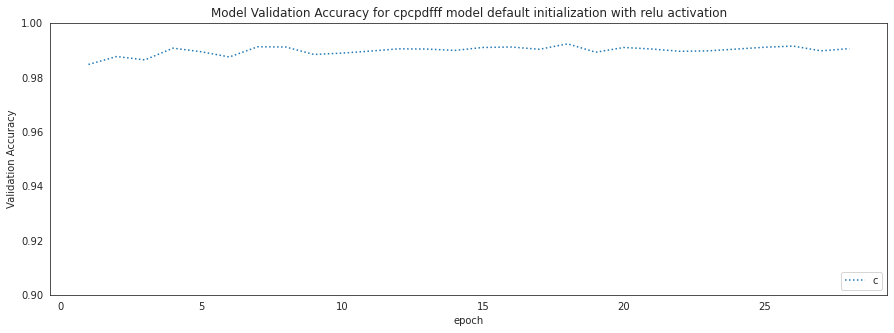

In [ ]:
# Plot validation accuracies 
names = 'cpcpdfff model default initialization'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cpcpdfff_default.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cpcpdfff_default.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for cpcpdfff model default initialization with relu activation')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:

print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_cpcpdfff_default.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_cpcpdfff_default.history['val_sparse_categorical_accuracy'][len(history_cpcpdfff_default.history['val_sparse_categorical_accuracy'])-1]))
print('')
val_acc_1['default initialization']=history_cpcpdfff_default.history['val_sparse_categorical_accuracy'][len(history_cpcpdfff_default.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for cpcpdfff model default initialization is 0.9923
Final Validation Accuracy for cpcpdfff model default initialization is 0.9906



#### Variance scaling initialization with tanh activation

In [ ]:
variance_scaling_initializer = tf.keras.initializers.VarianceScaling(
    scale=1.0, mode="fan_in", distribution="truncated_normal", seed=None
)
history_cpcpdfff_variance_scaling_model_1 = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model = cpcpdfff_rms_activation(variance_scaling_initializer, 'tanh')
model.compile(optimizer = RMSprop(learning_rate=1e-4), 
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cpcpdfff_variance_scaling_model_1 = model.fit(train_images, train_labels, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

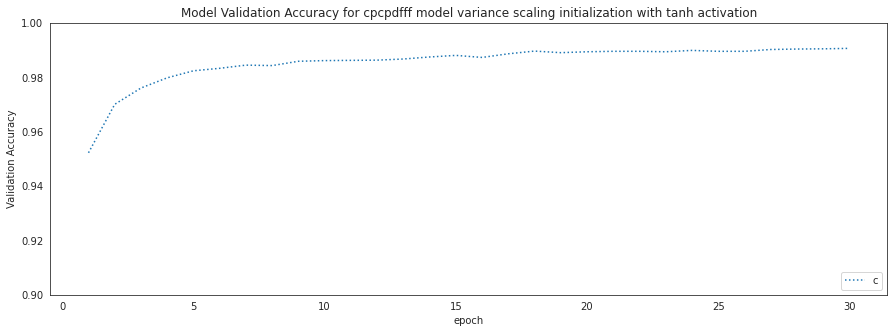

In [ ]:
# Plot validation accuracies 
names = 'cpcpdfff model variance scaling initialization with tanh activation'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cpcpdfff_variance_scaling_model_1.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cpcpdfff_variance_scaling_model_1.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for cpcpdfff model variance scaling initialization with tanh activation')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_cpcpdfff_variance_scaling_model_1.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_cpcpdfff_variance_scaling_model_1.history['val_sparse_categorical_accuracy'][len(history_cpcpdfff_variance_scaling_model_1.history['val_sparse_categorical_accuracy'])-1]))
print('')
val_acc_1['variance scaling with tanh']=history_cpcpdfff_variance_scaling_model_1.history['val_sparse_categorical_accuracy'][len(history_cpcpdfff_variance_scaling_model_1.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for cpcpdfff model variance scaling initialization with tanh activation is 0.9907
Final Validation Accuracy for cpcpdfff model variance scaling initialization with tanh activation is 0.9907



#### He initialization with ReLU activation

In [ ]:
he_initializer = tf.keras.initializers.HeNormal()
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model = cpcpdfff_rms_activation(he_initializer, 'relu')
model.compile(optimizer = RMSprop(learning_rate=1e-4), 
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cpcpdfff_he_model_1 = model.fit(train_images, train_labels, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

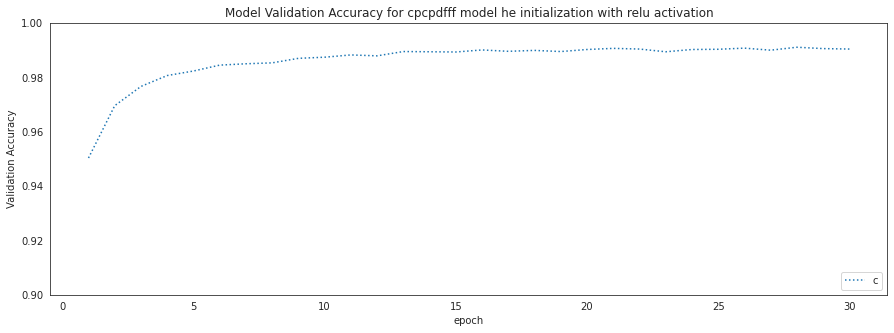

In [ ]:
# Plot validation accuracies 
names = 'cpcpdfff model He initialization with relu activation'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cpcpdfff_he_model_1.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cpcpdfff_he_model_1.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for cpcpdfff model he initialization with relu activation')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_cpcpdfff_he_model_1.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_cpcpdfff_he_model_1.history['val_sparse_categorical_accuracy'][len(history_cpcpdfff_he_model_1.history['val_sparse_categorical_accuracy'])-1]))
print('')
val_acc_1['he with relu']=history_cpcpdfff_he_model_1.history['val_sparse_categorical_accuracy'][len(history_cpcpdfff_he_model_1.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for cpcpdfff model He initialization with relu activation is 0.9911
Final Validation Accuracy for cpcpdfff model He initialization with relu activation is 0.9904



#### Xavier normal initialization with ReLU activation

In [ ]:
xavier_initializer = tf.keras.initializers.GlorotNormal()
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model = cpcpdfff_rms_activation(xavier_initializer, 'relu')
model.compile(optimizer = RMSprop(learning_rate=1e-4), 
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cpcpdfff_xavier_model_1 = model.fit(train_images, train_labels, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

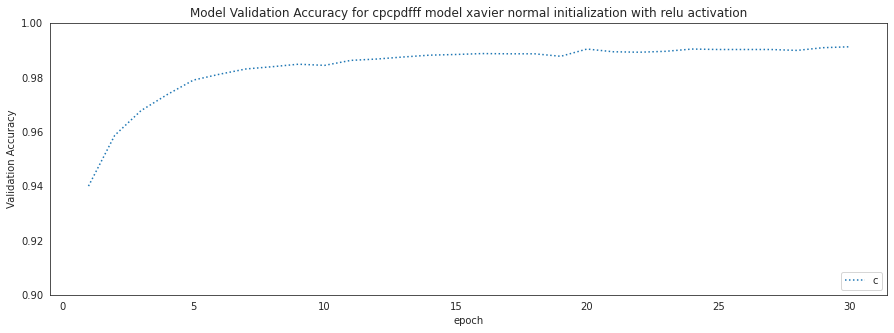

In [ ]:
# Plot validation accuracies 
names = 'cpcpdfff model xavier normal initialization with relu activation'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cpcpdfff_xavier_model_1.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cpcpdfff_xavier_model_1.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for cpcpdfff model xavier normal initialization with relu activation')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_cpcpdfff_xavier_model_1.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_cpcpdfff_xavier_model_1.history['val_sparse_categorical_accuracy'][len(history_cpcpdfff_xavier_model_1.history['val_sparse_categorical_accuracy'])-1]))
print('')
val_acc_1['xavier normal with relu']=history_cpcpdfff_xavier_model_1.history['val_sparse_categorical_accuracy'][len(history_cpcpdfff_xavier_model_1.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for cpcpdfff model xavier normal initialization with relu activation is 0.9912
Final Validation Accuracy for cpcpdfff model xavier normal initialization with relu activation is 0.9912



In [ ]:
sorted_val_acc_1_list=sorted(val_acc_1,key=val_acc_1.get)[::-1]

for i in sorted_val_acc_1_list:
  print(str(i)+': '+str('{0:.4f}').format(val_acc_1[i]))

xavier normal with relu: 0.9912
variance scaling with tanh: 0.9907
default initialization: 0.9906
he with relu: 0.9904


### Model 2 (cfpcfpdff)

For the cfpcfpdff model, we found that the best choices of initializers were variance scaling with tanh activation, He initialization with Relu activation, and Xavier normal initialization with Relu activation.

In particular, He initialization with Relu activation yielded the highest validation accuracy.

In [ ]:
val_acc_2 = {}

In [ ]:
def cfpcfpdff_rms():
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=128,
                   kernel_size= 5, strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = 'relu', use_bias = False))
  model.add(Dense(units=36, 
                  activation='relu'))
  model.add(MaxPooling2D(pool_size=2, strides=None))
  model.add(Conv2D(input_shape = (28,28,1),filters=128,
                   kernel_size= 5, strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = 'relu', use_bias = False))
  model.add(Dense(units=36, 
                  activation='relu'))
  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(Dropout(0.1))
  model.add(Flatten())
  
  model.add(Dense(units=36, 
                  activation='relu'))
  
  model.add(Dense(units = 10, activation = 'softmax'))
  
  return model

In [ ]:
def cfpcfpdff_rms_activation(init_fn,activation_fn):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=128,
                    kernel_size= 5, strides= 1,
                              padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                              kernel_initializer=init_fn, activation = activation_fn, use_bias=False))
  model.add(Dense(units=36, kernel_initializer=init_fn, activation = activation_fn))
  model.add(MaxPooling2D(pool_size=2, strides=None))
  model.add(Conv2D(input_shape = (28,28,1),filters=128,
                    kernel_size= 5, strides= 1,
                              padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                              kernel_initializer=init_fn, activation = activation_fn, use_bias=False))
  model.add(Dense(units=36, kernel_initializer=init_fn, activation = activation_fn))
  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(Dropout(0.1))
  model.add(Flatten())
    
  model.add(Dense(units=36, kernel_initializer=init_fn, activation = activation_fn))
    
  model.add(Dense(units = 10, kernel_initializer=init_fn, activation = 'softmax'))
  
  return model

#### Default (Glorot uniform)

In [ ]:
history_cfpcfpdff_default = []

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model = cfpcfpdff_rms()
model.compile(optimizer = RMSprop(learning_rate=1e-4), 
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cfpcfpdff_default = model.fit(train_images, train_labels, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

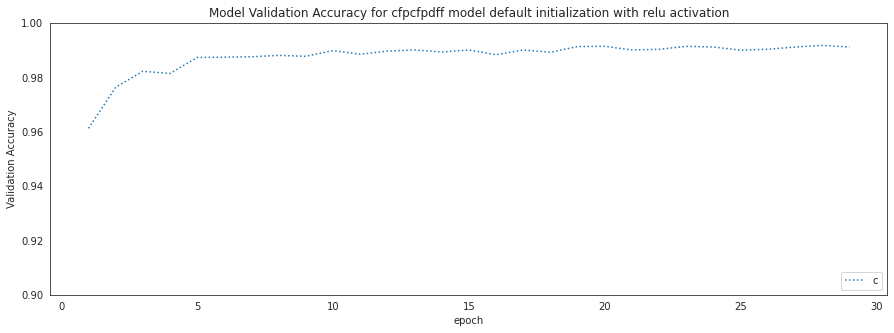

In [ ]:
# Plot validation accuracies 
names = 'cfpcfpdff model default initialization'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cfpcfpdff_default.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cfpcfpdff_default.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for cfpcfpdff model default initialization with relu activation')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_cfpcfpdff_default.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_cfpcfpdff_default.history['val_sparse_categorical_accuracy'][len(history_cfpcfpdff_default.history['val_sparse_categorical_accuracy'])-1]))
print('')
val_acc_2['default initialization']=history_cfpcfpdff_default.history['val_sparse_categorical_accuracy'][len(history_cfpcfpdff_default.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for cfpcfpdff model default initialization is 0.9918
Final Validation Accuracy for cfpcfpdff model default initialization is 0.9912



#### Variance scaling initialization with tanh activation

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model = cfpcfpdff_rms_activation(variance_scaling_initializer, 'tanh')
model.compile(optimizer = RMSprop(learning_rate=1e-4), 
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cfpcfpdfff_variance_scaling_model_2 = model.fit(train_images, train_labels, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

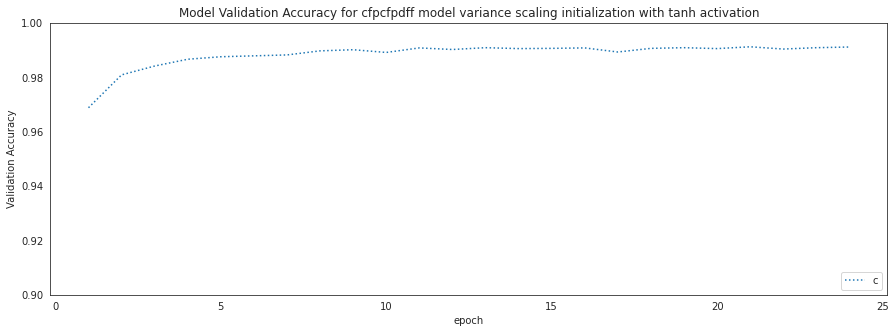

In [ ]:
# Plot validation accuracies 
names = 'cfpcfpdff model variance scaling initialization with tanh activation'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cfpcfpdfff_variance_scaling_model_2.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cfpcfpdfff_variance_scaling_model_2.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for cfpcfpdff model variance scaling initialization with tanh activation')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_cfpcfpdfff_variance_scaling_model_2.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_cfpcfpdfff_variance_scaling_model_2.history['val_sparse_categorical_accuracy'][len(history_cfpcfpdfff_variance_scaling_model_2.history['val_sparse_categorical_accuracy'])-1]))
print('')
val_acc_2['variance scaling with tanh']=history_cfpcfpdfff_variance_scaling_model_2.history['val_sparse_categorical_accuracy'][len(history_cfpcfpdfff_variance_scaling_model_2.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for cfpcfpdff model variance scaling initialization with tanh activation is 0.9912
Final Validation Accuracy for cfpcfpdff model variance scaling initialization with tanh activation is 0.9912



#### He initialization with ReLU activation

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model = cfpcfpdff_rms_activation(he_initializer, 'relu')
model.compile(optimizer = RMSprop(learning_rate=1e-4), 
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cfpcfpdff_he_model_2 = model.fit(train_images, train_labels, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

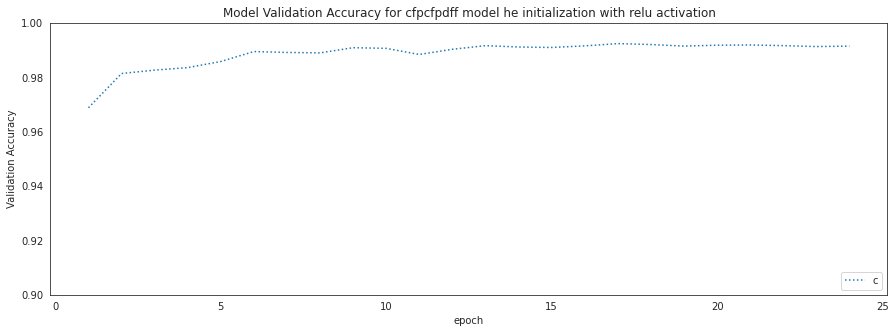

In [ ]:
# Plot validation accuracies 
names = 'cfpcfpdff model he initialization with relu activation'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cfpcfpdff_he_model_2.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cfpcfpdff_he_model_2.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for cfpcfpdff model he initialization with relu activation')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_cfpcfpdff_he_model_2.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_cfpcfpdff_he_model_2.history['val_sparse_categorical_accuracy'][len(history_cfpcfpdff_he_model_2.history['val_sparse_categorical_accuracy'])-1]))
print('')
val_acc_2['he with relu']=history_cfpcfpdff_he_model_2.history['val_sparse_categorical_accuracy'][len(history_cfpcfpdff_he_model_2.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for cfpcfpdff model he initialization with relu activation is 0.9924
Final Validation Accuracy for cfpcfpdff model he initialization with relu activation is 0.9915



#### Xavier normal initialization with ReLU activation

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model = cfpcfpdff_rms_activation(xavier_initializer, 'relu')
model.compile(optimizer = RMSprop(learning_rate=1e-4), 
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cfpcfpdfff_xavier_model_2 = model.fit(train_images, train_labels, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

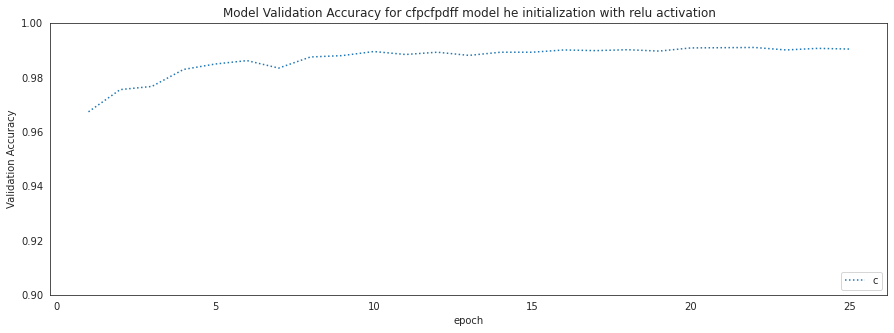

In [ ]:
# Plot validation accuracies 
names = 'cfpcfpdff model he initialization with relu activation'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cfpcfpdfff_xavier_model_2.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cfpcfpdfff_xavier_model_2.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for cfpcfpdff model he initialization with relu activation')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_cfpcfpdfff_xavier_model_2.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_cfpcfpdfff_xavier_model_2.history['val_sparse_categorical_accuracy'][len(history_cfpcfpdfff_xavier_model_2.history['val_sparse_categorical_accuracy'])-1]))
print('')
val_acc_2['xavier normal with relu']=history_cfpcfpdfff_xavier_model_2.history['val_sparse_categorical_accuracy'][len(history_cfpcfpdfff_xavier_model_2.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for cfpcfpdff model he initialization with relu activation is 0.9910
Final Validation Accuracy for cfpcfpdff model he initialization with relu activation is 0.9904



In [ ]:
sorted_val_acc_2_list=sorted(val_acc_2,key=val_acc_2.get)[::-1]

for i in sorted_val_acc_2_list:
  print(str(i)+': '+str('{0:.4f}').format(val_acc_2[i]))

he with relu: 0.9915
variance scaling with tanh: 0.9912
default initialization: 0.9912
xavier normal with relu: 0.9904


### Model 3 (ccpdnff)

For the ccpdnff model, we found that the best choices of initializers were variance scaling with Relu activation, He initialization with Relu activation, and Xavier normal initialization with Relu activation.

For most runs, we found that variance scaling with relu gives the best performance. However, among these three initializers, it is possible that any one of them could provide the best result in a given run. Hence, relative performance in a given run is often based on random chance, so the choice of initializer is not as important as other hyperparameters we considered.

In [ ]:
val_acc_3 = {}

In [ ]:
def ccpdnff_sgd():
  # create model
  model = Sequential()

  model.add(Conv2D(input_shape = (28,28,1),filters=32,kernel_size=(5,5),activation='relu',padding='same',use_bias = False))
  model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu',padding='same', use_bias = False))
  
  model.add(MaxPooling2D(pool_size=(2,2), strides=None))

  model.add(Dropout(0.1))

  model.add(Flatten())
  model.add(Dense(units=128, activation='relu'))  
  model.add(Dense(10, activation='softmax'))
  
  return model

In [ ]:
def ccpdnff_sgd_activation(initializer,activation_fn):
  # create model
  model = Sequential()

  model.add(Conv2D(input_shape = (28,28,1),filters=32,kernel_size=(5,5),activation=activation_fn,padding='same',use_bias = False,kernel_initializer=initializer))
  model.add(Conv2D(filters=128,kernel_size=(5,5),activation=activation_fn,padding='same', use_bias = False,kernel_initializer=initializer))
  
  model.add(MaxPooling2D(pool_size=(2,2), strides=None))

  model.add(Dropout(0.1))

  model.add(Flatten())
  model.add(Dense(units=128, activation=activation_fn,kernel_initializer=initializer))  
  model.add(Dense(10, activation='softmax',kernel_initializer=initializer))
  
  return model

#### Default (Glorot uniform)

In [ ]:
history_ccpdnff_default = []

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model = ccpdnff_sgd()
model.compile(optimizer = tf.keras.optimizers.SGD(0.1), 
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_ccpdnff_default = model.fit(train_images, train_labels, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

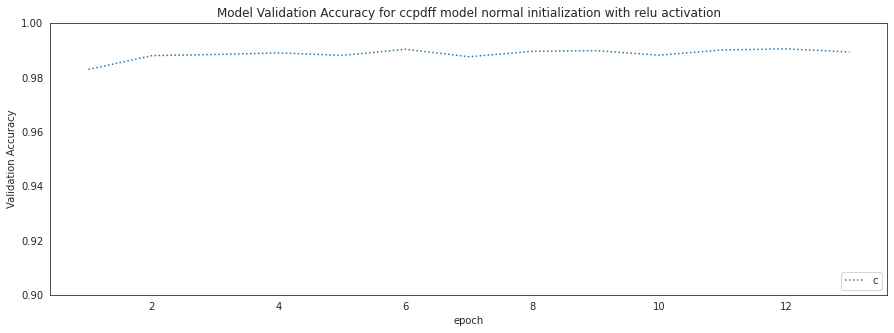

In [ ]:
# Plot validation accuracies 
names = 'ccpdnff model default initialization'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_ccpdnff_default.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_ccpdnff_default.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for ccpdff model normal initialization with relu activation')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_ccpdnff_default.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_ccpdnff_default.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_default.history['val_sparse_categorical_accuracy'])-1]))
print('')
val_acc_3['default initialization']=history_ccpdnff_default.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_default.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for ccpdnff model default initialization is 0.9905
Final Validation Accuracy for ccpdnff model default initialization is 0.9893



#### Variance scaling with Relu activation

In [ ]:
variance_scaling_initializer = tf.keras.initializers.VarianceScaling(
    scale=1.0, mode="fan_in", distribution="truncated_normal", seed=None
)
history_ccpdnff_variance_scaling = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model = ccpdnff_sgd_activation(variance_scaling_initializer, 'relu')
model.compile(optimizer = tf.keras.optimizers.SGD(0.1), 
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_ccpdnff_variance_scaling = model.fit(train_images, train_labels, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

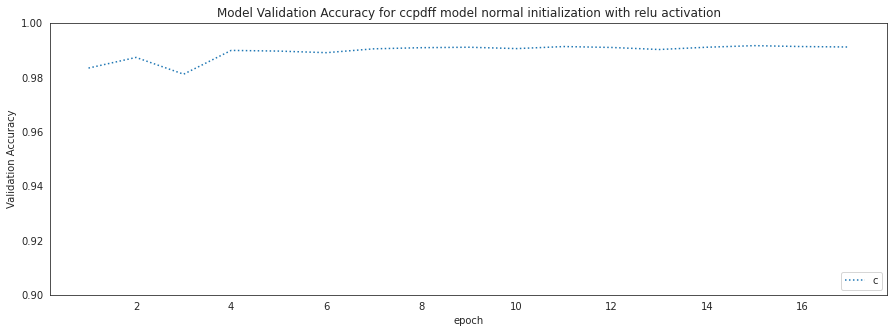

In [ ]:
# Plot validation accuracies 
names = 'ccpdnff model variance scaling initialization with relu activation'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_ccpdnff_variance_scaling.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_ccpdnff_variance_scaling.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for ccpdff model normal initialization with relu activation')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_ccpdnff_variance_scaling.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_ccpdnff_variance_scaling.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_variance_scaling.history['val_sparse_categorical_accuracy'])-1]))
print('')
val_acc_3['variance scaling with relu']=history_ccpdnff_variance_scaling.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_variance_scaling.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for ccpdnff model variance scaling initialization with relu activation is 0.9917
Final Validation Accuracy for ccpdnff model variance scaling initialization with relu activation is 0.9912



#### He initialization with Relu activation

In [ ]:
he_initializer = tf.keras.initializers.HeNormal()
history_ccpdnff_he = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model = ccpdnff_sgd_activation(he_initializer, 'relu')
model.compile(optimizer = SGD(learning_rate=0.1),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_ccpdnff_he = model.fit(train_images, train_labels, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

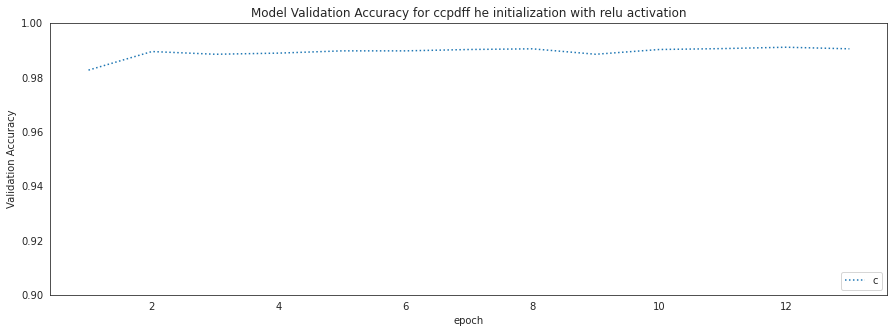

In [ ]:
# Plot validation accuracies 
names = 'ccpdnff model he initialization with relu activation'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_ccpdnff_he.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_ccpdnff_he.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for ccpdff he initialization with relu activation')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_ccpdnff_he.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_ccpdnff_he.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_he.history['val_sparse_categorical_accuracy'])-1]))
print('')
val_acc_3['he with relu']=history_ccpdnff_he.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_he.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for ccpdnff model he initialization with relu activation is 0.9911
Final Validation Accuracy for ccpdnff model he initialization with relu activation is 0.9905



#### Xavier normal with Relu activation

In [ ]:
xavier_initializer = tf.keras.initializers.GlorotNormal()
history_ccpdnff_xavier = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model = ccpdnff_sgd_activation(xavier_initializer, 'relu')
model.compile(optimizer = tf.keras.optimizers.SGD(0.1), 
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_ccpdnff_xavier = model.fit(train_images, train_labels, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

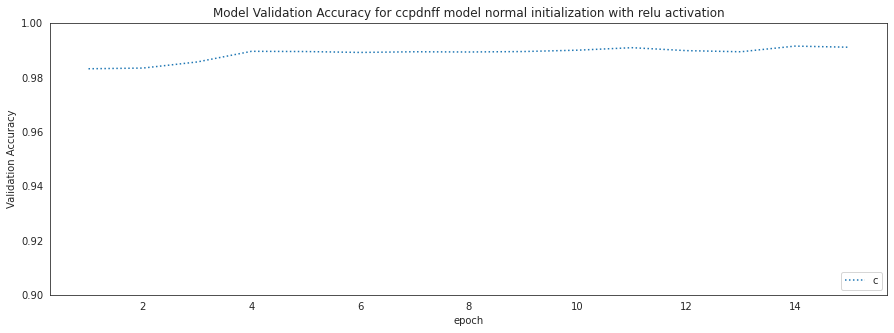

In [ ]:
# Plot validation accuracies 
names = 'ccpdnff model xavier normal initialization with relu activation'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_ccpdnff_xavier.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_ccpdnff_xavier.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for ccpdnff model normal initialization with relu activation')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_ccpdnff_xavier.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_ccpdnff_xavier.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_xavier.history['val_sparse_categorical_accuracy'])-1]))
print('')
val_acc_3['xavier normal with relu']=history_ccpdnff_xavier.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_xavier.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for ccpdnff model xavier normal initialization with relu activation is 0.9915
Final Validation Accuracy for ccpdnff model xavier normal initialization with relu activation is 0.9911



In [ ]:
sorted_val_acc_3_list=sorted(val_acc_3,key=val_acc_3.get)[::-1]

for i in sorted_val_acc_3_list:
  print(str(i)+': '+str('{0:.4f}').format(val_acc_3[i]))

variance scaling with relu: 0.9912
xavier normal with relu: 0.9911
he with relu: 0.9905
default initialization: 0.9893


## Regularization

Regularization techniques we investigated in our models include dropout, batch normalization, callback (early stopping), and layer weight regularizers. Here we demonstrate that batch normalization was effective to improve validation accuracy for Model 1 and 2, as well as the dropout and callback features built into the model since inception. We also demonstrate that layer weight regularizers did not help with performance. 

### Model 1 (improved to be cpcpdnfff)

Batch Normalization for model 1 raised about 0.0006 accuracy.

In [ ]:
def cpcpdnfff():
  init_fn = tf.keras.initializers.GlorotNormal()
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=96,
                   kernel_size= 5, strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(Conv2D(input_shape = (28,28,1),filters=96,
                   kernel_size= 5, strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            kernel_initializer=init_fn, activation = 'relu', use_bias = False))
  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=64, kernel_initializer=init_fn, activation='relu'))
  model.add(Dense(units=64, kernel_initializer=init_fn, activation='relu'))
  
  model.add(Dense(units = 10, kernel_initializer=init_fn, activation = 'softmax'))
  
  return model

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10)
model_cpcpdnfff = cpcpdnfff()
model_cpcpdnfff.compile(optimizer = RMSprop(learning_rate=1e-4), 
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cpcpdnfff = model_cpcpdnfff.fit(train_images, train_labels, batch_size = 32, epochs=30, 
                                      callbacks=[early_stopping_cb], validation_split = 0.2, verbose = 0)

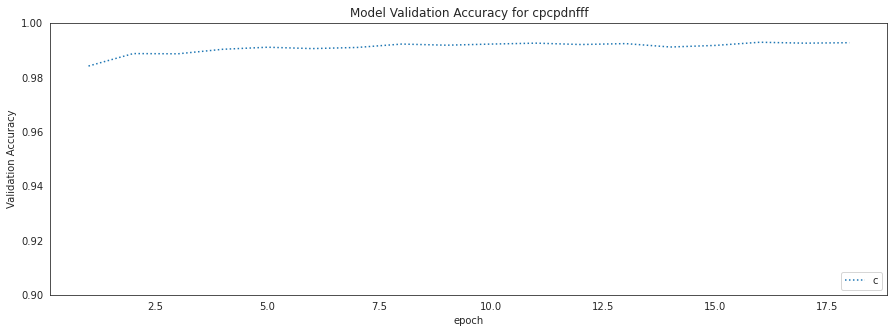

In [ ]:
# Plot validation accuracies 
names_cpcpdnfff = 'cpcpdnfff model'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cpcpdnfff.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cpcpdnfff.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for cpcpdnfff')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_cpcpdnfff, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names_cpcpdnfff +' is {0:.4f}'.format(max(history_cpcpdnfff.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names_cpcpdnfff +
      ' is {0:.4f}'.format(history_cpcpdnfff.history['val_sparse_categorical_accuracy'][len(history_cpcpdnfff.history['val_sparse_categorical_accuracy'])-1]))
print('')

Max Validation Accuracy for cpcpdnfff model is 0.9929
Final Validation Accuracy for cpcpdnfff model is 0.9927



#### Layer Weight Regularizer (L1, L2)

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
# kernel_regularizer=l1_l2(l1=hp.Choice('conv2D_1_kernel_l1',values=[0.01,0.001,0.1], default = None),
#                           l2=hp.Choice('conv2D_1_kernel_l2',values=[0.01,0.001,0.1], default = None)),
#                   bias_regularizer=l1_l2(l1=hp.Choice('conv2D_1_bias_l1',values=[0.01,0.001,0.1], default = None),
#                                         l2=hp.Choice('conv2D_1_bias_l2',values=[0.01,0.001,0.1], default = None))
                  
#1 
def build_model(hp):
  init_fn = tf.keras.initializers.GlorotNormal()
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=96,
                   kernel_size= 5, strides= 1, 
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  # model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=2, strides=None))
  # model.add(BatchNormalization())

  model.add(Conv2D(input_shape = (28,28,1),filters=96,
                   kernel_size= 5, strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            kernel_initializer=init_fn, activation = 'relu', use_bias = False))
  # model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=64, kernel_initializer=init_fn, activation='relu',
                  kernel_regularizer=l1_l2(l1=hp.Choice('dense_1_kernel_l1',values=[1e-2, 1e-3,1e-4,1e-5], default = None),
                          l2=hp.Choice('dense_1_kernel_l2',values=[1e-2, 1e-3,1e-4,1e-5], default = None)),
                  bias_regularizer=l1_l2(l1=hp.Choice('dense_1_bias_l1',values=[1e-2, 1e-3,1e-4], default = None),
                                        l2=hp.Choice('dense_1_bias_l2',values=[1e-2, 1e-3,1e-4,1e-5], default = None))))
  model.add(Dense(units=64, kernel_initializer=init_fn, activation='relu'))
  
  model.add(Dense(units = 10, kernel_initializer=init_fn, activation = 'softmax'))
  
  model.compile(optimizer = RMSprop(learning_rate=1e-4), #RMSprop
                         
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3, 1e-4])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3, 1e-4])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2,1e-3, 1e-4]))]), #SGD
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:

tuner_cpcpdfff = kt.Hyperband(build_model,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'cpcpdnff_reg4')

tuner_cpcpdfff.search(train_images,train_labels,epochs= 30, validation_split = 0.2,callbacks = [ClearTrainingOutput()])

### Model 2 (improved to be cfpncfpdnff)

Batch Normalization for model 2 raised about 0.0006 accuracy.

In [ ]:
#2
def cfpncfpdnff():
  init_fn = tf.keras.initializers.HeNormal()
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=128,
                   kernel_size= 5, strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  model.add(Dense(units=36, kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(BatchNormalization())

  model.add(Conv2D(input_shape = (28,28,1),filters=128,
                   kernel_size= 5, strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  model.add(Dense(units=36, kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())

  model.add(Dense(units=36, kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  
  model.add(Dense(units = 10, kernel_initializer=init_fn, activation = 'softmax'))
  
  return model

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10)
model_cfpncfpdnff = cfpncfpdnff()
model_cfpncfpdnff.compile(optimizer = RMSprop(learning_rate=1e-4), 
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cfpncfpdnff = model_cfpncfpdnff.fit(train_images, train_labels, batch_size = 32, epochs=30, 
                                      callbacks=[early_stopping_cb], validation_split = 0.2, verbose = 0)

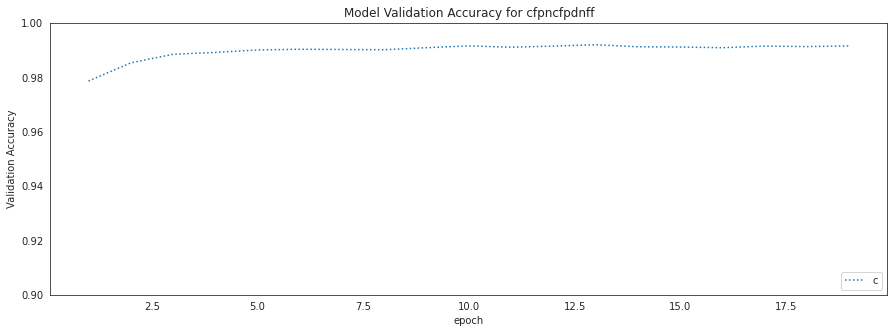

In [ ]:
# Plot validation accuracies 
names_cfpncfpdnff = 'cfpncfpdnff model'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cfpncfpdnff.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cfpncfpdnff.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for cfpncfpdnff')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_cpcpdnfff, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names_cfpncfpdnff +' is {0:.4f}'.format(max(history_cfpncfpdnff.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names_cfpncfpdnff +
      ' is {0:.4f}'.format(history_cfpncfpdnff.history['val_sparse_categorical_accuracy'][len(history_cfpncfpdnff.history['val_sparse_categorical_accuracy'])-1]))
print('')

Max Validation Accuracy for cfpncfpdnff model is 0.9920
Final Validation Accuracy for cfpncfpdnff model is 0.9916



#### Layer Weight Regularizers (L1, L2)

In [ ]:
# kernel_regularizer=l1_l2(l1=hp.Choice('conv2D_1_kernel_l1',values=[0.01,0.001,0.1], default = None),
#                           l2=hp.Choice('conv2D_1_kernel_l2',values=[0.01,0.001,0.1], default = None)),
#                   bias_regularizer=l1_l2(l1=hp.Choice('conv2D_1_bias_l1',values=[0.01,0.001,0.1], default = None),
#                                         l2=hp.Choice('conv2D_1_bias_l2',values=[0.01,0.001,0.1], default = None))
                  
#1 
def build_model(hp):
  init_fn = tf.keras.initializers.GlorotNormal()
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=96,
                   kernel_size= 5, strides= 1, kernel_regularizer=l1_l2(l1=hp.Choice('conv2D_1_kernel_l1',values=[1e-3,1e-4,1e-5], default = None),
                          l2=hp.Choice('conv2D_1_kernel_l2',values=[1e-4,1e-5], default = None)),
                  bias_regularizer=l1_l2(l1=hp.Choice('conv2D_1_bias_l1',values=[1e-3,1e-4,1e-5], default = None),
                                        l2=hp.Choice('conv2D_1_bias_l2',values=[1e-3,1e-4,1e-5], default = None)),
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  # model.add(BatchNormalization())
  model.add(Dense(units=36, kernel_initializer=init_fn, activation = 'relu', use_bias=False,
                   kernel_regularizer=l1_l2(l1=hp.Choice('dense_1_kernel_l1',values=[1e-4,1e-5], default = None),
                          l2=hp.Choice('dense_1_kernel_l2',values=[1e-4,1e-5], default = None)),
                  bias_regularizer=l1_l2(l1=hp.Choice('dense_1_bias_l1',values=[1e-5, 1e-3,1e-4], default = None),
                                        l2=hp.Choice('dense_1_bias_l2',values=[1e-3,1e-4,1e-5], default = None))))

  model.add(MaxPooling2D(pool_size=2, strides=None))
  model.add(BatchNormalization())

  model.add(Conv2D(input_shape = (28,28,1),filters=96,
                   kernel_size= 5, strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            kernel_regularizer=l1_l2(l1=hp.Choice('conv2D_1_kernel_l1',values=[1e-4,1e-5], default = None),
                          l2=hp.Choice('conv2D_1_kernel_l2',values=[1e-4,1e-5], default = None)),
                  bias_regularizer=l1_l2(l1=hp.Choice('conv2D_1_bias_l1',values=[1e-4,1e-5], default = None),
                                        l2=hp.Choice('conv2D_1_bias_l2',values=[1e-4,1e-5], default = None)),
                            kernel_initializer=init_fn, activation = 'relu', use_bias = False))
  # model.add(BatchNormalization())
  model.add(Dense(units=36, kernel_initializer=init_fn, activation = 'relu', use_bias=False))

  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=64, kernel_initializer=init_fn, activation='relu'))
  model.add(Dense(units=64, kernel_initializer=init_fn, activation='relu'))
  
  model.add(Dense(units = 10, kernel_initializer=init_fn, activation = 'softmax'))
  
  model.compile(optimizer = RMSprop(learning_rate=1e-4), #RMSprop
                         
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3, 1e-4])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3, 1e-4])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2,1e-3, 1e-4]))]), #SGD
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:

tuner_cfpncfpdnff = kt.Hyperband(build_model,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'cfpncfpdnff_reg4')

In [ ]:
tuner_cfpncfpdnff.search(train_images,train_labels,epochs= 30, validation_split = 0.2,callbacks = [ClearTrainingOutput()])

### Model 3

We did not do any additional regularization for Model 3 as we already included batch normalization, dropout, and early stopping in the architecture step.

## Summary of Best Models

Here we will examine the final validation and test accuracy of the best model we got for each of the three architectures we tried. For model 1 and model 2, we obtained the best models from the end of the regularization section. For model 3 we obtained the best one from the end of the initialization section as regularization was already done in the architecture step for model 3.

 We will also compare them with the unregularized MLP.

In [ ]:
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
train_images, test_images = train_images / 255.0, test_images / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
#dictionaries to store the validation and test accuracies
mnist_val_acc = {}
mnist_test_acc = {}

### Unregularized MLP

For the unregularized MLP we used one hot vectors and categorical cross entropy loss. Note that this yields the same value as using sparse categorical cross entropy without doing one hot encoding like we did with the other models.

In [ ]:
#baseline

(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = tf.cast(x_train,dtype=tf.float32)/255.0, tf.cast(x_test,dtype=tf.float32)/255.0
#y_train, y_test = tf.one_hot(y_train, depth=10),tf.one_hot(y_test, depth=10)

# MNIST: (28,28) - > 784 -> 128 -> 10 logits

# Sequential API
unregularized_mlp = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape = (28,28)),
      tf.keras.layers.Dense(16, activation='relu'), 
      tf.keras.layers.Dense(16, activation='relu'), 

      #Add layers
      tf.keras.layers.Dense(10)
])



In [ ]:
unregularized_mlp.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),#based on one-hot vector
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]) 

history = unregularized_mlp.fit(x_train,y_train, batch_size=128,epochs=100,
          validation_split = 0.2,verbose=0,
           callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logs_base_dir, histogram_freq=1)],
          )

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ 'unregularized mlp' +' is {0:.4f}'.format(max(history.history['val_categorical_accuracy'])))
print('Final Validation Accuracy for '+ 'unregularized mlp' +
      ' is {0:.4f}'.format(history.history['val_categorical_accuracy'][len(history.history['val_categorical_accuracy'])-1]))
print('')
mnist_val_acc['unregularized_mlp']=history.history['val_categorical_accuracy'][len(history.history['val_categorical_accuracy'])-1]

Max Validation Accuracy for unregularized mlp is 0.9549
Final Validation Accuracy for unregularized mlp is 0.9500



In [ ]:
#%tensorboard --logdir {logs_base_dir}

In [ ]:
unregularized_mlp.evaluate(x_test,y_test,batch_size=128)
result = unregularized_mlp.evaluate(x_test,y_test)
mnist_test_acc['unregularized_mlp']=dict(zip(unregularized_mlp.metrics_names, result))['categorical_accuracy']

313/313 [==============================] - 1s 2ms/step - loss: 0.2460 - categorical_accuracy: 0.9491


### Model 1 (cpcpdnff w/ RMSprop)

In [ ]:
#1 
def cpcpdnfff_rms():
  init_fn = tf.keras.initializers.GlorotNormal()
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=96, kernel_size= 5, strides= 1, padding= 'same', 
                   kernel_initializer=init_fn, activation = 'relu', use_bias = False))
  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(Conv2D(input_shape = (28,28,1),filters=96, kernel_size= 5, strides= 1, padding= 'same', 
                   kernel_initializer=init_fn, activation = 'relu', use_bias = False))
  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=64, kernel_initializer=init_fn, activation='relu'))
  model.add(Dense(units=64, kernel_initializer=init_fn, activation='relu'))
  
  model.add(Dense(units = 10, kernel_initializer=init_fn, activation = 'softmax'))
  
  return model

In [ ]:
!rm -rf ./logs/ 

# For use of Tensorboard later
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

history_cpcpdnfff = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 3 times of increase in valid_loss
model_cpcpdnfff = cpcpdnfff_rms()
model_cpcpdnfff.compile(optimizer = RMSprop(learning_rate=1e-4), 
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
                        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cpcpdnfff = model_cpcpdnfff.fit(train_images, train_labels, batch_size = 32, epochs=30, 
                                      callbacks=[early_stopping_cb], validation_split = 0.2, verbose = 0)

In [ ]:
#%tensorboard --logdir {logs_base_dir}

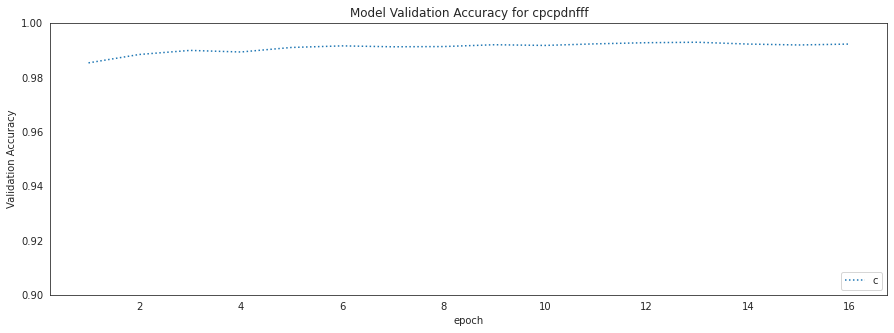

In [ ]:
# Plot validation accuracies 
names_cpcpdnfff = 'cpcpdnfff model'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cpcpdnfff.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cpcpdnfff.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for cpcpdnfff')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_cpcpdnfff, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names_cpcpdnfff +' is {0:.4f}'.format(max(history_cpcpdnfff.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names_cpcpdnfff +
      ' is {0:.4f}'.format(history_cpcpdnfff.history['val_sparse_categorical_accuracy'][len(history_cpcpdnfff.history['val_sparse_categorical_accuracy'])-1]))
print('')
mnist_val_acc['cpcpdfff_rms']=history_cpcpdnfff.history['val_sparse_categorical_accuracy'][len(history_cpcpdnfff.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for cpcpdnfff model is 0.9929
Final Validation Accuracy for cpcpdnfff model is 0.9923



In [ ]:
model_cpcpdnfff.evaluate(test_images,test_labels)
result_cpcpdnfff = model_cpcpdnfff.evaluate(test_images,test_labels)
mnist_test_acc['cpcpdfff_rms']=dict(zip(model_cpcpdnfff.metrics_names, result_cpcpdnfff))['sparse_categorical_accuracy']

313/313 [==============================] - 1s 3ms/step - loss: 0.0308 - sparse_categorical_accuracy: 0.9933


### Model 2 (cfpncfpdnff w/ RMSprop)

In [ ]:
#2
def cfpncfpdnff_rms():
  init_fn = tf.keras.initializers.HeNormal()
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=128, kernel_size= 5, strides= 1, padding= 'same',
                   kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  model.add(Dense(units=36, kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(BatchNormalization())

  model.add(Conv2D(input_shape = (28,28,1),filters=128, kernel_size= 5, strides= 1, padding= 'same',
                   kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  model.add(Dense(units=36, kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())

  model.add(Dense(units=36, kernel_initializer=init_fn, activation = 'relu', use_bias=False))

  model.add(Dense(units = 10, kernel_initializer=init_fn, activation = 'softmax'))
  
  return model

In [ ]:
history_cfpncfpdnff_rms = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 3 times of increase in valid_loss
model_cfpncfpdnff_rms = cfpncfpdnff_rms()
model_cfpncfpdnff_rms.compile(optimizer = RMSprop(learning_rate=1e-4),
                              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
                              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cfpncfpdnff_rms = model_cfpncfpdnff_rms.fit(train_images, train_labels, batch_size = 32, epochs=30, 
                                      callbacks=[early_stopping_cb], validation_split = 0.2, verbose = 0)

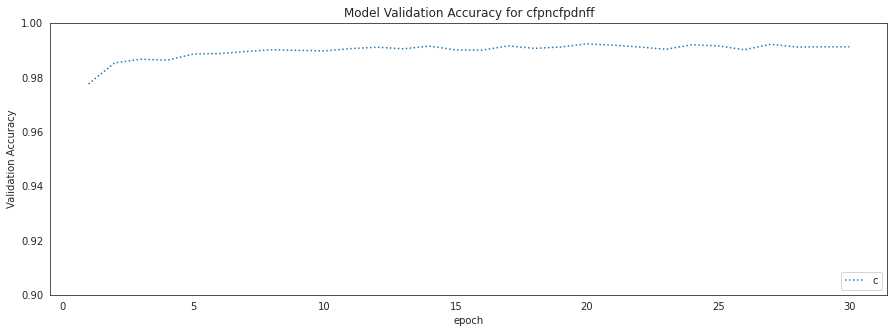

In [ ]:
# Plot validation accuracies 
names_cfpncfpdnff = 'cfpncfpdnff model'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cfpncfpdnff_rms.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cfpncfpdnff_rms.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for cfpncfpdnff')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_cfpncfpdnff, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names_cfpncfpdnff +' is {0:.4f}'.format(max(history_cfpncfpdnff_rms.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names_cfpncfpdnff +
      ' is {0:.4f}'.format(history_cfpncfpdnff_rms.history['val_sparse_categorical_accuracy'][len(history_cfpncfpdnff_rms.history['val_sparse_categorical_accuracy'])-1]))
print('')
mnist_val_acc['cfpncfpdnff_rms']=history_cfpncfpdnff_rms.history['val_sparse_categorical_accuracy'][len(history_cfpncfpdnff_rms.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for cfpncfpdnff model is 0.9923
Final Validation Accuracy for cfpncfpdnff model is 0.9912



In [ ]:
model_cfpncfpdnff_rms.evaluate(test_images,test_labels)
result_cfpncfpdnff = model_cfpncfpdnff_rms.evaluate(test_images,test_labels)
mnist_test_acc['cfpncfpdnff_rms']=dict(zip(model_cfpncfpdnff_rms.metrics_names, result_cfpncfpdnff))['sparse_categorical_accuracy']

313/313 [==============================] - 1s 4ms/step - loss: 0.0397 - sparse_categorical_accuracy: 0.9923


### Model 3 (ccpdnff w/ SGD)

In [ ]:
#3. variance scaling with relu

def ccpdnff_sgd():
  init_fn = tf.keras.initializers.VarianceScaling(
    scale=1.0, mode="fan_in", distribution="truncated_normal", seed=None
    )
  model = Sequential()

  model.add(Conv2D(input_shape = (28,28,1),filters=32,kernel_size=(5,5),activation='relu',padding='same',use_bias = False,kernel_initializer=init_fn))
  model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu',padding='same', use_bias = False,kernel_initializer=init_fn))
  
  model.add(MaxPooling2D(pool_size=(2,2), strides=None))

  model.add(Dropout(0.1))

  model.add(Flatten())
  model.add(Dense(units=128, activation='relu',kernel_initializer=init_fn))  
  model.add(Dense(10, activation='softmax',kernel_initializer=init_fn))
  
  return model


In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model_ccpdnff = ccpdnff_sgd()
model_ccpdnff.compile(optimizer = SGD(learning_rate=0.1),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_ccpdnff_he = model_ccpdnff.fit(train_images, train_labels, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

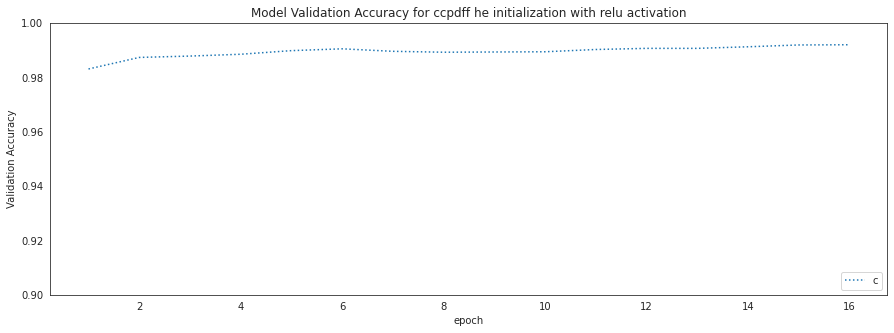

In [ ]:
# Plot validation accuracies 
names = 'ccpdnff model he initialization with relu activation'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_ccpdnff_he.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_ccpdnff_he.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for ccpdff he initialization with relu activation')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_ccpdnff_he.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_ccpdnff_he.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_he.history['val_sparse_categorical_accuracy'])-1]))
print('')
mnist_val_acc['ccpdnff_sgd']=history_ccpdnff_he.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_he.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for ccpdnff model he initialization with relu activation is 0.9920
Final Validation Accuracy for ccpdnff model he initialization with relu activation is 0.9920



In [ ]:
model_ccpdnff.evaluate(test_images,test_labels)
result_ccpdnff = model_ccpdnff.evaluate(test_images,test_labels)
mnist_test_acc['ccpdnff_sgd']=dict(zip(model_ccpdnff.metrics_names, result_ccpdnff))['sparse_categorical_accuracy']

313/313 [==============================] - 1s 3ms/step - loss: 0.0310 - sparse_categorical_accuracy: 0.9922


Overall, we see that Model 1, cpcdpdfff with rms optimization and glorot normal initialization performed the best.

In [ ]:
sorted_val_acc_list=sorted(mnist_val_acc,key=mnist_val_acc.get)[::-1]

for i in sorted_val_acc_list:
  print(str(i)+': '+str('{0:.4f}').format(mnist_val_acc[i]))

cpcpdfff_rms: 0.9923
ccpdnff_sgd: 0.9920
cfpncfpdnff_rms: 0.9908
unregularized_mlp: 0.9500


In [ ]:
sorted_test_acc_list=sorted(mnist_test_acc,key=mnist_test_acc.get)[::-1]

for i in sorted_test_acc_list:
  print(str(i)+': '+str('{0:.4f}').format(mnist_test_acc[i]))

cpcpdfff_rms: 0.9933
ccpdnff_sgd: 0.9922
unregularized_mlp: 0.9491


See where Model 3 performed the best and worst. It turns out it predicts the digit 5 the worst (98% precision and 99% recall), although this is still a pretty high accuracy. Looking at the images that Model 3 did not predict correctly, we observe that some test images are quite difficult for humans to distinguish as well, for example True 6 / Pred 0 and True 2 / Pred 7.

In [ ]:
#get the predictions for the test data
p = model_ccpdnff.predict(test_images)
y_pred = np.apply_along_axis(np.argmax, 1, p)
correct = np.where(y_pred==test_labels)[0] 
incorrect = np.where(y_pred!=test_labels)[0] 
print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 9929
Incorrect predicted classes: 71


In [ ]:
# Prediction performance per category
class_names = np.arange(10)
target_names = ["Class {} ({}) :".format(i,class_names[i]) for i in range(10)]
print(classification_report(test_labels, y_pred, target_names=target_names))

               precision    recall  f1-score   support

Class 0 (0) :       0.99      0.99      0.99       980
Class 1 (1) :       1.00      1.00      1.00      1135
Class 2 (2) :       0.99      0.99      0.99      1032
Class 3 (3) :       1.00      0.99      0.99      1010
Class 4 (4) :       1.00      1.00      1.00       982
Class 5 (5) :       0.98      0.99      0.99       892
Class 6 (6) :       0.99      0.99      0.99       958
Class 7 (7) :       0.99      0.99      0.99      1028
Class 8 (8) :       0.99      0.99      0.99       974
Class 9 (9) :       0.99      0.99      0.99      1009

     accuracy                           0.99     10000
    macro avg       0.99      0.99      0.99     10000
 weighted avg       0.99      0.99      0.99     10000



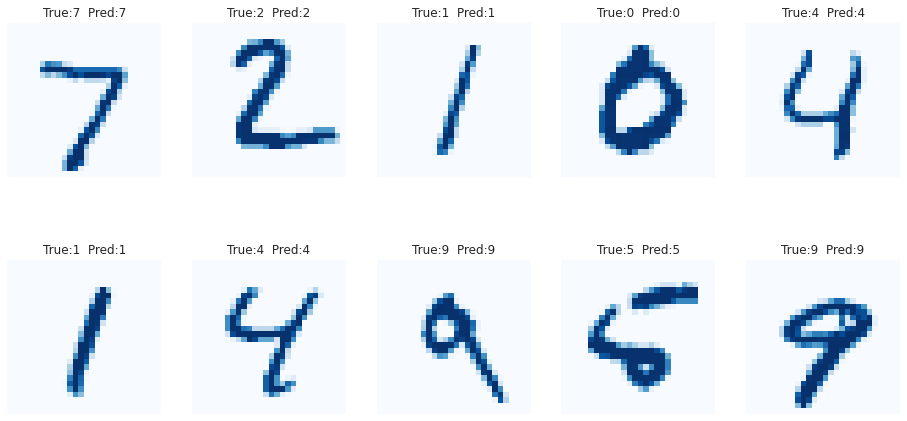

In [ ]:
def plot_images(data_index,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(2,5, figsize=(16,8))

    for i, indx in enumerate(data_index[:10]):
        ax[i//5, i%5].imshow(test_images[indx,:,:,0], cmap=cmap)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("True:{}  Pred:{}".format(class_names[test_labels[indx]],class_names[y_pred[indx]]))
    plt.show()    
    
plot_images(correct, "Blues")

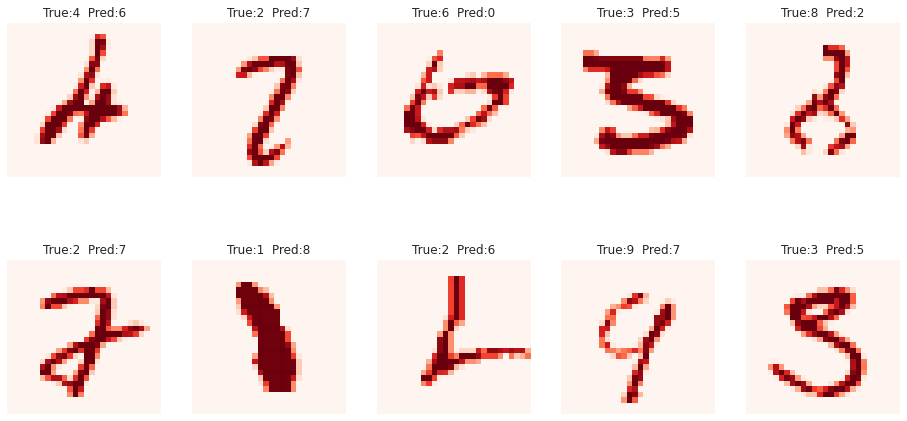

In [ ]:
plot_images(incorrect, "Reds")

# Fashion MNIST

#### Unregularized MLP

Likewise with MNIST, we first trained an unregularized MLP with 2 hidden layers and 16 hidden units with ReLU activations as the baseline model for Fashion-MNIST.

Note that we use the default optimizer, which is Adam with learning rate 0.001 and the default initializer, which is glorot uniform.

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape((60000, 28, 28, 1))
X_test = X_test.reshape((10000, 28, 28, 1))
X_train, X_test = X_train / 255.0, X_test / 255.0
#y_train, y_test = tf.one_hot(y_train, depth=10),tf.one_hot(y_test, depth=10)

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
# Fashion MNIST: (28,28) - > 784 -> 128 -> 10 logits

# Sequential API
unregularized_mlp = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape = (28,28)),
      tf.keras.layers.Dense(16, activation='relu'), 
      tf.keras.layers.Dense(16, activation='relu'), 

      #Add layers
      tf.keras.layers.Dense(10)
])

In [ ]:
unregularized_mlp.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),#based on one-hot vector
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]) 

In [ ]:
history = unregularized_mlp.fit(X_train,y_train, batch_size=128,epochs=100,
                                validation_split = 0.2,verbose=0) 

We end up with an out of sample accuracy of 85.89%

In [ ]:
unregularized_mlp.evaluate(X_test,y_test,batch_size=128)

79/79 [==============================] - 0s 2ms/step - loss: 0.4993 - categorical_accuracy: 0.8589


[0.49930834770202637, 0.8589000105857849]

## Best MNIST Model evaluated on Fashion MNIST

In this section, we examine whether our best performing MNIST models also perform well for Fashion MNIST. The test accuracies were over 91%, demonstrating certain robustness in our models to different datasets.

In [ ]:
# Load data 
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))
# Normalize data x
x_train, x_test = tf.cast(x_train,dtype=tf.float32)/255.0, tf.cast(x_test,dtype=tf.float32)/255.0
# y_train, y_test = tf.one_hot(y_train, depth=10),tf.one_hot(y_test, depth=10)
print(f'Train data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

Train data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


### Model 1 (ccpdnff w/ SGD)

In [ ]:
def ccpdnff_sgd():
  init_fn = tf.keras.initializers.VarianceScaling(
    scale=1.0, mode="fan_in", distribution="truncated_normal", seed=None
    )
  model = Sequential()

  model.add(Conv2D(input_shape = (28,28,1),filters=32,kernel_size=(5,5),activation='relu',padding='same',use_bias = False,kernel_initializer=init_fn))
  model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu',padding='same', use_bias = False,kernel_initializer=init_fn))
  
  model.add(MaxPooling2D(pool_size=(2,2), strides=None))

  model.add(Dropout(0.1))

  model.add(Flatten())
  model.add(Dense(units=128, activation='relu',kernel_initializer=init_fn))  
  model.add(Dense(10, activation='softmax',kernel_initializer=init_fn))
  
  return model


In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model_ccpdnff = ccpdnff_sgd()
model_ccpdnff.compile(optimizer = SGD(learning_rate=0.1),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_ccpdnff = model_ccpdnff.fit(X_train, y_train, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

In [ ]:
model_ccpdnff.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3831 - sparse_categorical_accuracy: 0.9224


[0.38314205408096313, 0.9223999977111816]

### Model 2 (cpcpdnff w/ RMSprop)

In [ ]:
#1 
def cpcpdnfff_rms():
  init_fn = tf.keras.initializers.GlorotNormal()
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=96,
                   kernel_size= 5, strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(Conv2D(input_shape = (28,28,1),filters=96,
                   kernel_size= 5, strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            kernel_initializer=init_fn, activation = 'relu', use_bias = False))
  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=64, kernel_initializer=init_fn, activation='relu'))
  model.add(Dense(units=64, kernel_initializer=init_fn, activation='relu'))
  
  model.add(Dense(units = 10, kernel_initializer=init_fn, activation = 'softmax'))
  
  return model

In [ ]:
history_cpcpndfff = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 3 times of increase in valid_loss
model_cpcpdnfff = cpcpdnfff_rms()
model_cpcpdnfff.compile(optimizer = RMSprop(learning_rate=1e-4), #RMSprop
                         
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3, 1e-4])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3, 1e-4])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2,1e-3, 1e-4]))]), #SGD
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cpcpdnfff = model_cpcpdnfff.fit(X_train, y_train, batch_size = 32, epochs=30, 
                                      callbacks=[early_stopping_cb], validation_split = 0.2, verbose = 0)

In [ ]:
model_cpcpdnfff.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3744 - sparse_categorical_accuracy: 0.9129


[0.37436771392822266, 0.9128999710083008]

### Model 3 (cfpcfpdff w/ RMSprop)

In [ ]:
#2
def cfpcfpdff_rms():
  init_fn = tf.keras.initializers.HeNormal()
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=128,
                   kernel_size= 5, strides= 1,
                            padding= 'same', 
                            kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  model.add(Dense(units=36, kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(BatchNormalization())

  model.add(Conv2D(input_shape = (28,28,1),filters=128,
                   kernel_size= 5, strides= 1,
                            padding= 'same', 
                            kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  model.add(Dense(units=36, kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())

  model.add(Dense(units=36, kernel_initializer=init_fn, activation = 'relu', use_bias=False))
  
  model.add(Dense(units = 10, kernel_initializer=init_fn, activation = 'softmax'))
  
  return model

In [ ]:
history_cfpcfpdfff = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20) #we accept 3 times of increase in valid_loss
model_cfpcfpdfff = cfpcfpdff_rms()
model_cfpcfpdfff.compile(optimizer = RMSprop(learning_rate=1e-4), #RMSprop
                         
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3, 1e-4])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3, 1e-4])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2,1e-3, 1e-4]))]), #SGD
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cfpcfpdfff = model_cfpcfpdfff.fit(X_train, y_train, batch_size = 32, epochs=30, 
                                      callbacks=[early_stopping_cb], validation_split = 0.2, verbose = 0)

In [ ]:
model_cfpcfpdfff.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3739 - sparse_categorical_accuracy: 0.9112


[0.373851478099823, 0.9111999869346619]

## Architecture

We tried several different architectures and narrowed them down to 3, 2, and then 1 eventually as we compared the performance with the previous models.

In [ ]:
# Load data 
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))

# Normalize data x
x_train, x_test = tf.cast(x_train,dtype=tf.float32)/255.0, tf.cast(x_test,dtype=tf.float32)/255.0
# y_train, y_test = tf.one_hot(y_train, depth=10),tf.one_hot(y_test, depth=10)
print(f'Train data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

4423680/4422102 [==============================] - 0s 0us/step
Train data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


### Conv2D, MaxPooling, Batch Normalization, Dropout layers

Model structures we investigated include [cpcp]x[ff], [cp]x[ff], [cp]x[ffff], [cfpcfp]x[ff], [cfpf], and the addition / exclusion of batch normalization and dropout layers. From this exercise, we've found out that ccpdnff (Model 3 from MNIST) had one of the highest accuracies, showing the transferability of this model from one dataset to another. We've acquired two new models that work well for Fashion-MNIST: cfpdndff and cpdnfndff.

In [ ]:
# helper function
def dense_model(layers):
  model = Sequential()
  model.add(Flatten(input_shape = (28,28)))

  for unit in layers:
    model.add(Dense(units = unit, activation = 'relu'))

  model.add(Dense(units = 10, activation = 'softmax'))
  return model

* cnn_[cpcp]x[ff] model

In [ ]:
# helper function
def cnn_cpcpff(cnn, layers):
  model = Sequential()
  # model.add(Flatten())
  for i in cnn:
    model.add(Conv2D(input_shape = (28,28,1),filters=32,kernel_size=(3,3), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = None, use_bias = False,data_format='channels_first'))

    model.add(MaxPool2D(pool_size=(2,2), strides=None))

  model.add(Flatten())
  for unit in layers:
    model.add(Dense(units = 64, activation = 'relu'))

  model.add(Dense(units = 10, activation = 'softmax'))
  return model

In [ ]:
depths = [1,2,4,8]
# units = [512,1024]
cnn = [1,2,4,8]
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5) #we accept 5 times of increase in valid_loss

history_all = []


for depth in depths:
    # for u in units:
      for i in cnn:
        model = cnn_cpcpff([i], [depth])
        model.compile(optimizer = tf.keras.optimizers.Adam(), #'adam'
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
                  metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
        history_all.append(model.fit(x_train, y_train, batch_size = 128, epochs=100, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0))

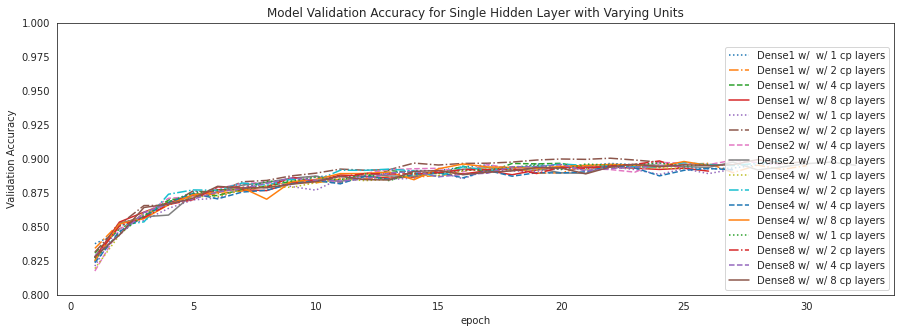

In [ ]:
import itertools
# Plot training accuracies 
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-',':','-.','--','-']
names_all = ['Dense' + str(combo[0]) + ' w/ '  + ' w/ ' + str(combo[1]) + ' cp layers' for combo in itertools.product(depths,  cnn)]
#epochs_i = np.arange(100) + 1
# Plot validation accuracies 
plt.figure(figsize=(15,5))
for i in range(len(depths)*len(cnn)):
    length = len(history_all[i].history['val_sparse_categorical_accuracy'])
    epochs_i = np.arange(length) + 1
    plt.plot(epochs_i, history_all[i].history['val_sparse_categorical_accuracy'],linestyle=styles[i])
plt.title('Model Validation Accuracy for Single Hidden Layer with Varying Units')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_all, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.80,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

for i in range(len(history_all)):
  print('Max Validation Accuracy for '+ names_all[i] +' is {0:.4f}'.format(max(history_all[i].history['val_sparse_categorical_accuracy'])))
  print('Final Validation Accuracy for '+ names_all[i] +
        ' is {0:.4f}'.format(history_all[i].history['val_sparse_categorical_accuracy'][len(history_all[i].history['val_sparse_categorical_accuracy'])-1]))
  print('')

Max Validation Accuracy for Dense1 w/  w/ 1 cp layers is 0.8943
Final Validation Accuracy for Dense1 w/  w/ 1 cp layers is 0.8918

Max Validation Accuracy for Dense1 w/  w/ 2 cp layers is 0.8967
Final Validation Accuracy for Dense1 w/  w/ 2 cp layers is 0.8960

Max Validation Accuracy for Dense1 w/  w/ 4 cp layers is 0.8978
Final Validation Accuracy for Dense1 w/  w/ 4 cp layers is 0.8953

Max Validation Accuracy for Dense1 w/  w/ 8 cp layers is 0.8939
Final Validation Accuracy for Dense1 w/  w/ 8 cp layers is 0.8883

Max Validation Accuracy for Dense2 w/  w/ 1 cp layers is 0.8970
Final Validation Accuracy for Dense2 w/  w/ 1 cp layers is 0.8932

Max Validation Accuracy for Dense2 w/  w/ 2 cp layers is 0.8997
Final Validation Accuracy for Dense2 w/  w/ 2 cp layers is 0.8947

Max Validation Accuracy for Dense2 w/  w/ 4 cp layers is 0.8961
Final Validation Accuracy for Dense2 w/  w/ 4 cp layers is 0.8961

Max Validation Accuracy for Dense2 w/  w/ 8 cp layers is 0.8976
Final Validation Ac

* Final base models before batch normalization and dropout: cpff and cpcpffff

* [cfpcfp]x[ff] model

In [ ]:

# helper function
def cnn_cfpcfpff(cnn):
  model = Sequential()
  for i in cnn:
      model.add(Conv2D(input_shape = (28,28,1),filters=16,kernel_size=(5,5), strides= 1,
                              padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                              activation = None, use_bias = False,data_format='channels_first'))
      model.add(Dense(units = 64, activation = 'relu'))
      model.add(MaxPool2D(pool_size=(2,2), strides=None))

  model.add(Flatten())
  model.add(Dense(units = 64, activation = 'relu'))
  model.add(Dense(units = 10, activation = 'softmax'))
  return model

In [ ]:
depths = [1,2,4,8]
cnn = [1,2,4,8]
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 5 times of increase in valid_loss

history_cfp = []

# for depth in depths:
for i in cnn:
    model = cnn_cfpcfpff([[i]])
    model.compile(optimizer = tf.keras.optimizers.Adam(), #'adam'
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
    history_cfp.append(model.fit(train_images, train_labels, batch_size = 128, epochs=100, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0))

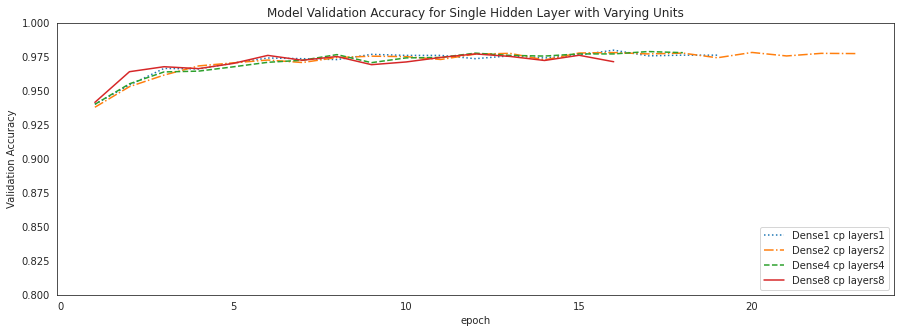

In [ ]:
import itertools
# Plot training accuracies 
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-',':','-.','--','-']
names_cfp = ['Dense' + str(combo[0])  + ' cp layers'+ str(combo[0]) for combo in itertools.product(cnn)]
#epochs_i = np.arange(100) + 1
# Plot validation accuracies 
plt.figure(figsize=(15,5))
for i in range(len(cnn)):
    length = len(history_cfp[i].history['val_sparse_categorical_accuracy'])
    epochs_i = np.arange(length) + 1
    plt.plot(epochs_i, history_cfp[i].history['val_sparse_categorical_accuracy'],linestyle=styles[i])
plt.title('Model Validation Accuracy for Single Hidden Layer with Varying Units')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_cfp, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.80,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

for i in range(len(history_cfp)):
  print('Max Validation Accuracy for '+ names_cfp[i] +' is {0:.4f}'.format(max(history_cfp[i].history['val_sparse_categorical_accuracy'])))
  print('Final Validation Accuracy for '+ names_cfp[i] +
        ' is {0:.4f}'.format(history_cfp[i].history['val_sparse_categorical_accuracy'][len(history_cfp[i].history['val_sparse_categorical_accuracy'])-1]))
  print('')

Max Validation Accuracy for Dense1 cp layers1 is 0.9800
Final Validation Accuracy for Dense1 cp layers1 is 0.9763

Max Validation Accuracy for Dense2 cp layers2 is 0.9783
Final Validation Accuracy for Dense2 cp layers2 is 0.9775

Max Validation Accuracy for Dense4 cp layers4 is 0.9790
Final Validation Accuracy for Dense4 cp layers4 is 0.9782

Max Validation Accuracy for Dense8 cp layers8 is 0.9772
Final Validation Accuracy for Dense8 cp layers8 is 0.9715



* Final base model before batch normalization and dropout: cfpf

#### Batch Normalization/dropout





* Again, we only included the final outputs after trials & errors.

In [ ]:
def cnn_cpdnfndff():
  model = Sequential()
  model.add(Conv2D(filters=32,kernel_size=(3,3), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = None, use_bias = False))
  model.add(MaxPool2D(pool_size=(2,2), strides=None))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units = 64, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(units = 64, activation = 'relu'))
  model.add(Dense(units = 10, activation = 'softmax'))
  return model

In [ ]:
history_cpdnfndff = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 5 times of increase in valid_loss

cpdnfndff = cnn_cpdnfndff()
cpdnfndff.compile(optimizer = tf.keras.optimizers.Adam(), #'adam'
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cpdnfndff = cpdnfndff.fit(x_train, y_train, batch_size = 128, epochs=100, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

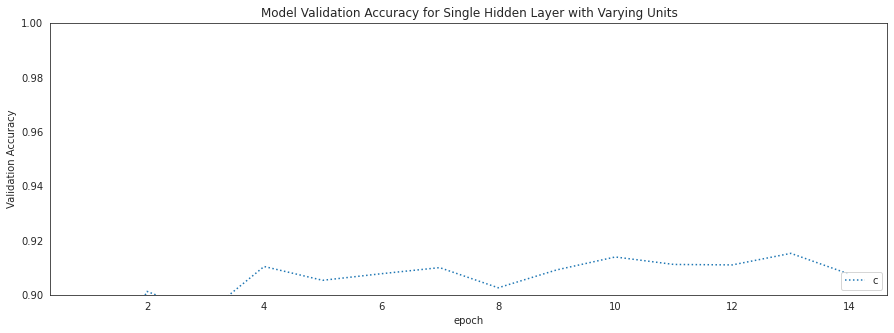

In [ ]:
# Plot validation accuracies 
names_cpdnfndff = 'cpdnfndff model'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cpdnfndff.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cpdnfndff.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for Single Hidden Layer with Varying Units')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_cpdnfndff, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names_cpdnfndff +' is {0:.4f}'.format(max(history_cpdnfndff.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names_cpdnfndff +
      ' is {0:.4f}'.format(history_cpdnfndff.history['val_sparse_categorical_accuracy'][len(history_cpdnfndff.history['val_sparse_categorical_accuracy'])-1]))
print('')

Max Validation Accuracy for cpdnfndff model is 0.9153
Final Validation Accuracy for cpdnfndff model is 0.9076



In [ ]:
def cnn_cpdndfndffdff():
  model = Sequential()
  model.add(Conv2D(filters=32,kernel_size=(3,3), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = None, use_bias = False))
  model.add(MaxPool2D(pool_size=(2,2), strides=None))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(units = 64, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(units = 64, activation = 'relu'))
  model.add(Dense(units = 64, activation = 'relu'))
  model.add(Dropout(0.1))
  model.add(Dense(units = 64, activation = 'relu'))
  model.add(Dense(units = 10, activation = 'softmax'))
  return model

In [ ]:
history_cpdndfndffdff = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 5 times of increase in valid_loss

model = cnn_cpdndfndffdff()
model.compile(optimizer = tf.keras.optimizers.Adam(), #'adam'
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cpdndfndffdff = model.fit(x_train, y_train, batch_size = 128, epochs=100, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

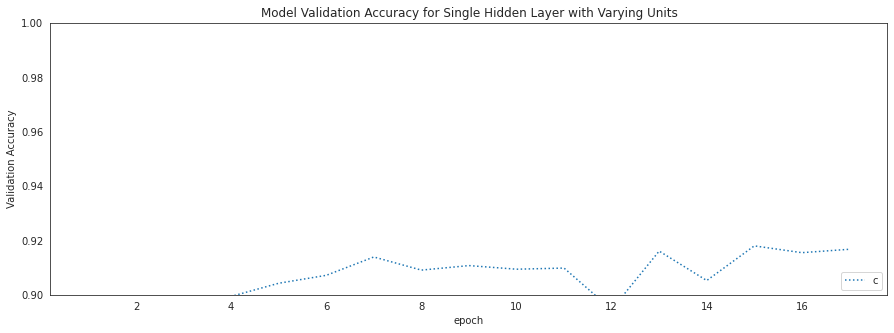

In [ ]:
# Plot validation accuracies 
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']

names_cpdndfndffdff = 'cpdndfndffdff model'

plt.figure(figsize=(15,5))

length = len(history_cpdndfndffdff.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cpdndfndffdff.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for Single Hidden Layer with Varying Units')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_cpdndfndffdff, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names_cpdndfndffdff +' is {0:.4f}'.format(max(history_cpdndfndffdff.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names_cpdndfndffdff +
      ' is {0:.4f}'.format(history_cpdndfndffdff.history['val_sparse_categorical_accuracy'][len(history_cpdndfndffdff.history['val_sparse_categorical_accuracy'])-1]))
print('')

Max Validation Accuracy for cpdndfndffdff model is 0.9180
Final Validation Accuracy for cpdndfndffdff model is 0.9168



In [ ]:
def cnn_cfpdndff():
  model = Sequential()
  model.add(Conv2D(filters=32,kernel_size=(3,3), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = None, use_bias = False))
  model.add(Dense(units = 64, activation = 'relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=None))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(units = 64, activation = 'relu'))
  model.add(Dense(units = 10, activation = 'softmax'))
  return model

In [ ]:
history_cfpdndff = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 5 times of increase in valid_loss

model = cnn_cfpdndff()
model.compile(optimizer = tf.keras.optimizers.Adam(), #'adam'
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cfpdndff = model.fit(x_train, y_train, batch_size = 128, epochs=100, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

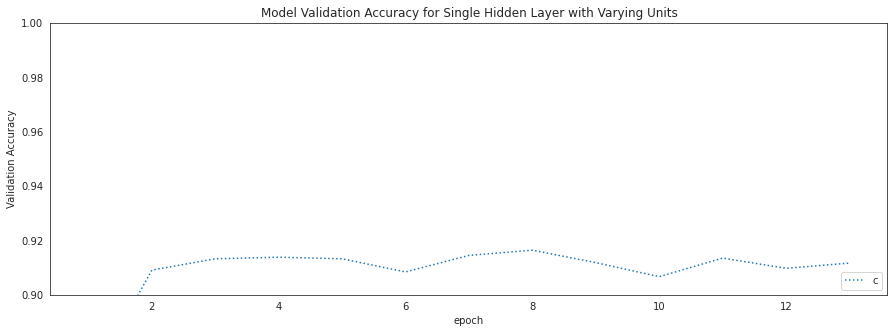

In [ ]:
# Plot validation accuracies 
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']

names_cfpdndff = 'cfpdndff model'

plt.figure(figsize=(15,5))

length = len(history_cfpdndff.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cfpdndff.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for Single Hidden Layer with Varying Units')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_cfpdndff, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names_cfpdndff +' is {0:.4f}'.format(max(history_cfpdndff.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names_cfpdndff +
      ' is {0:.4f}'.format(history_cfpdndff.history['val_sparse_categorical_accuracy'][len(history_cfpdndff.history['val_sparse_categorical_accuracy'])-1]))
print('')

Max Validation Accuracy for cfpdndff model is 0.9164
Final Validation Accuracy for cfpdndff model is 0.9117



Final models in the architecture section are: cfpdndff, cpdnfndff

## Optimization

We take the top 3 performing models from the Architecture segment above and tune with optimization parameters. Here we tested for convolutional layers' filter size and kernel size, dense layers' unit size, maxpooling's pool size, as well as dropout rate. This experiment was repeated for four different optimizers - Adam, Nadam, RMSprop and SGD, followed by a tuning of batch size and number of epochs. 

Nadam did not perform better than Adam for the MNIST dataset, but did better than Adam in one of our models for Fashion MNIST. Compared to MNIST where we chose RMSprop and SGD as optimization algorithms, we found that Nadam and Adam worked best for Fashion MNIST. 

### Model 1 (ccpdnff)

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape((60000, 28, 28, 1))
X_test = X_test.reshape((10000, 28, 28, 1))
X_train, X_test = X_train / 255.0, X_test / 255.0
#y_train, y_test = tf.one_hot(y_train, depth=10),tf.one_hot(y_test, depth=10)

#### Adam

In [ ]:
def build_model_1_adam(hp):
  # create model
  model = Sequential()

  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh', 'sigmoid'], default = None), use_bias = False))
  model.add(Conv2D(filters=hp.Int('conv_2_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_2_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh', 'sigmoid'], default = None), use_bias = False))
  
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=hp.Int('units',64,128, default=128), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))  
  model.add(Dense(10, activation='softmax'))

  # Compile model
  model.compile(optimizer = Adam(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])), #'adam'
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  
  return model

In [ ]:
tuner_adam_1 = kt.Hyperband(build_model_1_adam,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'fashion_mnist_Adam')

In [ ]:
tuner_adam_1.search(X_train,y_train,epochs= 10, validation_split = 0.2)

Trial 30 Complete [00h 01m 15s]
val_sparse_categorical_accuracy: 0.9208333492279053

Best val_sparse_categorical_accuracy So Far: 0.9208333492279053
Total elapsed time: 00h 14m 56s
INFO:tensorflow:Oracle triggered exit


#### Nadam

In [ ]:
def build_model_1_nadam(hp):
  # create model
  model = Sequential()

  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh', 'sigmoid'], default = None), use_bias = False))
  model.add(Conv2D(filters=hp.Int('conv_2_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_2_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh', 'sigmoid'], default = None), use_bias = False))
  
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=hp.Int('units',64,128, default=128), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))  
  model.add(Dense(10, activation='softmax'))

  # Compile model
  model.compile(optimizer = Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  
  return model

In [ ]:
tuner_nadam_1 = kt.Hyperband(build_model_1_nadam,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'fashion_mnist_nadam')

In [ ]:
tuner_nadam_1.search(X_train,y_train,epochs= 10, validation_split = 0.2)

Trial 30 Complete [00h 01m 55s]
val_sparse_categorical_accuracy: 0.715749979019165

Best val_sparse_categorical_accuracy So Far: 0.9180833101272583
Total elapsed time: 00h 19m 01s
INFO:tensorflow:Oracle triggered exit


#### RMSprop

In [ ]:
def build_model_1_rmsprop(hp):
  # create model
  model = Sequential()

  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh', 'sigmoid'], default = None), use_bias = False))
  model.add(Conv2D(filters=hp.Int('conv_2_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_2_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh', 'sigmoid'], default = None), use_bias = False))
  
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=hp.Int('units',64,128, default=128), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))  
  model.add(Dense(10, activation='softmax'))

  # Compile model
  model.compile(optimizer = RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  
  return model

In [ ]:
tuner_rms_1 = kt.Hyperband(build_model_1_rmsprop,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'fashion_mnist_rms')

In [ ]:
tuner_rms_1.search(X_train,y_train,epochs= 10, validation_split = 0.2)

Trial 30 Complete [00h 01m 15s]
val_sparse_categorical_accuracy: 0.9137499928474426

Best val_sparse_categorical_accuracy So Far: 0.9169166684150696
Total elapsed time: 00h 15m 24s
INFO:tensorflow:Oracle triggered exit


#### SGD

In [ ]:
def build_model_1_sgd(hp):
  # create model
  model = Sequential()

  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh', 'sigmoid'], default = None), use_bias = False))
  model.add(Conv2D(filters=hp.Int('conv_2_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_2_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu', 'tanh', 'sigmoid'], default = None), use_bias = False))
  
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=hp.Int('units',64,128, default=128), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))  
  model.add(Dense(10, activation='softmax'))

  # Compile model
  model.compile(optimizer = SGD(hp.Choice('learning_rate', values=[1e-1,1e-2,1e-3])),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  
  return model

In [ ]:
tuner_sgd_1 = kt.Hyperband(build_model_1_sgd,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'fashion_mnist_SGD')

In [ ]:
tuner_sgd_1.search(X_train,y_train,epochs= 10, validation_split = 0.2)

Trial 30 Complete [00h 01m 04s]
val_sparse_categorical_accuracy: 0.8648333549499512

Best val_sparse_categorical_accuracy So Far: 0.9180833101272583
Total elapsed time: 00h 13m 11s
INFO:tensorflow:Oracle triggered exit


#### Keras Tuner over best optimizer for batch size/number of epochs (ccpdnff model w/ Adam)

In [ ]:
import IPython

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
class MyTuner(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 256, step=32)
    kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 30)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

# Uses same arguments as the BayesianOptimization Tuner.
# tuner_nadam = kt.Hyperband(build_model,
#                      objective = 'val_sparse_categorical_accuracy', 
#                      max_epochs = 10,
#                      factor = 3,
#                      directory = 'my_dir',
#                      project_name = 'mnist2')
tuner_1 = MyTuner(build_model_1_adam,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_trials = 30,
                    #  factor = 3,
                     directory = 'my_dir',
                     project_name = 'fashion_mnist_best')
# Don't pass epochs or batch_size here, let the Tuner tune them.
# tuner_nadam.search(train_images,train_labels,epochs= 10, validation_split = 0.2,callbacks = [ClearTrainingOutput()])
tuner_1.search(X_train,y_train, validation_split = 0.2,callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 01m 40s]
val_sparse_categorical_accuracy: 0.9292500019073486

Best val_sparse_categorical_accuracy So Far: 0.9326666593551636
Total elapsed time: 00h 53m 33s
INFO:tensorflow:Oracle triggered exit


### Model 2 (cfpdndff)

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu'], default = None), use_bias = False))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.1))
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.1))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))
  # model.add(BatchNormalization())
  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(Dense(units = 10, activation = 'softmax'))

  model.compile(optimizer = Adam(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4,1e-5])), #'adam'
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

#### Adam

In [ ]:
tuner_adam3 = kt.Hyperband(build_model,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'adam__')

tuner_adam3.search(x_train,y_train,epochs= 20, validation_split = 0.2,callbacks = [ClearTrainingOutput()])


Trial 11 Complete [00h 00m 59s]
val_sparse_categorical_accuracy: 0.9258333444595337

Best val_sparse_categorical_accuracy So Far: 0.9258333444595337
Total elapsed time: 00h 07m 54s
INFO:tensorflow:Oracle triggered exit


#### Nadam

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu'], default = None), use_bias = False))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.1))
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.1))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))
  # model.add(BatchNormalization())
  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(Dense(units = 10, activation = 'softmax'))

  model.compile(optimizer = Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4,1e-5])), #Nadam
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
tuner_nadam3 = kt.Hyperband(build_model,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'nadam__')

tuner_nadam3.search(x_train,y_train,epochs= 20, validation_split = 0.2,callbacks = [ClearTrainingOutput()])


Trial 30 Complete [00h 01m 55s]
val_sparse_categorical_accuracy: 0.9240833520889282

Best val_sparse_categorical_accuracy So Far: 0.9287499785423279
Total elapsed time: 00h 18m 22s
INFO:tensorflow:Oracle triggered exit


#### RMSprop

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu'], default = None), use_bias = False))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.1))
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.1))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))
  # model.add(BatchNormalization())
  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(Dense(units = 10, activation = 'softmax'))

  model.compile(optimizer = RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4,1e-5])), #RMSprop
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
tuner_rms3 = kt.Hyperband(build_model,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'rms__')

tuner_rms3.search(x_train,y_train,epochs= 20, validation_split = 0.2,callbacks = [ClearTrainingOutput()])


Trial 30 Complete [00h 01m 16s]
val_sparse_categorical_accuracy: 0.9214166402816772

Best val_sparse_categorical_accuracy So Far: 0.9236666560173035
Total elapsed time: 00h 14m 30s
INFO:tensorflow:Oracle triggered exit


#### SGD

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu'], default = None), use_bias = False))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.1))
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.1))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))
  # model.add(BatchNormalization())
  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(Dense(units = 10, activation = 'softmax'))

  model.compile(optimizer = SGD(hp.Choice('learning_rate', values=[1e-1,1e-2,1e-3,1e-4])),
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
tuner_sgd3 = kt.Hyperband(build_model,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'sgd__')

tuner_sgd3.search(x_train,y_train,epochs= 20, validation_split = 0.2,callbacks = [ClearTrainingOutput()])


Trial 30 Complete [00h 01m 21s]
val_sparse_categorical_accuracy: 0.8616666793823242

Best val_sparse_categorical_accuracy So Far: 0.918749988079071
Total elapsed time: 00h 12m 38s
INFO:tensorflow:Oracle triggered exit


#### Keras Tuner over best optimizer for batch size/number of epochs (cfpdndff model w/ Nadam)

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu'], default = None), use_bias = False))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.1))
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu'], default='relu')))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.1))
  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))
  # model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu'], default='relu')))
  model.add(Dense(units = 10, activation = 'softmax'))

  model.compile(optimizer = Nadam(hp.Choice('learning_rate', values=[1e-3,1e-4])), #'adam'
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
class MyTuner(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 256, step=32)
    kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 50)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20) #we accept 5 times of increase in valid_loss

tuner = MyTuner(build_model,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_trials = 50,
                    #  factor = 3,
                     directory = 'my_dir',
                     project_name = 'Nadam6')
# Don't pass epochs or batch_size here, let the Tuner tune them.
# tuner_nadam.search(train_images,train_labels,epochs= 10, validation_split = 0.2,callbacks = [ClearTrainingOutput()])
tuner.search(x_train,y_train, validation_split = 0.2,callbacks = [ClearTrainingOutput(), early_stopping_cb])

Trial 28 Complete [00h 03m 09s]
val_sparse_categorical_accuracy: 0.9269166588783264

Best val_sparse_categorical_accuracy So Far: 0.9300000071525574
Total elapsed time: 00h 57m 07s

Search: Running Trial #29

Hyperparameter    |Value             |Best Value So Far 
conv_1_filter     |48                |112               
conv_1_kernel     |5                 |3                 
activation        |relu              |relu              
units             |112               |112               
dense_activation  |relu              |relu              
pool_size         |2                 |2                 
learning_rate     |0.001             |0.0001            
batch_size        |224               |256               
epochs            |45                |36                

Epoch 1/45
215/215 [==============================] - 6s 25ms/step - loss: 0.6125 - sparse_categorical_accuracy: 0.8077 - val_loss: 1.7030 - val_sparse_categorical_accuracy: 0.7528
Epoch 2/45
215/215 [===================

### Model 3 (cpdnfndff)

In [ ]:
def cnn_cpdnfndf():
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('dense_activation', values = ['relu'], default = None), use_bias = False))

  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(BatchNormalization())
  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(Dense(units = 10, activation = 'softmax'))
  return model

#### Adam

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu'], default = None), use_bias = False))

  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(BatchNormalization())
  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(Dense(units = 10, activation = 'softmax'))

  model.compile(optimizer = Adam(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4,1e-5])), #'adam'
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
tuner_adam = kt.Hyperband(build_model,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'Adam1')
tuner_adam.search(X_train,y_train,epochs= 20, validation_split = 0.2,callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 00m 54s]
val_sparse_categorical_accuracy: 0.92208331823349

Best val_sparse_categorical_accuracy So Far: 0.92208331823349
Total elapsed time: 00h 11m 22s
INFO:tensorflow:Oracle triggered exit


#### Nadam

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu'], default = None), use_bias = False))

  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(BatchNormalization())
  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(Dense(units = 10, activation = 'softmax'))

  model.compile(optimizer = Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4,1e-5])), #Nadam
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
import kerastuner as kt
tuner_nadam = kt.Hyperband(build_model,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'Nadam4')
tuner_nadam.search(x_train,y_train,epochs= 10, validation_split = 0.2,callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 01m 15s]
val_sparse_categorical_accuracy: 0.9175833463668823

Best val_sparse_categorical_accuracy So Far: 0.9201666712760925
Total elapsed time: 00h 16m 02s
INFO:tensorflow:Oracle triggered exit


#### RMSprop

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu'], default = None), use_bias = False))

  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(BatchNormalization())
  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(Dense(units = 10, activation = 'softmax'))

  model.compile(optimizer = RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4,1e-5])), #RMSprop
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
tuner_rms = kt.Hyperband(build_model,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'RMS4')
tuner_rms.search(x_train,y_train,epochs= 10, validation_split = 0.2,callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 01m 02s]
val_sparse_categorical_accuracy: 0.8102499842643738

Best val_sparse_categorical_accuracy So Far: 0.9242500066757202
Total elapsed time: 00h 12m 55s
INFO:tensorflow:Oracle triggered exit


#### SGD

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu'], default = None), use_bias = False))

  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(BatchNormalization())
  model.add(Dropout(hp.Float('dropout',0.1,0.3,0.5,default=0.5)))
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu', 'tanh'], default='relu')))
  model.add(Dense(units = 10, activation = 'softmax'))

  model.compile(optimizer = SGD(hp.Choice('learning_rate', values=[1e-1,1e-2,1e-3,1e-4])),
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
tuner_sgd = kt.Hyperband(build_model,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'SGD2')
tuner_sgd.search(x_train,y_train,epochs= 10, validation_split = 0.2,callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 00m 52s]
val_sparse_categorical_accuracy: 0.8634166717529297

Best val_sparse_categorical_accuracy So Far: 0.9155833125114441
Total elapsed time: 00h 10m 36s
INFO:tensorflow:Oracle triggered exit


#### Keras Tuner over best optimizer for batch size/number of epochs (cpdnfndff model with RMS)

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16),
                   kernel_size= hp.Choice('conv_1_kernel', values = [3,5]), strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = hp.Choice('activation', values = ['relu'], default = None), use_bias = False))

  model.add(MaxPooling2D(pool_size=hp.Int('pool_size',2,3,5,default=2), strides=None))

  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu'], default='relu')))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(units=hp.Int('units', min_value = 32, max_value = 128, step = 16), 
                  activation=hp.Choice('dense_activation', values=['relu'], default='relu')))
  model.add(Dense(units = 10, activation = 'softmax'))

  model.compile(optimizer = RMSprop(hp.Choice('learning_rate', values=[1e-3,1e-4])), #RMSprop
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

In [ ]:
class MyTuner(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 256, step=32)
    kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 50)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20) #we accept 5 times of increase in valid_loss

tuner = MyTuner(build_model,
                     objective = 'val_sparse_categorical_accuracy', 
                     max_trials = 30,
                    #  factor = 3,
                     directory = 'my_dir',
                     project_name = 'mnist8')
# Don't pass epochs or batch_size here, let the Tuner tune them.
# tuner_nadam.search(train_images,train_labels,epochs= 10, validation_split = 0.2,callbacks = [ClearTrainingOutput()])
tuner.search(x_train,y_train, validation_split = 0.2,callbacks = [ClearTrainingOutput(), early_stopping_cb])

Trial 30 Complete [00h 00m 34s]
val_sparse_categorical_accuracy: 0.9212499856948853

Best val_sparse_categorical_accuracy So Far: 0.9253333210945129
Total elapsed time: 00h 28m 16s
INFO:tensorflow:Oracle triggered exit


## Initialization

In this section, we investigated the following initialization/activation pairs that have become popular in machine learning practice: default Keras initialization (Glorot uniform) with ReLU, He with ReLU, Lecun with tanh, Standard Normal with ReLU, and Variance scaling with ReLU. We have found that the default initialization with ReLU is consistently one of the top settings.

In [ ]:
# Load data 
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))
# Normalize data x
x_train, x_test = tf.cast(x_train,dtype=tf.float32)/255.0, tf.cast(x_test,dtype=tf.float32)/255.0
# y_train, y_test = tf.one_hot(y_train, depth=10),tf.one_hot(y_test, depth=10)
print(f'Train data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

4423680/4422102 [==============================] - 0s 0us/step
Train data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


### Model 1 (ccpdnff model w/ Adam)

We use the same format as in MNIST to find the best initialization. Ultimately, we found that the default initialization worked best.

In [ ]:
def ccpdnff_adam():
  # create model
  model = Sequential()

  model.add(Conv2D(input_shape = (28,28,1),filters=32,kernel_size=(3,3),activation='relu',padding='same',use_bias = False))
  model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu',padding='same', use_bias = False))
  
  model.add(MaxPooling2D(pool_size=(2,2), strides=None))

  model.add(Dropout(0.1))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=128, activation='sigmoid'))  
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer = Adam(learning_rate=0.0001),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  
  return model

In [ ]:
def ccpdnff_adam_activation(initializer,activation_fn):
  # create model
  model = Sequential()

  model.add(Conv2D(input_shape = (28,28,1),filters=32,kernel_size=(5,5),activation=activation_fn,padding='same',use_bias = False,kernel_initializer=initializer))
  model.add(Conv2D(filters=128,kernel_size=(5,5),activation=activation_fn,padding='same', use_bias = False,kernel_initializer=initializer))
  
  model.add(MaxPooling2D(pool_size=(2,2), strides=None))

  model.add(Dropout(0.1))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=128, activation=activation_fn,kernel_initializer=initializer))  
  model.add(Dense(10, activation='softmax',kernel_initializer=initializer))

  model.compile(optimizer = Adam(learning_rate=0.0001),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  
  return model

In [ ]:
fashion_val_acc_1 = {}

#### Default (Glorot uniform)

In [ ]:
#best batch size is 32, best number of epochs is 30

model = ccpdnff_adam()
history_ccpdnff_default = model.fit(x_train,y_train,batch_size=32,epochs=30,validation_split=0.2,verbose=0)


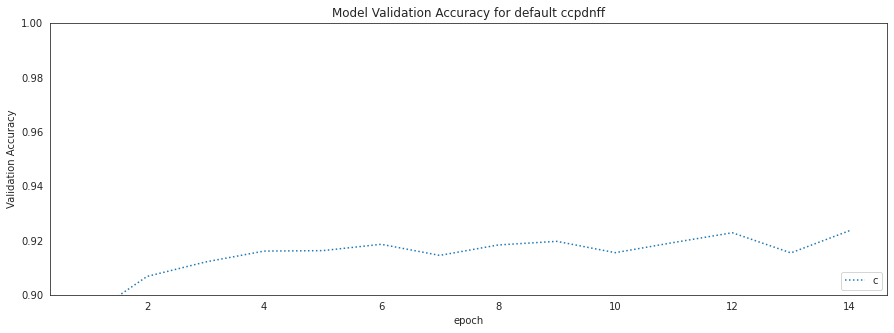

In [ ]:
# Plot validation accuracies 
names = 'ccpdnff default model'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_ccpdnff.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_ccpdnff.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for default ccpdnff')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_ccpdnff_default.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_ccpdnff_default.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_default.history['val_sparse_categorical_accuracy'])-1]))
print('')
fashion_val_acc_1['default initialization']=history_ccpdnff_default.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_default.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for ccpdnff default model is 0.9319
Final Validation Accuracy for ccpdnff default model is 0.9298



#### He with Relu activation

In [ ]:
he_initializer = tf.keras.initializers.HeNormal()
history_ccpdnff_he = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model = ccpdnff_adam_activation(he_initializer, 'relu')

history_ccpdnff_he = model.fit(x_train,y_train, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

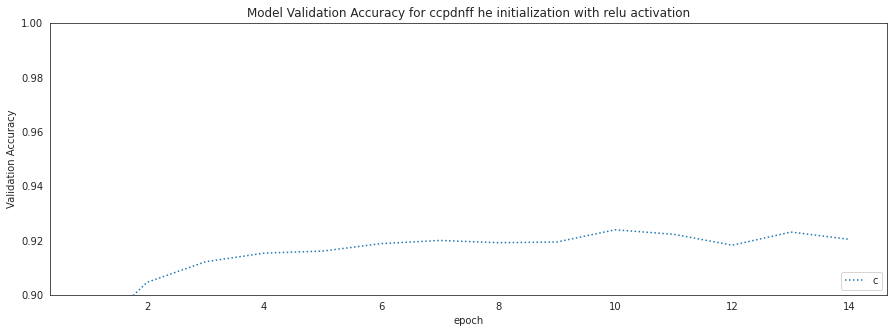

In [ ]:
# Plot validation accuracies 
names = 'ccpdnff model he initialization with relu activation'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_ccpdnff_he.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_ccpdnff_he.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for ccpdnff he initialization with relu activation')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case
print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_ccpdnff_he.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_ccpdnff_he.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_he.history['val_sparse_categorical_accuracy'])-1]))
print('')
fashion_val_acc_1['he with relu']=history_ccpdnff_he.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_he.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for ccpdnff model he initialization with relu activation is 0.9239
Final Validation Accuracy for ccpdnff model he initialization with relu activation is 0.9204



#### Lecun initialization with tanh activation

In [ ]:
lecun_initializer = tf.keras.initializers.LecunNormal()
history_ccpdnff_lecun = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model = ccpdnff_adam_activation(lecun_initializer, 'tanh')

history_ccpdnff_lecun = model.fit(x_train,y_train, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

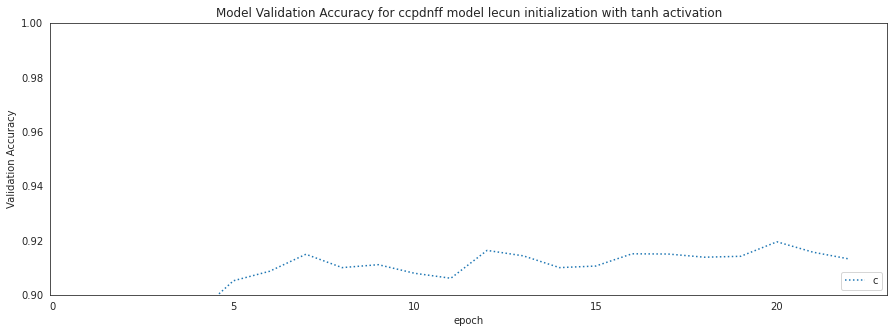

In [ ]:
# Plot validation accuracies 
names = 'ccpdnff model lecun initialization with tanh activation'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_ccpdnff_lecun.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_ccpdnff_lecun.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for ccpdnff model lecun initialization with tanh activation')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_ccpdnff_lecun.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_ccpdnff_lecun.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_lecun.history['val_sparse_categorical_accuracy'])-1]))
print('')
fashion_val_acc_1['lecun with tanh']=history_ccpdnff_lecun.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_lecun.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for ccpdnff model lecun initialization with tanh activation is 0.9195
Final Validation Accuracy for ccpdnff model lecun initialization with tanh activation is 0.9132



#### Standard normal with Relu activation

In [ ]:
std_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
history_ccpdnff_std = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model = ccpdnff_adam_activation(std_initializer, 'relu')

history_ccpdnff_std = model.fit(x_train,y_train, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

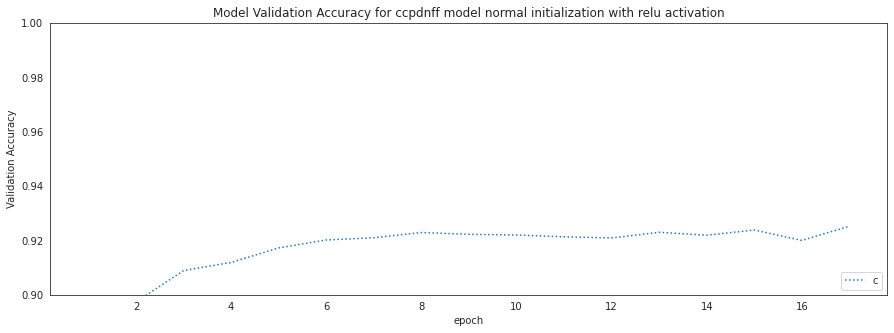

In [ ]:
# Plot validation accuracies 
names = 'ccpdnff model normal initialization with relu activation'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_ccpdnff_std.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_ccpdnff_std.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for ccpdnff model normal initialization with relu activation')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_ccpdnff_std.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_ccpdnff_std.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_std.history['val_sparse_categorical_accuracy'])-1]))
print('')
fashion_val_acc_1['std normal with relu']=history_ccpdnff_std.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_std.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for ccpdnff model normal initialization with relu activation is 0.9252
Final Validation Accuracy for ccpdnff model normal initialization with relu activation is 0.9252



#### Variance scaling with Relu activation

In [ ]:

variance_scaling_initializer = tf.keras.initializers.VarianceScaling(
    scale=1.0, mode="fan_in", distribution="truncated_normal", seed=None
)
history_ccpdnff_variance_scaling = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #we accept 10 times of increase in valid_loss

model = ccpdnff_adam_activation(variance_scaling_initializer, 'relu')

history_ccpdnff_variance_scaling = model.fit(x_train,y_train, batch_size = 32, epochs=30, validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 0)

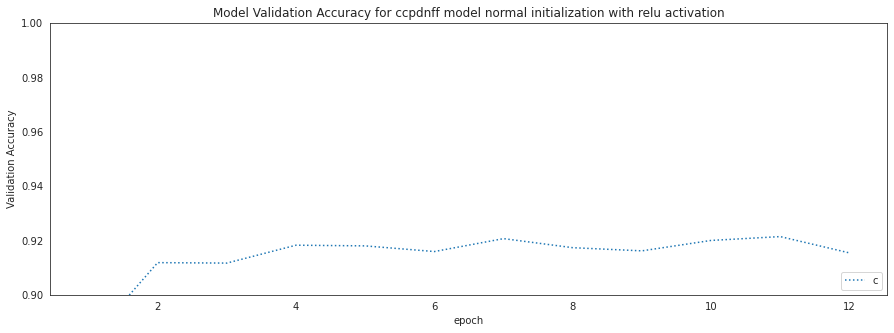

In [ ]:
# Plot validation accuracies 
names = 'ccpdnff model variance scaling initialization with relu activation'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_ccpdnff_variance_scaling.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_ccpdnff_variance_scaling.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for ccpdnff model normal initialization with relu activation')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names +' is {0:.4f}'.format(max(history_ccpdnff_variance_scaling.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names +
      ' is {0:.4f}'.format(history_ccpdnff_variance_scaling.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_variance_scaling.history['val_sparse_categorical_accuracy'])-1]))
print('')
fashion_val_acc_1['variance scaling with relu']=history_ccpdnff_variance_scaling.history['val_sparse_categorical_accuracy'][len(history_ccpdnff_variance_scaling.history['val_sparse_categorical_accuracy'])-1]

Max Validation Accuracy for ccpdnff model variance scaling initialization with relu activation is 0.9214
Final Validation Accuracy for ccpdnff model variance scaling initialization with relu activation is 0.9154



#### Putting it all together

We see that the default initialization performs best.

In [ ]:
sorted_accuracy_list=sorted(fashion_val_acc_1,key=fashion_val_acc_1.get)[::-1]

In [ ]:
for i in sorted_accuracy_list:
  print(str(i)+': '+str('{0:.4f}').format(fashion_val_acc_1[i]))

default initialization: 0.9298
std normal with relu: 0.9252
he with relu: 0.9204
variance scaling with relu: 0.9154
lecun with tanh: 0.9132


### Model 2 & 3 (cfpdndff model w/ Nadam & cpdnfndff model with RMS)

It follows the same format as in MNIST. We found that the default initialization worked best for models 2 and 3.

#### Default (Xavier/Glorot uniform)

In [ ]:
def cfpdndf_nadam():
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=112,
                   kernel_size= 3, strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = 'relu', use_bias = False))
  model.add(Dense(units=112, 
                  activation='relu'))

  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(units=112, 
                  activation='relu'))
  model.add(Dense(units = 10, activation = 'softmax'))

  
  return model

In [ ]:
history_cfpdndf = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=30) #we accept 10 times of increase in valid_loss
model = cfpdndf_nadam()
model.compile(optimizer = Nadam(learning_rate=1e-4), 
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cfpdndf = model.fit(x_train, y_train, batch_size = 256, epochs=32, #callbacks=[early_stopping_cb],
                            validation_split = 0.2, verbose = 0)

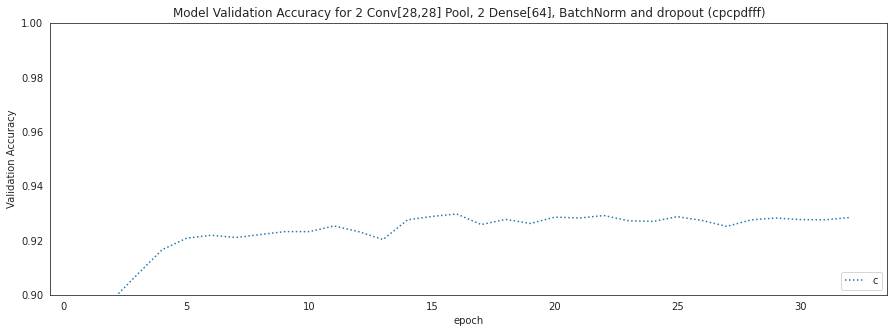

In [ ]:
# Plot validation accuracies 
names_cfpdndf = 'cfpdndf model'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cfpdndf.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cfpdndf.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for 2 Conv[28,28] Pool, 2 Dense[64], BatchNorm and dropout (cpcpdfff)')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_cfpdndf, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case
names_cfpdndf = 'cfpdndf model'

print('Max Validation Accuracy for '+ names_cfpdndf +' is {0:.4f}'.format(max(history_cfpdndf.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names_cfpdndf +
      ' is {0:.4f}'.format(history_cfpdndf.history['val_sparse_categorical_accuracy'][len(history_cfpdndf.history['val_sparse_categorical_accuracy'])-1]))
print('')

Max Validation Accuracy for cfpdndf model is 0.9298
Final Validation Accuracy for cfpdndf model is 0.9284



In [ ]:
def cpdnfndf_rms():
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=112,
                   kernel_size= 5, strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = 'relu'))

  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=80, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(units=80, 
                  activation='relu'))
  model.add(Dense(units = 10, activation = 'softmax'))

  
  return model

In [ ]:
history_cpdnfndf = []
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20) 
model = cpdnfndf_rms()

model.compile(optimizer = RMSprop(learning_rate=1e-4), #RMSprop
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cpdnfndf = model.fit(x_train, y_train, batch_size = 256, epochs=32,
                                 validation_split = 0.2, verbose = 0)

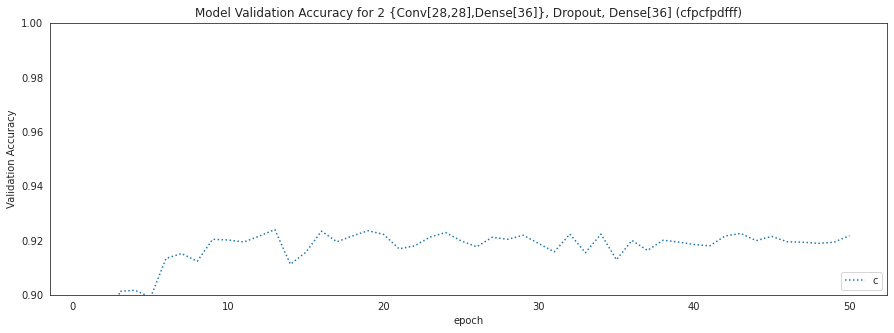

In [ ]:
# Plot validation accuracies 
names_cpdnfndf  = 'cpdnfndf model'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cpdnfndf.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cpdnfndf.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for 2 {Conv[28,28],Dense[36]}, Dropout, Dense[36] (cfpcfpdfff)')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_cpdnfndf, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names_cpdnfndf +
      ' is {0:.4f}'.format(max(history_cpdnfndf.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names_cpdnfndf +
      ' is {0:.4f}'.format(history_cpdnfndf.history['val_sparse_categorical_accuracy'][len(history_cpdnfndf.history['val_sparse_categorical_accuracy'])-1]))
print('')

Max Validation Accuracy for cpdnfndf model is 0.9240
Final Validation Accuracy for cpdnfndf model is 0.9218



In [ ]:
# helper function to get initializer function from keras
def get_init_fn(init_fn_name):
  if init_fn_name == 'he':
    return tf.keras.initializers.HeNormal()
  elif init_fn_name == 'lecun':
    return tf.keras.initializers.LecunNormal()
  elif init_fn_name == 'std':
    return tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
  elif init_fn_name == 'varscaling':
    return tf.keras.initializers.VarianceScaling(scale=1.0, mode="fan_in", distribution="truncated_normal", seed=None)
  else:  # init_fn_name == 'xavier' / default in keras
    return tf.keras.initializers.GlorotNormal()

In [ ]:
# helper function to build model based on the model name, initialization and activation specified 
def model_init_specs(model_name, init_fn_name, activation_fn):
  init_fn = get_init_fn(init_fn_name)
  model = Sequential()
  if model_name == 'cfpdndf_nadam':
    model.add(Conv2D(input_shape = (28,28,1),filters=128,
                    kernel_size= 3, strides= 1,
                              padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                              kernel_initializer=init_fn, activation = activation_fn, use_bias = False))
    model.add(Dense(units=128, 
                    activation='relu'))

    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(units=128, kernel_initializer=init_fn, activation = activation_fn))
    model.add(Dense(units = 10, activation = 'softmax'))


  elif model_name == 'cpdnfndf_rms':
    model.add(Conv2D(input_shape = (28,28,1),filters=112,
                   kernel_size= 5, strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            kernel_initializer=init_fn, activation = activation_fn))

    model.add(MaxPooling2D(pool_size=2, strides=None))

    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(units=80, kernel_initializer=init_fn, activation = activation_fn))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(units=80, kernel_initializer=init_fn, activation = activation_fn))
    model.add(Dense(units = 10, activation = 'softmax'))
  return model

In [ ]:
# train and evaluate model with initialization and activation specfied 
# returns model and history 
def model_eval(model_name, init_fn_name, activation_fn):
  history = []
  model = model_init_specs(model_name, init_fn_name, activation_fn)
  if model_name == 'cfpdndf_nadam':
    model = cfpdndf_nadam()
    model.compile(optimizer = Nadam(learning_rate=1e-4), 
                                                                #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                                #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                                #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
    history = model.fit(x_train, y_train, batch_size = 256, epochs=32, 
                                validation_split = 0.2, verbose = 0)
    
  elif model_name == 'cpdnfndf_rms':
    model = cpdnfndf_rms()

    model.compile(optimizer = RMSprop(learning_rate=1e-4), #RMSprop
                                                                #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                                #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                                #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
    history = model.fit(x_train, y_train, batch_size = 256, epochs=32, validation_split = 0.2, verbose = 0)
  

  # Plot validation accuracies
  styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']
  length = len(history.history['val_sparse_categorical_accuracy'])
  epochs_i = np.arange(length) + 1
  model_and_specs = model_name+' w/ '+init_fn_name+' Initialization and '+activation_fn+' Activation'

  plt.figure(figsize=(15,5))
  plt.plot(epochs_i, history.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
  plt.title('Model Validation Accuracy for '+ model_and_specs)
  plt.ylabel('Validation Accuracy')
  plt.xlabel('epoch')
  axes = plt.gca()
  axes.set_ylim([0.90,1])
  plt.show()

  # Max validation accuracy per model for both case
  print('Max Validation Accuracy for '+ model_and_specs +' is {0:.4f}'.format(max(history.history['val_sparse_categorical_accuracy'])))
  print('Final Validation Accuracy for '+ model_and_specs +
        ' is {0:.4f}'.format(history.history['val_sparse_categorical_accuracy'][len(history.history['val_sparse_categorical_accuracy'])-1]))
  print('')

  return model, history

#### Xavier (Glorot) initialization

* with tanh activation

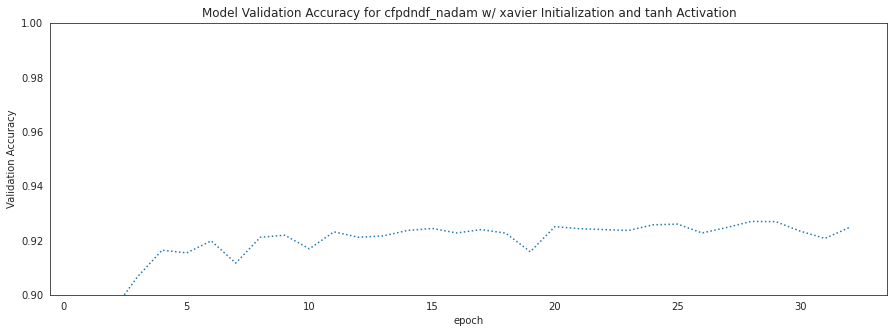

Max Validation Accuracy for cfpdndf_nadam w/ xavier Initialization and tanh Activation is 0.9270
Final Validation Accuracy for cfpdndf_nadam w/ xavier Initialization and tanh Activation is 0.9247

INFO:tensorflow:Assets written to: cfpdndf_nadam_xavier_tanh/assets


In [ ]:
model_cfpdndf_nadam_xavier_tanh, history_cfpdndf_nadam_xavier_tanh = model_eval(model_name='cfpdndf_nadam', init_fn_name='xavier', activation_fn='tanh')
model_cfpdndf_nadam_xavier_tanh.save('cfpdndf_nadam_xavier_tanh')

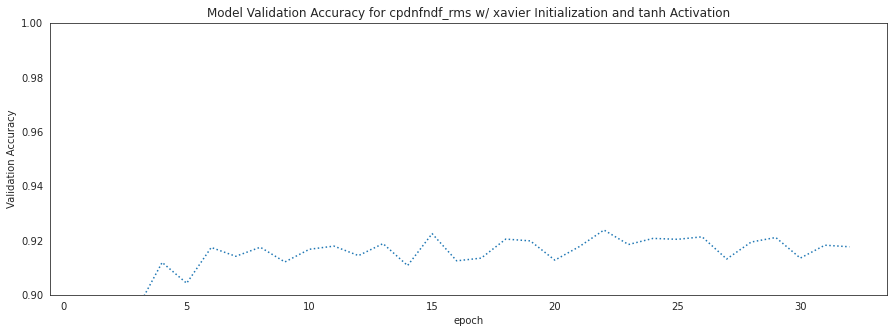

Max Validation Accuracy for cpdnfndf_rms w/ xavier Initialization and tanh Activation is 0.9238
Final Validation Accuracy for cpdnfndf_rms w/ xavier Initialization and tanh Activation is 0.9177

INFO:tensorflow:Assets written to: cpdnfndf_rms_xavier_tanh/assets


In [ ]:
model_cpdnfndf_rms_xavier_tanh, history_cpdnfndf_rms_xavier_tanh = model_eval(model_name='cpdnfndf_rms', init_fn_name='xavier', activation_fn='tanh')
model_cpdnfndf_rms_xavier_tanh.save('cpdnfndf_rms_xavier_tanh')

* with relu activation

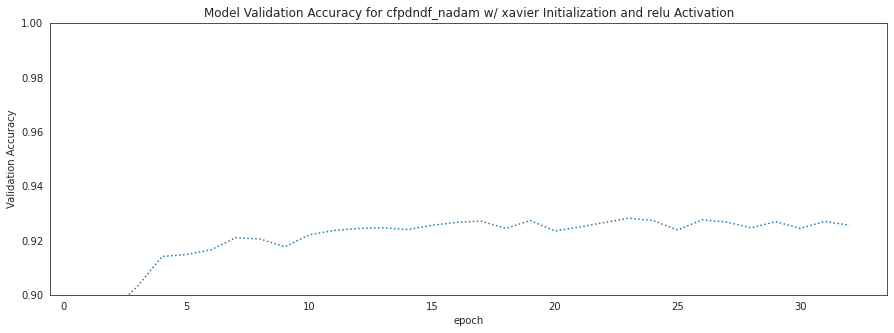

Max Validation Accuracy for cfpdndf_nadam w/ xavier Initialization and relu Activation is 0.9282
Final Validation Accuracy for cfpdndf_nadam w/ xavier Initialization and relu Activation is 0.9256

INFO:tensorflow:Assets written to: cfpdndf_nadam_xavier_relu/assets


In [ ]:
model_cfpdndf_nadam_xavier_relu, history_cfpdndf_nadam_xavier_relu = model_eval(model_name='cfpdndf_nadam', init_fn_name='xavier', activation_fn='relu')
model_cfpdndf_nadam_xavier_relu.save('cfpdndf_nadam_xavier_relu')

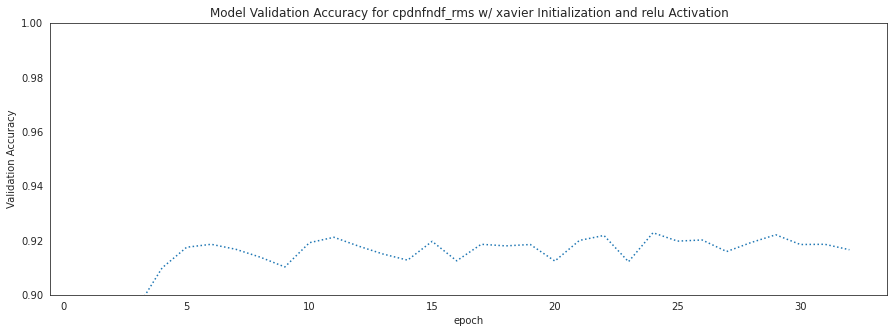

Max Validation Accuracy for cpdnfndf_rms w/ xavier Initialization and relu Activation is 0.9228
Final Validation Accuracy for cpdnfndf_rms w/ xavier Initialization and relu Activation is 0.9166

INFO:tensorflow:Assets written to: cpdnfndf_rms_xavier_relu/assets


In [ ]:
model_cpdnfndf_rms_xavier_relu, history_cpdnfndf_rms_xavier_relu = model_eval(model_name='cpdnfndf_rms', init_fn_name='xavier', activation_fn='relu')
model_cpdnfndf_rms_xavier_relu.save('cpdnfndf_rms_xavier_relu')

#### He Initialization with ReLU activations

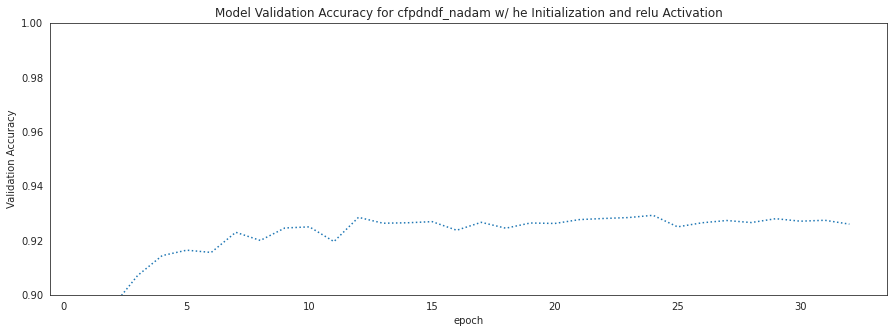

Max Validation Accuracy for cfpdndf_nadam w/ he Initialization and relu Activation is 0.9293
Final Validation Accuracy for cfpdndf_nadam w/ he Initialization and relu Activation is 0.9260

INFO:tensorflow:Assets written to: cfpdndf_nadam_he_relu/assets


In [ ]:
model_cfpdndf_nadam_he_relu, history_cfpdndf_nadam_he_relu = model_eval(model_name='cfpdndf_nadam', init_fn_name='he', activation_fn='relu')
model_cfpdndf_nadam_he_relu.save('cfpdndf_nadam_he_relu')

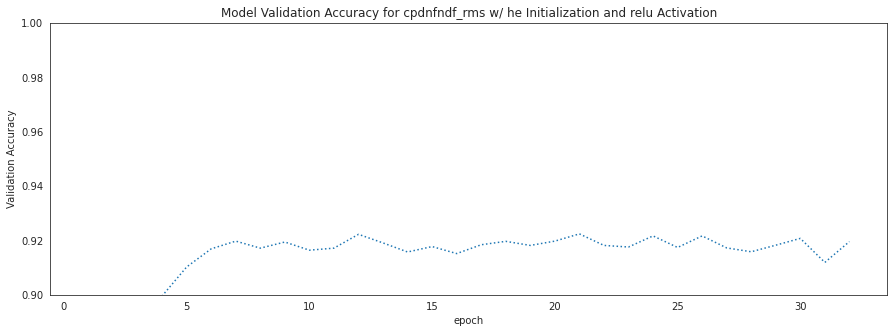

Max Validation Accuracy for cpdnfndf_rms w/ he Initialization and relu Activation is 0.9224
Final Validation Accuracy for cpdnfndf_rms w/ he Initialization and relu Activation is 0.9196

INFO:tensorflow:Assets written to: cpdnfndf_rms_he_relu/assets


In [ ]:
model_cpdnfndf_rms_he_relu, history_cpdnfndf_he_relu = model_eval(model_name='cpdnfndf_rms', init_fn_name='he', activation_fn='relu')
model_cpdnfndf_rms_he_relu.save('cpdnfndf_rms_he_relu')

#### Lecun initialization

* tanh activation

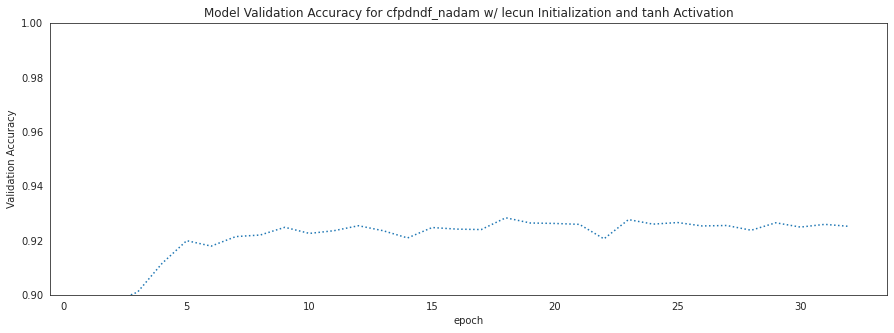

Max Validation Accuracy for cfpdndf_nadam w/ lecun Initialization and tanh Activation is 0.9283
Final Validation Accuracy for cfpdndf_nadam w/ lecun Initialization and tanh Activation is 0.9252

INFO:tensorflow:Assets written to: cfpdndf_nadam_lecun_tanh/assets


In [ ]:
model_cfpdndf_nadam_lecun_tanh, history_cfpdndf_nadam_lecun_tanh = model_eval(model_name='cfpdndf_nadam', init_fn_name='lecun', activation_fn='tanh')
model_cfpdndf_nadam_lecun_tanh.save('cfpdndf_nadam_lecun_tanh')

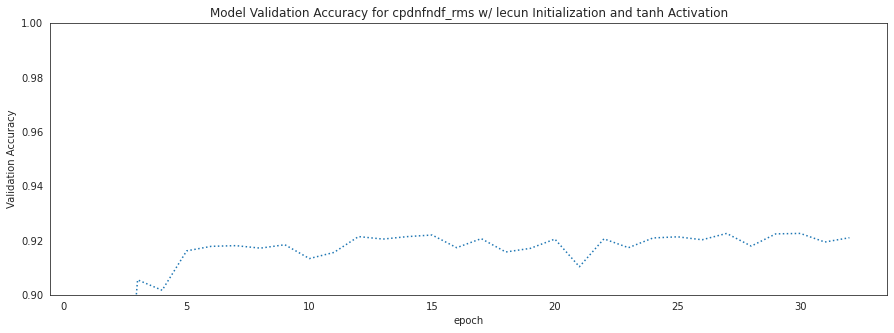

Max Validation Accuracy for cpdnfndf_rms w/ lecun Initialization and tanh Activation is 0.9226
Final Validation Accuracy for cpdnfndf_rms w/ lecun Initialization and tanh Activation is 0.9210

INFO:tensorflow:Assets written to: cpdnfndf_rms_lecun_tanh/assets


In [ ]:
model_cpdnfndf_rms_lecun_tanh, history_cpdnfndf_lecun_tanh = model_eval(model_name='cpdnfndf_rms', init_fn_name='lecun', activation_fn='tanh')
model_cpdnfndf_rms_lecun_tanh.save('cpdnfndf_rms_lecun_tanh')

* selu activation

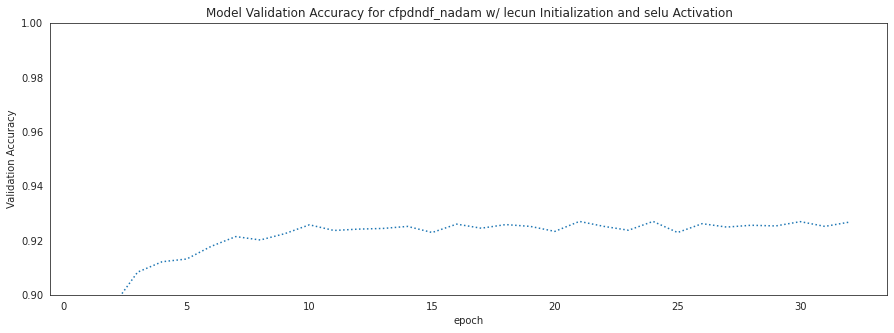

Max Validation Accuracy for cfpdndf_nadam w/ lecun Initialization and selu Activation is 0.9270
Final Validation Accuracy for cfpdndf_nadam w/ lecun Initialization and selu Activation is 0.9268

INFO:tensorflow:Assets written to: cfpdndf_nadam_lecun_selu/assets


In [ ]:
model_cfpdndf_nadam_lecun_selu, history_cfpdndf_nadam_lecun_selu = model_eval(model_name='cfpdndf_nadam', init_fn_name='lecun', activation_fn='selu')
model_cfpdndf_nadam_lecun_selu.save('cfpdndf_nadam_lecun_selu')

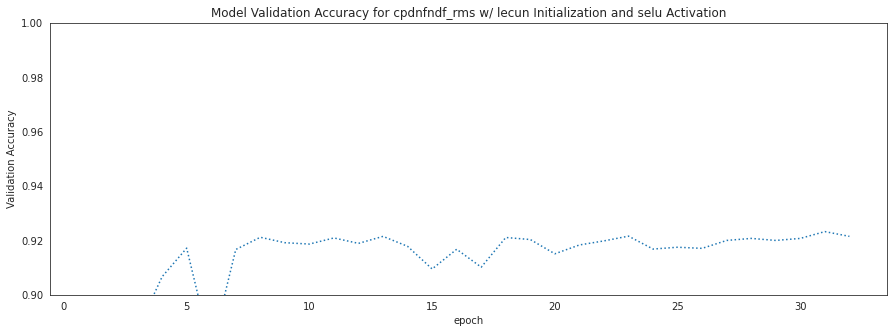

Max Validation Accuracy for cpdnfndf_rms w/ lecun Initialization and selu Activation is 0.9233
Final Validation Accuracy for cpdnfndf_rms w/ lecun Initialization and selu Activation is 0.9215

INFO:tensorflow:Assets written to: cpdnfndf_rms_lecun_selu/assets


In [ ]:
model_cpdnfndf_rms_lecun_selu, history_cpdnfndf_lecun_selu = model_eval(model_name='cpdnfndf_rms', init_fn_name='lecun', activation_fn='selu')
model_cpdnfndf_rms_lecun_selu.save('cpdnfndf_rms_lecun_selu')

#### Standard Normal initialization with tanh activations

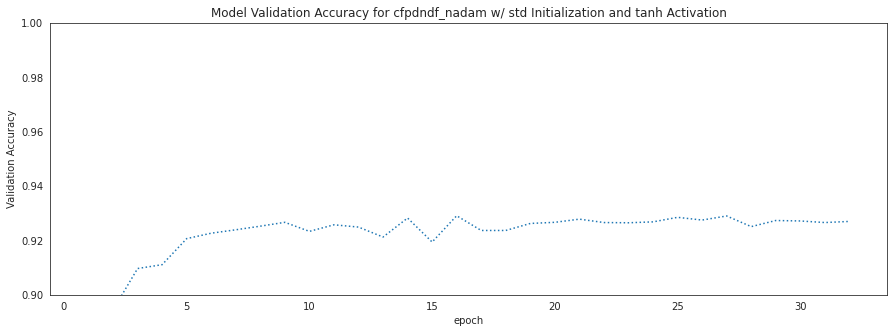

Max Validation Accuracy for cfpdndf_nadam w/ std Initialization and tanh Activation is 0.9291
Final Validation Accuracy for cfpdndf_nadam w/ std Initialization and tanh Activation is 0.9270

INFO:tensorflow:Assets written to: cfpdndf_nadam_std_tanh/assets


In [ ]:
model_cfpdndf_nadam_std_tanh, history_cfpdndf_nadam_std_tanh = model_eval(model_name='cfpdndf_nadam', init_fn_name='std', activation_fn='tanh')
model_cfpdndf_nadam_std_tanh.save('cfpdndf_nadam_std_tanh')

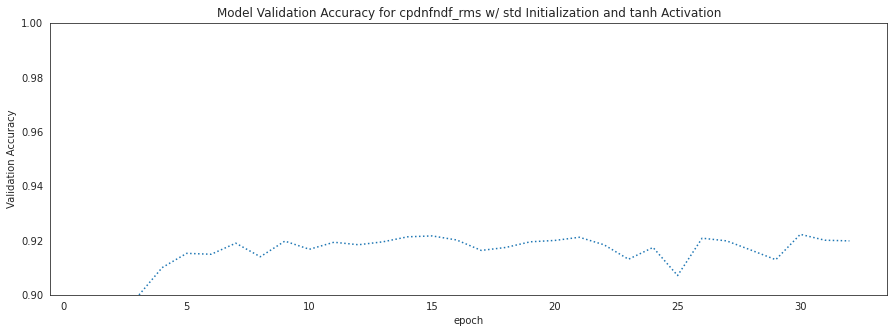

Max Validation Accuracy for cpdnfndf_rms w/ std Initialization and tanh Activation is 0.9222
Final Validation Accuracy for cpdnfndf_rms w/ std Initialization and tanh Activation is 0.9198

INFO:tensorflow:Assets written to: cpdnfndf_rms_std_tanh/assets


In [ ]:
model_cpdnfndf_rms_std_tanh, history_cpdnfndf_std_tanh = model_eval(model_name='cpdnfndf_rms', init_fn_name='std', activation_fn='tanh')
model_cpdnfndf_rms_std_tanh.save('cpdnfndf_rms_std_tanh')

#### Variance Scaling Initialization with tanh activation

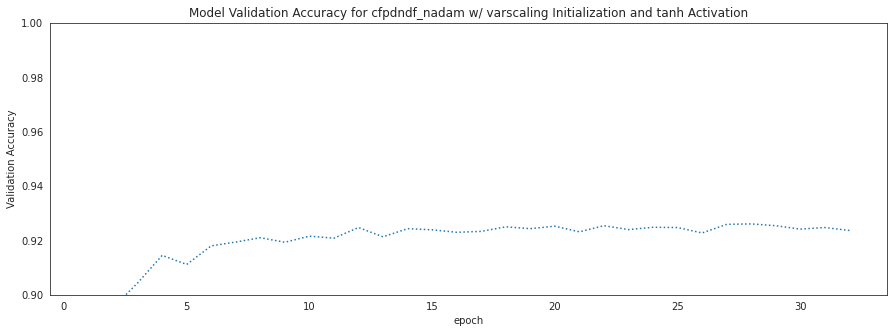

Max Validation Accuracy for cfpdndf_nadam w/ varscaling Initialization and tanh Activation is 0.9261
Final Validation Accuracy for cfpdndf_nadam w/ varscaling Initialization and tanh Activation is 0.9237

INFO:tensorflow:Assets written to: cfpdndf_nadam_varscale_tanh/assets


In [ ]:
model_cfpdndf_nadam_varscale_tanh, history_cfpdndf_nadam_varscale_tanh = model_eval(model_name='cfpdndf_nadam', init_fn_name='varscaling', activation_fn='tanh')
model_cfpdndf_nadam_varscale_tanh.save('cfpdndf_nadam_varscale_tanh')

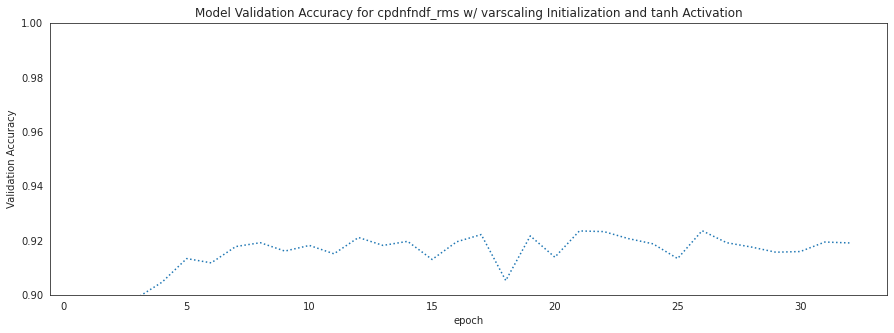

Max Validation Accuracy for cpdnfndf_rms w/ varscaling Initialization and tanh Activation is 0.9236
Final Validation Accuracy for cpdnfndf_rms w/ varscaling Initialization and tanh Activation is 0.9191

INFO:tensorflow:Assets written to: cpdnfndf_rms_varscale_tanh/assets


In [ ]:
model_cpdnfndf_rms_varscale_tanh, history_cpdnfndf_varscale_tanh = model_eval(model_name='cpdnfndf_rms', init_fn_name='varscaling', activation_fn='tanh')
model_cpdnfndf_rms_varscale_tanh.save('cpdnfndf_rms_varscale_tanh')

#### Putting it all together

In [ ]:
histories_cfpdndf = [history_cfpdndf,
                      history_cfpdndf_nadam_xavier_tanh,
                      history_cfpdndf_nadam_xavier_relu,
                      history_cfpdndf_nadam_he_relu,
                      history_cfpdndf_nadam_lecun_tanh,
                      history_cfpdndf_nadam_lecun_selu,
                      history_cfpdndf_nadam_std_tanh, 
                      history_cfpdndf_nadam_varscale_tanh]

In [ ]:
histories_cpdnfndf = [history_cpdnfndf,
                        history_cpdnfndf_rms_xavier_tanh,
                        history_cpdnfndf_rms_xavier_relu,
                        history_cpdnfndf_he_relu,
                        history_cpdnfndf_lecun_tanh,
                        history_cpdnfndf_lecun_selu,
                        history_cpdnfndf_std_tanh, 
                        history_cpdnfndf_std_tanh]

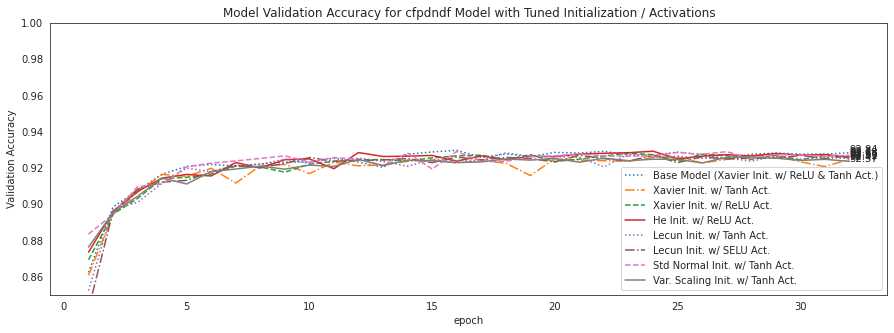

In [ ]:
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']
names = ['Base Model (Xavier Init. w/ ReLU & Tanh Act.)','Xavier Init. w/ Tanh Act.', 'Xavier Init. w/ ReLU Act.', 'He Init. w/ ReLU Act.', 'Lecun Init. w/ Tanh Act.', 'Lecun Init. w/ SELU Act.', 'Std Normal Init. w/ Tanh Act.', 'Var. Scaling Init. w/ Tanh Act.']
plt.figure(figsize=(15,5))
for i in range(len(names)):
    length = len(histories_cfpdndf[i].history['val_sparse_categorical_accuracy'])
    epochs_i = np.arange(length) + 1
    plt.plot(epochs_i, histories_cfpdndf[i].history['val_sparse_categorical_accuracy'],linestyle=styles[i])
    plt.text(epochs_i[-1], histories_cfpdndf[i].history['val_sparse_categorical_accuracy'][-1], str(round(100*histories_cfpdndf[i].history['val_sparse_categorical_accuracy'][-1],2)))
plt.title('Model Validation Accuracy for cfpdndf Model with Tuned Initialization / Activations')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.85,1])
plt.show()

In [ ]:
for i in range(len(histories_cfpdndf)):
  print('Max Validation Accuracy for '+ names[i] +' is {0:.4f}'.format(max(histories_cfpdndf[i].history['val_sparse_categorical_accuracy'])))
  print('Final Validation Accuracy for '+ names[i] +
        ' is {0:.4f}'.format(histories_cfpdndf[i].history['val_sparse_categorical_accuracy'][len(histories_cfpdndf[i].history['val_sparse_categorical_accuracy'])-1]))
  print('')

Max Validation Accuracy for Base Model (Xavier Init. w/ ReLU & Tanh Act.) is 0.9298
Final Validation Accuracy for Base Model (Xavier Init. w/ ReLU & Tanh Act.) is 0.9284

Max Validation Accuracy for Xavier Init. w/ Tanh Act. is 0.9270
Final Validation Accuracy for Xavier Init. w/ Tanh Act. is 0.9247

Max Validation Accuracy for Xavier Init. w/ ReLU Act. is 0.9282
Final Validation Accuracy for Xavier Init. w/ ReLU Act. is 0.9256

Max Validation Accuracy for He Init. w/ ReLU Act. is 0.9293
Final Validation Accuracy for He Init. w/ ReLU Act. is 0.9260

Max Validation Accuracy for Lecun Init. w/ Tanh Act. is 0.9283
Final Validation Accuracy for Lecun Init. w/ Tanh Act. is 0.9252

Max Validation Accuracy for Lecun Init. w/ SELU Act. is 0.9270
Final Validation Accuracy for Lecun Init. w/ SELU Act. is 0.9268

Max Validation Accuracy for Std Normal Init. w/ Tanh Act. is 0.9291
Final Validation Accuracy for Std Normal Init. w/ Tanh Act. is 0.9270

Max Validation Accuracy for Var. Scaling Init. 

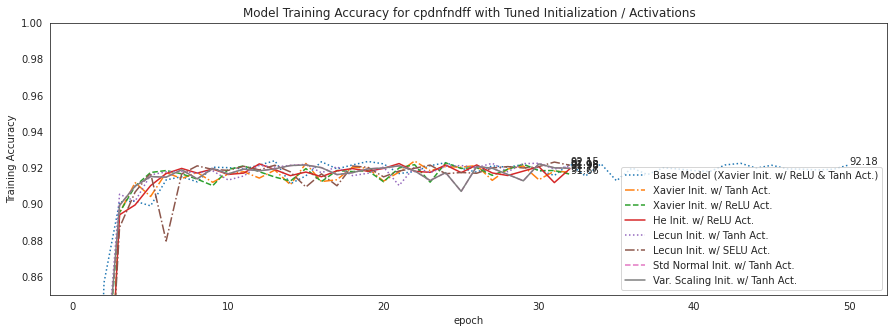

In [ ]:
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']
names = ['Base Model (Xavier Init. w/ ReLU & Tanh Act.)','Xavier Init. w/ Tanh Act.', 'Xavier Init. w/ ReLU Act.', 'He Init. w/ ReLU Act.', 'Lecun Init. w/ Tanh Act.', 'Lecun Init. w/ SELU Act.', 'Std Normal Init. w/ Tanh Act.', 'Var. Scaling Init. w/ Tanh Act.']
plt.figure(figsize=(15,5))
for i in range(len(names)):
    length = len(histories_cpdnfndf[i].history['val_sparse_categorical_accuracy'])
    epochs_i = np.arange(length) + 1
    plt.plot(epochs_i, histories_cpdnfndf[i].history['val_sparse_categorical_accuracy'],linestyle=styles[i])
    plt.text(epochs_i[-1], histories_cpdnfndf[i].history['val_sparse_categorical_accuracy'][-1], str(round(100*histories_cpdnfndf[i].history['val_sparse_categorical_accuracy'][-1],2)))
plt.title('Model Training Accuracy for cpdnfndff with Tuned Initialization / Activations')
plt.ylabel('Training Accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.85,1])
plt.show()

In [ ]:
for i in range(len(histories_cpdnfndf)):
  print('Max Validation Accuracy for '+ names[i] +' is {0:.4f}'.format(max(histories_cpdnfndf[i].history['val_sparse_categorical_accuracy'])))
  print('Final Validation Accuracy for '+ names[i] +
        ' is {0:.4f}'.format(histories_cpdnfndf[i].history['val_sparse_categorical_accuracy'][len(histories_cpdnfndf[i].history['val_sparse_categorical_accuracy'])-1]))
  print('')

Max Validation Accuracy for Base Model (Xavier Init. w/ ReLU & Tanh Act.) is 0.9240
Final Validation Accuracy for Base Model (Xavier Init. w/ ReLU & Tanh Act.) is 0.9218

Max Validation Accuracy for Xavier Init. w/ Tanh Act. is 0.9238
Final Validation Accuracy for Xavier Init. w/ Tanh Act. is 0.9177

Max Validation Accuracy for Xavier Init. w/ ReLU Act. is 0.9228
Final Validation Accuracy for Xavier Init. w/ ReLU Act. is 0.9166

Max Validation Accuracy for He Init. w/ ReLU Act. is 0.9224
Final Validation Accuracy for He Init. w/ ReLU Act. is 0.9196

Max Validation Accuracy for Lecun Init. w/ Tanh Act. is 0.9226
Final Validation Accuracy for Lecun Init. w/ Tanh Act. is 0.9210

Max Validation Accuracy for Lecun Init. w/ SELU Act. is 0.9233
Final Validation Accuracy for Lecun Init. w/ SELU Act. is 0.9215

Max Validation Accuracy for Std Normal Init. w/ Tanh Act. is 0.9222
Final Validation Accuracy for Std Normal Init. w/ Tanh Act. is 0.9198

Max Validation Accuracy for Var. Scaling Init. 

We conclude that the default initialization is sufficient for models 2 and 3.

## Regularization (Data Augmentation and Decaying Learning Rate)


We already implemented early stopping, batch normalization, and dropout in the architecture section. Hence, the remaining regularization techniques that we'll try are data augmentation and decaying learning rate.

For data augmentation, we tried different settings for rotation, zoom, shearing, width shift, height shift, and flipping by incrementally adding one new adjustment in each run and combined adjustments that seemed to improve validation accuracy. We also made sure that our augmentation preserved the images so that the objects would still be visible.

We made an empirical decision to decay at a rate of 0.9 so that the decay wouldn't be too fast.

In [ ]:
# Load data 
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))
# Normalize data x
x_train, x_test = tf.cast(x_train,dtype=tf.float32)/255.0, tf.cast(x_test,dtype=tf.float32)/255.0
# y_train, y_test = tf.one_hot(y_train, depth=10),tf.one_hot(y_test, depth=10)
print(f'Train data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

### Model 1 (ccpdnff w/ Adam)
To beat: 0.9298

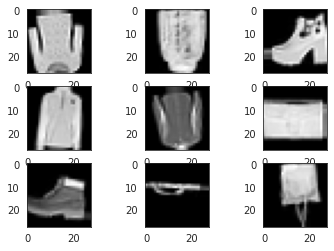

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        shear_range = 0.3,# shear angle in counter-clockwise direction in degrees  
        width_shift_range=0.08,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.08,  # randomly shift images vertically (fraction of total height)
        vertical_flip=True)  # randomly flip images

#train_datagen = ImageDataGenerator()
datagen.fit(x_train)

for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32):
  # create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
	# show the plot
	plt.show()
	break



In [ ]:
def ccpdnff_adam():
  # create model
  model = Sequential()

  model.add(Conv2D(input_shape = (28,28,1),filters=32,kernel_size=(3,3),activation='relu',padding='same',use_bias = False))
  model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu',padding='same', use_bias = False))
  
  model.add(MaxPooling2D(pool_size=(2,2), strides=None))

  model.add(Dropout(0.1))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=128, activation='sigmoid'))  
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer = Adam(learning_rate=0.0001),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  
  return model

In [ ]:
history_ccpdnff = []
reduce_lr = LearningRateScheduler(lambda x: 1e-4 * 0.9 ** x) # decaying learning rate
model = ccpdnff_adam()

history_ccpdnff = model.fit(x_train, y_train, batch_size = 256, epochs=32, callbacks=[reduce_lr],
                            validation_split = 0.2, verbose = 0)

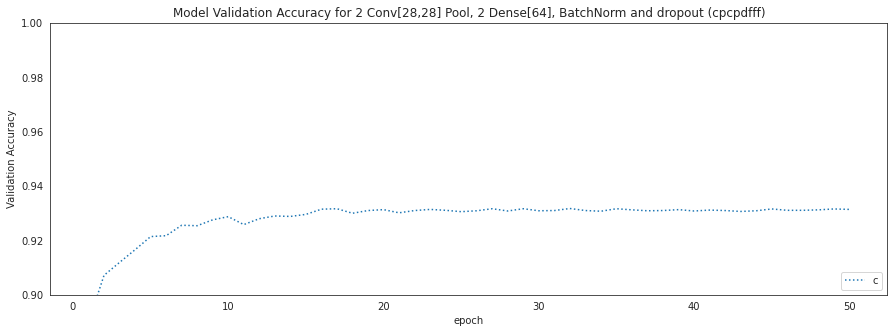

In [ ]:
# Plot validation accuracies 
names_ccpdnff = 'ccpdnff model'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_ccpdnff.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_ccpdnff.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for 2 Conv[28,28] Pool, 2 Dense[64], BatchNorm and dropout (cpcpdfff)')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_ccpdnff, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names_ccpdnff +' is {0:.4f}'.format(max(history_ccpdnff.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names_ccpdnff +
      ' is {0:.4f}'.format(history_ccpdnff.history['val_sparse_categorical_accuracy'][len(history_ccpdnff.history['val_sparse_categorical_accuracy'])-1]))
print('')

Max Validation Accuracy for ccpdnff model is 0.9317
Final Validation Accuracy for ccpdnff model is 0.9314



We end up with a 93.14% validation accuracy, so data augmentation improved the model.

### Model 2 (cfpdndf w/ Nadam)

To beat: 0.9247~0.9278

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        shear_range = 0.3,# shear angle in counter-clockwise direction in degrees  
        width_shift_range=0.08,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.08,  # randomly shift images vertically (fraction of total height)
        vertical_flip=True)  # randomly flip images

#train_datagen = ImageDataGenerator()
datagen.fit(x_train)

for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32):
  # create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
	# show the plot
	plt.show()
	break



In [ ]:
def cfpdndf_nadam():
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=128,
                   kernel_size= 3, strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = 'relu', use_bias = False))
  model.add(Dense(units=128, 
                  activation='relu'))

  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(units=128, 
                  activation='relu'))
  model.add(Dense(units = 10, activation = 'softmax'))

  
  return model

In [ ]:
history_cfpdndf = []
reduce_lr = LearningRateScheduler(lambda x: 1e-4 * 0.9 ** x) # decaying learning rate
model = cfpdndf_nadam()
model.compile(optimizer = Nadam(learning_rate=1e-4), 
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cfpdndf = model.fit(x_train, y_train, batch_size = 256, epochs=50, callbacks=[reduce_lr],
                            validation_split = 0.2, verbose = 0)

In [ ]:
# Plot validation accuracies 
names_cfpdndf = 'cfpdndf model'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cfpdndf.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cfpdndf.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for 2 Conv[28,28] Pool, 2 Dense[64], BatchNorm and dropout (cpcpdfff)')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_cfpdndf, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names_cfpdndf +' is {0:.4f}'.format(max(history_cfpdndf.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names_cfpdndf +
      ' is {0:.4f}'.format(history_cfpdndf.history['val_sparse_categorical_accuracy'][len(history_cfpdndf.history['val_sparse_categorical_accuracy'])-1]))
print('')

### Model 3 (cpdnfndf model with RMS)

To beat: .9250

In [ ]:
def cpdnfndf_rms():
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=112,
                   kernel_size= 5, strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = 'relu'))

  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=80, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(units=80, 
                  activation='relu'))
  model.add(Dense(units = 10, activation = 'softmax'))

  
  return model

In [ ]:
history_cpdnfndf = []
reduce_lr = LearningRateScheduler(lambda x: 1e-4 * 0.9 ** x) # decaying learning rate
model = cpdnfndf_rms()
model.compile(optimizer = RMSprop(learning_rate=1e-4), 
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cpdnfndf = model.fit(x_train, y_train, batch_size = 256, epochs=50, callbacks=[reduce_lr],
                            validation_split = 0.2, verbose = 0)

In [ ]:
# Plot validation accuracies 
names_cpdnfndf  = 'cpdnfndf model'
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))

length = len(history_cpdnfndf.history['val_sparse_categorical_accuracy'])
epochs_i = np.arange(length) + 1
plt.plot(epochs_i, history_cpdnfndf.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.title('Model Validation Accuracy for 2 {Conv[28,28],Dense[36]}, Dropout, Dense[36] (cfpcfpdfff)')
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(names_cpdnfndf, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.90,1])
plt.show()

In [ ]:
# Max validation accuracy per model for both case

print('Max Validation Accuracy for '+ names_cpdnfndf +
      ' is {0:.4f}'.format(max(history_cpdnfndf.history['val_sparse_categorical_accuracy'])))
print('Final Validation Accuracy for '+ names_cpdnfndf +
      ' is {0:.4f}'.format(history_cpdnfndf.history['val_sparse_categorical_accuracy'][len(history_cpdnfndf.history['val_sparse_categorical_accuracy'])-1]))
print('')

We conclude that there is no need for data augmentation for models 2 and 3.

## Summary of Test Accuracies of Best Models including Best MNIST model evaluated on Fashion MNIST

### MNIST Models

#### Base Model

* Test accuracy: 0.9518

#### Model 1 (ccpdnff w/ SGD)

* Test accuracy: 0.9920

#### Model 2 (cpcpdnfff w/ RMSprop)

* Test accuracy: 0.9933

#### Model 3 (cfpncdfpdnff w/ RMSprop)

* Test accuracy: 0.9923

### Fashion MNIST Models

#### Base Model
*   Test accuracy: 0.8589

#### Model 1 (ccpdnff w/ SGD)
* Test accuracy: 0.9223

#### Model 2 (cpcpdnfff w/ RMSprop)

* Test accuracy: 0.9129

#### Model 3 (cfpncdfpdnff w/ RMSprop)

* Test accuracy: 0.9112

#### New Model 1 (ccpdnff w/ Adam, default initialization, data augmentation)
  * Test accuracy: 0.9284

In [ ]:
# Load data 
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))
# Normalize data x
x_train, x_test = tf.cast(x_train,dtype=tf.float32)/255.0, tf.cast(x_test,dtype=tf.float32)/255.0
# y_train, y_test = tf.one_hot(y_train, depth=10),tf.one_hot(y_test, depth=10)
print(f'Train data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')
class_names = ['T-shirt/top', 'Trouser', 'Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

4423680/4422102 [==============================] - 0s 0us/step
Train data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


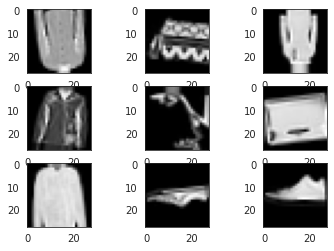

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        shear_range = 0.3,# shear angle in counter-clockwise direction in degrees  
        width_shift_range=0.08,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.08,  # randomly shift images vertically (fraction of total height)
        vertical_flip=True)  # randomly flip images

#train_datagen = ImageDataGenerator()
datagen.fit(x_train)

for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32):
  # create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
	# show the plot
	plt.show()
	break



In [ ]:
def ccpdnff_adam():
  # create model
  model = Sequential()

  model.add(Conv2D(input_shape = (28,28,1),filters=32,kernel_size=(3,3),activation='relu',padding='same',use_bias = False))
  model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu',padding='same', use_bias = False))
  
  model.add(MaxPooling2D(pool_size=(2,2), strides=None))

  model.add(Dropout(0.1))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=128, activation='sigmoid'))  
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer = Adam(learning_rate=0.0001),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
  
  return model

In [ ]:
history_ccpdnff = []
reduce_lr = LearningRateScheduler(lambda x: 1e-4 * 0.9 ** x) # decaying learning rate
model = ccpdnff_adam()

history_ccpdnff = model.fit(x_train, y_train, batch_size = 256, epochs=50, callbacks=[reduce_lr],
                            validation_split = 0.2, verbose = 0)

In [ ]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2137 - sparse_categorical_accuracy: 0.9284


[0.2136896252632141, 0.9283999800682068]

As ccpdnff (Adam) was our best performing model, we analyze where we did well in prediction and where we could improve (low prediction accuracy categories). It turns out that our model predicts some categories quite well (99% precision and 98% recall for "Trouser" and "Sandal") but fails to distinguish between other categories like "Shirt" and "T-shirt/top" (precision and recall in the 80%'s). Upon further examination, it is quite difficult even for human eyes to categorize an article of clothing as a "T-shirt/top" or just a "Shirt", so we are content with the results of our models in this section for Fashion-MNIST.

In [ ]:
#get the predictions for the test data
p = model.predict(x_test)
y_pred = np.apply_along_axis(np.argmax, 1, p)
correct = np.where(y_pred==y_test)[0] 
incorrect = np.where(y_pred!=y_test)[0] 
print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 9243
Incorrect predicted classes: 757


In [ ]:
# Prediction performance per category
target_names = ["Class {} ({}) :".format(i,class_names[i]) for i in range(10)]
print(classification_report(y_test, y_pred, target_names=target_names))

                         precision    recall  f1-score   support

Class 0 (T-shirt/top) :       0.88      0.88      0.88      1000
    Class 1 (Trouser) :       0.99      0.98      0.99      1000
   Class 2 (Pullover) :       0.88      0.87      0.88      1000
      Class 3 (Dress) :       0.91      0.93      0.92      1000
       Class 4 (Coat) :       0.87      0.89      0.88      1000
     Class 5 (Sandal) :       0.99      0.98      0.98      1000
      Class 6 (Shirt) :       0.80      0.78      0.79      1000
    Class 7 (Sneaker) :       0.96      0.98      0.97      1000
        Class 8 (Bag) :       0.98      0.98      0.98      1000
 Class 9 (Ankle boot) :       0.98      0.97      0.97      1000

               accuracy                           0.92     10000
              macro avg       0.92      0.92      0.92     10000
           weighted avg       0.92      0.92      0.92     10000



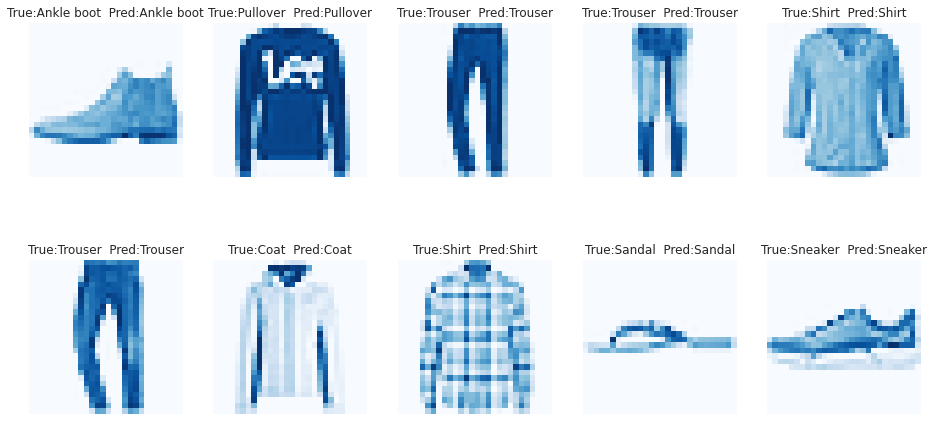

In [ ]:
def plot_images(data_index,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(2,5, figsize=(16,8))

    for i, indx in enumerate(data_index[:10]):
        ax[i//5, i%5].imshow(x_test[indx,:,:,0], cmap=cmap)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("True:{}  Pred:{}".format(class_names[y_test[indx]],class_names[y_pred[indx]]))
    plt.show()    
    
plot_images(correct, "Blues")

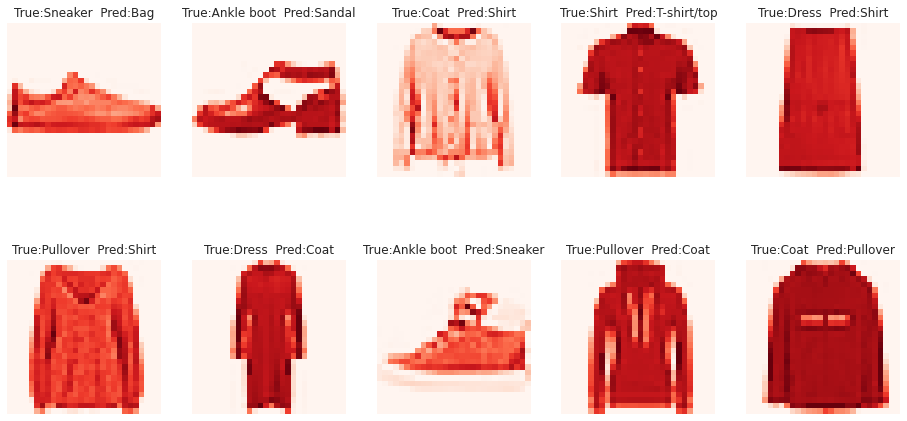

In [ ]:
plot_images(incorrect, "Reds")

#### New Model 2 (cfpdndff w/ Nadam)

* Test accuracy: 0.9236 (1%+ improvement after re-running the process with Fashion MNIST data)

In [ ]:
# Load data 
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))
# Normalize data x
x_train, x_test = tf.cast(x_train,dtype=tf.float32)/255.0, tf.cast(x_test,dtype=tf.float32)/255.0
# y_train, y_test = tf.one_hot(y_train, depth=10),tf.one_hot(y_test, depth=10)
print(f'Train data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

In [ ]:
def cfpdndf_nadam():
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=112,
                   kernel_size= 3, strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = 'relu', use_bias = False))
  model.add(Dense(units=112, 
                  activation='relu'))

  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(units=112, 
                  activation='relu'))
  model.add(Dense(units = 10, activation = 'softmax'))

  
  return model

In [ ]:
history_cfpdndf = []
reduce_lr = LearningRateScheduler(lambda x: 1e-4 * 0.9 ** x) # decaying learning rate
model = cfpdndf_nadam()
model.compile(optimizer = Nadam(learning_rate=1e-4), 
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cfpdndf = model.fit(x_train, y_train, batch_size = 256, epochs=50, callbacks=[reduce_lr],
                            validation_split = 0.2, verbose = 0)

In [ ]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2316 - sparse_categorical_accuracy: 0.9236


[0.23156586289405823, 0.9236000180244446]

#### New Model 3 (cpdnfndff w/ RMSprop)

* Test accuracy: 0.9252 (1%+ improvement after re-running the process with Fashion MNIST data)

In [ ]:
def cpdnfndf_rms():
  model = Sequential()
  model.add(Conv2D(input_shape = (28,28,1),filters=112,
                   kernel_size= 5, strides= 1,
                            padding= 'same', # 3x3 kernel (square), padding: 'valid' - no padding, 'same': with zero padding,
                            activation = 'relu'))

  model.add(MaxPooling2D(pool_size=2, strides=None))

  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(units=80, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(units=80, 
                  activation='relu'))
  model.add(Dense(units = 10, activation = 'softmax'))

  
  return model

In [ ]:
history_cpdnfndf = []
reduce_lr = LearningRateScheduler(lambda x: 1e-4 * 0.9 ** x) # decaying learning rate
model = cpdnfndf_rms()
model.compile(optimizer = RMSprop(learning_rate=1e-4), 
                                                            #  Nadam(hp.Choice('learning_rate', values=[1e-2,1e-3])), #Nadam
                                                            #  RMSprop(hp.Choice('learning_rate', values=[1e-2,1e-3])), #RMSprop
                                                            #  SGD(hp.Choice('learning_rate', values=[1e-1,1e-2]))]),
          loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#based on one-hot vector; if 'categorical_crossentropy' then from_logits=False
          metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
history_cpdnfndf = model.fit(x_train, y_train, batch_size = 256, epochs=50, callbacks=[reduce_lr],
                            validation_split = 0.2, verbose = 0)

In [ ]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2476 - sparse_categorical_accuracy: 0.9252


[0.24762021005153656, 0.9251999855041504]

Hence, New Model 1 performed best on Fashion MNIST.